In [2]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3
# %matplotlib inline
%matplotlib qt5
import mne
mne.viz.set_browser_backend("qt")  # or "matplotlib"
mne.set_config("MNE_BROWSER_BACKEND", "qt")  # or "matplotlib"
%gui qt

import IPython

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Automatic pdb calling has been turned OFF
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'qt'


# Use MNE to load and analyze saved EEG and Motion recordings


In [3]:
import time
import re
from datetime import datetime, timezone

import uuid
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from nptyping import NDArray
from matplotlib import pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
from numpy.typing import NDArray

import mne
from mne import set_log_level
from copy import deepcopy
import mne

from mne.io import read_raw

datasets = []
# mne.viz.set_browser_backend("Matplotlib")
mne.viz.set_browser_backend("qt")

from mne_lsl.player import PlayerLSL as Player
from mne_lsl.stream import StreamLSL as Stream

from phoofflineeeganalysis.analysis.MNE_helpers import MNEHelpers
from phoofflineeeganalysis.analysis.historical_data import HistoricalData
from phoofflineeeganalysis.analysis.motion_data import MotionData
from phoofflineeeganalysis.analysis.EEG_data import EEGComputations, EEGData
from phoofflineeeganalysis.analysis.anatomy_and_electrodes import ElectrodeHelper
# from ..EegProcessing import bandpower
# from phoofflineeeganalysis.EegProcessing import analyze_eeg_trends
from phoofflineeeganalysis.EegVisualization import VisHelpers
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import SavedSessionsProcessor, SessionModality, DataModalityType

set_log_level("WARNING")

# eeg_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEpocX_EEGRecordings/fif').resolve()
# headset_motion_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEpocX_EEGRecordings/MOTION_RECORDINGS/fif').resolve()

# assert eeg_recordings_file_path.exists()
# assert headset_motion_recordings_file_path.exists()

eeg_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEpocX_EEGRecordings/fif').resolve()
flutter_eeg_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEEG_FlutterRecordings').resolve()
flutter_motion_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEEG_FlutterRecordings/MOTION_RECORDINGS').resolve()
flutter_GENERIC_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEEG_FlutterRecordings/GENERIC_RECORDINGS').resolve()

headset_motion_recordings_file_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/EmotivEpocX_EEGRecordings/MOTION_RECORDINGS/fif').resolve()
WhisperVideoTranscripts_LSL_Converted = Path(r"E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted").resolve()
pho_log_to_LSL_recordings_path: Path = Path(r'E:/Dropbox (Personal)/Databases/UnparsedData/PhoLogToLabStreamingLayer_logs').resolve()
## These contain little LSL .fif files with names like: '20250808_062814_log.fif', 

eeg_analyzed_parent_export_path = Path("E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed").resolve()
pickled_data_path = Path(r"E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/PICKLED_COLLECTION").resolve()
assert pickled_data_path.exists()

# n_most_recent_sessions_to_preprocess: int = None # None means all sessions
# n_most_recent_sessions_to_preprocess: int = 35
# n_most_recent_sessions_to_preprocess: int = 5
n_most_recent_sessions_to_preprocess = None


'qt'

Using matplotlib as 2D backend.


# SavedSessionProcessor

In [4]:

sso: SavedSessionsProcessor = SavedSessionsProcessor(eeg_recordings_file_path=eeg_recordings_file_path,
                                                     headset_motion_recordings_file_path=headset_motion_recordings_file_path, WhisperVideoTranscripts_LSL_Converted_file_path=WhisperVideoTranscripts_LSL_Converted, pho_log_to_LSL_recordings_path=pho_log_to_LSL_recordings_path,
                                                    eeg_analyzed_parent_export_path=eeg_analyzed_parent_export_path, 
                                                     n_most_recent_sessions_to_preprocess=n_most_recent_sessions_to_preprocess, 
                                                    should_load_data=True, should_load_preprocessed=False,
                                                    #  should_load_data=True, should_load_preprocessed=True,
													)

In [ ]:
(flat_data_modality_dict, found_recording_file_modality_dict) = sso.setup_specific_modality(modality_type=[DataModalityType.EEG, DataModalityType.MOTION, DataModalityType.PHO_LOG_TO_LSL, DataModalityType.WHISPER], should_load_data=False)

## 3m 0.3s

## 2025-09-09 - Manual Read to determine only the new/modified EEG files

In [ ]:
from phoofflineeeganalysis.analysis.historical_data import HistoricalData

updated_file_paths, (pending_updated_recording_file_df, modern_found_EEG_recording_file_df, pre_processed_EEG_recording_file_df) = HistoricalData.discover_updated_recording_files(eeg_recordings_file_path=sso.eeg_recordings_file_path, eeg_analyzed_parent_export_path=sso.eeg_analyzed_parent_export_path)
# updated_file_paths
flat_data_modality_dict = HistoricalData.read_recording_files(found_recording_file_modality_dict={DataModalityType.EEG.name: updated_file_paths}, should_load_data=True)
flat_data_modality_dict

In [ ]:
flat_data_modality_dict, found_recording_file_modality_dict = HistoricalData.MAIN_process_recording_files(
    eeg_recordings_file_path = sso.eeg_analyzed_parent_export_path,
    # headset_motion_recordings_file_path = self.headset_motion_recordings_file_path,
    # WhisperVideoTranscripts_LSL_Converted = self.WhisperVideoTranscripts_LSL_Converted_file_path,
    # pho_log_to_LSL_recordings_path = self.pho_log_to_LSL_recordings_path,
    should_load_data=False,
    # should_load_data=sso.should_load_data,
)



# 1m 7sec



# ## #TODO 2025-09-09 16:14: - [ ] Find the files that changed since last processing, and only load those:
# flat_data_modality_dict, found_recording_file_modality_dict = HistoricalData.MAIN_process_recording_files(
#     eeg_recordings_file_path = sso.eeg_recordings_file_path,
#     headset_motion_recordings_file_path = sso.headset_motion_recordings_file_path,
#     WhisperVideoTranscripts_LSL_Converted = sso.WhisperVideoTranscripts_LSL_Converted_file_path,
#     pho_log_to_LSL_recordings_path = sso.pho_log_to_LSL_recordings_path,
#     should_load_data=sso.should_load_data,
# )


In [ ]:

# prev_processed_modality_EEG: SessionModality = flat_data_modality_dict[DataModalityType.EEG.name]  ## Unpacking
_, prev_processed_datasets, prev_processed_df_EEG = flat_data_modality_dict[DataModalityType.EEG.name]  ## Unpacking
prev_processed_datasets
# prev_processed_df_EEG


[a_raw for a_raw in prev_processed_datasets]
a_raw = prev_processed_datasets[-1]
a_raw






In [ ]:
prev_processed_df_EEG: pd.DataFrame = prev_processed_modality_EEG.df  ## Unpacking
prev_processed_df_EEG['duration'] = prev_processed_df_EEG['end_time'] - prev_processed_df_EEG['start_time']
prev_processed_df_EEG



# Resume main pipleine

In [ ]:
sso.perform_post_processing() # Filename '2024-09-11 15-27-36.lsl.fif' does not contain a recognized datetime format.
## 3m 7.5s
## 33m 42s - 578 records

In [ ]:
written_EDF_file_paths = sso.save_to_EDF()
written_EDF_file_paths

## Keep record of the processed files so they don't have to be re-processed each time

In [ ]:
sso

In [ ]:
## Get the records of all procesed files
eeg_df: pd.DataFrame = deepcopy(sso.modalities['EEG'].df)
eeg_df



In [ ]:
for a_name in ('EEG', 'MOTION'):
    if 'duration' not in sso.modalities[a_name].df.columns:
        sso.modalities[a_name].df['duration'] = sso.modalities[a_name].df['end_time'] - sso.modalities[a_name].df['start_time']


In [ ]:
sso.modalities['PHO_LOG_TO_LSL'].df

In [ ]:
active_MOTION_idx: int = -3
# a_raw_data: mne.io.Raw = sso.modalities['PHO_LOG_TO_LSL'].datasets[active_PHO_LOG_TO_LSL_idx]
active_modality = sso.modalities['MOTION']
an_active_idx = active_modality.active_indices[active_MOTION_idx]
a_raw: mne.io.Raw = active_modality.datasets[an_active_idx]
an_annotations = deepcopy(a_raw.annotations)
an_annotations
a_raw

In [ ]:
a_raw.info

In [ ]:
from phoofflineeeganalysis.analysis.event_data import EventData

## Get high-accel periods from the motion:
active_modality: SessionModality = sso.modalities['MOTION']
high_accel_periods = [active_modality.analysis_results[a_motion_IDX]['bad_periods_annotations']['high_accel'] for i, a_motion_IDX in enumerate(active_modality.active_indices)]
high_accel_periods


In [ ]:

all_MOTION_df: pd.DataFrame = EventData.complete_correct_COMMON_annotation_df(a_logging_modality=active_modality, dataset_idx_col_name='MOTION_idx')

In [ ]:
all_MOTION_df

In [ ]:
active_EEG_idx: int = -15
# a_raw_data: mne.io.Raw = sso.modalities['PHO_LOG_TO_LSL'].datasets[active_PHO_LOG_TO_LSL_idx]
an_active_idx = sso.modalities['EEG'].active_indices[active_EEG_idx]
a_raw: mne.io.Raw = sso.modalities['EEG'].datasets[an_active_idx]
an_annotations: mne.Annotations = deepcopy(a_raw.annotations)
an_annotations


In [ ]:
eeg_df: pd.DataFrame = deepcopy(sso.modalities['EEG'].df)
eeg_df


In [ ]:
from phoofflineeeganalysis.analysis.MNE_helpers import MNEHelpers

(a_df, an_annotations_df) = MNEHelpers.get_raw_datetime_indexed_df(a_raw=a_raw, dt_col_names=['time'])
a_df
an_annotations_df

In [ ]:
an_annotations_df



In [ ]:
def perform_simplify_MOTION_annotation_df(an_annotations_df: pd.DataFrame) -> pd.DataFrame:
    MOTION_idx_col_name: str = 'MOTION_idx'
    ## INPUTS: an_annotations_df
    groups = an_annotations_df.groupby((an_annotations_df['description'] != an_annotations_df['description'].shift()).cumsum()) # grouped by 'description' value
    results = []
    for _, g in groups:
        if len(g) > 1:
            first, last = g.iloc[0], g.iloc[-1]
            duration: float = last['onset'] - first['onset']
            # results.append({'description': first['description'], 'start': first['onset'], 'end': last['onset'], 'duration': duration})
            _additional_col_names = ['filepath', 'filename', MOTION_idx_col_name, 'file_meas_date']
            # _additional_cols = {'filepath': first['filepath'], 'filename': first['filename'], 'WHISPER_idx': first['WHISPER_idx'], 'file_meas_date': first['file_meas_date']}                
            _additional_cols = {k:first[k] for k in _additional_col_names if (first.get(k, None) is not None)}
            results.append({'onset': first['onset'], 'duration': duration, 'description': first['description'], **_additional_cols})

    dedup_an_annotations_df = pd.DataFrame(results)
    return dedup_an_annotations_df
## OUTPUTS: dedup_an_annotations_df

In [ ]:
from phoofflineeeganalysis.analysis.event_data import EventData

## Get high-accel periods from the motion:
active_modality: SessionModality = sso.modalities['MOTION']
# high_accel_periods = [active_modality.analysis_results[a_motion_IDX]['bad_periods_annotations']['high_accel'].to_data_frame(time_format='datetime') for i, a_motion_IDX in enumerate(active_modality.active_indices)]
high_accel_period_dfs = [perform_simplify_MOTION_annotation_df(an_annotations_df=active_modality.analysis_results[a_motion_IDX]['bad_periods_annotations']['high_accel'].to_data_frame(time_format='datetime')) for i, a_motion_IDX in enumerate(active_modality.active_indices)]
high_accel_period_dfs


In [ ]:
from phoofflineeeganalysis.analysis.MNE_helpers import MNEHelpers

## INPUTS: all_WHISPER_df, all_pho_log_to_lsl_df, high_accel_periods
eeg_df: pd.DataFrame = deepcopy(sso.modalities['EEG'].df)

# curr_eeg_min_dt = eeg_df[['start_time', 'end_time']]
# curr_eeg_min_dt = eeg_df['start_time'].to_numpy()
# curr_eeg_max_dt = eeg_df['end_time'].to_numpy()
# curr_eeg_min_dt = eeg_df['start_time'].dt.to_pydatetime()
# curr_eeg_max_dt = eeg_df['end_time'].dt.to_pydatetime()
curr_eeg_min_dts = eeg_df['start_time'].dt.as_unit('s').dt.tz_localize("UTC")
curr_eeg_max_dts = eeg_df['end_time'].dt.as_unit('s').dt.tz_localize("UTC")

# np.shape(curr_eeg_min_dts)
# np.shape(curr_eeg_max_dts)
# curr_eeg_min_dt
# all_pho_log_to_lsl_df['onset'].to_numpy()
# curr_eeg_min_dt, curr_eeg_max_dt = (a_df['time'].min(), a_df['time'].max())

# curr_eeg_min_dt, curr_eeg_max_dt = (a_df['time'].min(), a_df['time'].max())

assert len(curr_eeg_min_dts) == len(curr_eeg_max_dts)
n_eeg_start_end_entries: int = len(curr_eeg_max_dts)
# found_pho_log_to_lsl_df_matches = []
# found_WHISPER_df_matches = []
found_pho_log_to_lsl_df_matches = {}
found_WHISPER_df_matches = {}

## INPUTS: motion_df, all_pho_log_to_lsl_df, all_WHISPER_df

needs_modification_eeg_IDXs = []

for an_xdf_dataset_idx in np.arange(n_eeg_start_end_entries):
    curr_eeg_dataset_IDX: int = eeg_df['dataset_IDX'].to_numpy()[an_xdf_dataset_idx]
    curr_eeg_min_dt = curr_eeg_min_dts[an_xdf_dataset_idx]
    curr_eeg_max_dt = curr_eeg_max_dts[an_xdf_dataset_idx]
    
    # a_raw = sso.modalities['EEG'].datasets[curr_eeg_dataset_IDX]
    a_raw: mne.io.Raw = sso.modalities['EEG'].datasets[curr_eeg_dataset_IDX]
    an_annotations = deepcopy(a_raw.annotations)
    (a_df, an_annotations_df) = MNEHelpers.get_raw_datetime_indexed_df(a_raw=a_raw, dt_col_names=['time'], debug_print=False)
        

    # np.shape(input_col) # 986
    is_in_curr_eeg_sess = np.logical_and((curr_eeg_min_dt <= all_pho_log_to_lsl_df['onset'].to_numpy()), (all_pho_log_to_lsl_df['onset'].to_numpy() <= curr_eeg_max_dt))
    # found_pho_log_to_lsl_df_matches.append(np.where(is_in_curr_eeg_sess)[0])
    found_pho_log_to_lsl_df_matches[curr_eeg_dataset_IDX] = np.where(is_in_curr_eeg_sess)[0]
    ## Add Pho_LOG Records:
    # all_pho_log_to_lsl_df[is_in_curr_eeg_sess]
    
    is_in_curr_WHISPER_eeg_sess = np.logical_and((curr_eeg_min_dt <= all_WHISPER_df['onset'].to_numpy()), (all_WHISPER_df['onset'].to_numpy() <= curr_eeg_max_dt))
    # found_WHISPER_df_matches.append(np.where(is_in_curr_WHISPER_eeg_sess)[0])
    found_WHISPER_df_matches[curr_eeg_dataset_IDX] = np.where(is_in_curr_WHISPER_eeg_sess)[0]
    ## Add Whisper Records:
    # all_WHISPER_df[is_in_curr_WHISPER_eeg_sess]
    if (len(found_pho_log_to_lsl_df_matches[curr_eeg_dataset_IDX]) > 0) or (len(found_WHISPER_df_matches[curr_eeg_dataset_IDX]) > 0):
        print(f'i: curr_eeg_dataset_IDX: {curr_eeg_dataset_IDX} needs modification.')
        needs_modification_eeg_IDXs.append(curr_eeg_dataset_IDX)

## OUTPUTS: found_pho_log_to_lsl_df_matches, found_WHISPER_df_matches

In [ ]:
_old_annotations_obj = {}
_new_annotations_obj = {}

for an_xdf_dataset_idx, curr_eeg_dataset_IDX in enumerate(needs_modification_eeg_IDXs):
    # if i in [0, 1, 2]:
    # curr_eeg_dataset_IDX: int = eeg_df['dataset_IDX'].to_numpy()[i]
    # curr_eeg_min_dt = curr_eeg_min_dts[i]
    # curr_eeg_max_dt = curr_eeg_max_dts[i]
    
    # a_raw = sso.modalities['EEG'].datasets[curr_eeg_dataset_IDX]
    a_raw: mne.io.Raw = sso.modalities['EEG'].datasets[curr_eeg_dataset_IDX]
    a_meas_date = a_raw.info.get('meas_date')
    an_annotations = deepcopy(a_raw.annotations)
    (a_df, an_annotations_df) = MNEHelpers.get_raw_datetime_indexed_df(a_raw=a_raw, dt_col_names=['time'], also_process_annotations=True, debug_print=False)
    _old_annotations_obj[curr_eeg_dataset_IDX] = an_annotations
    _old_num_annotations: int = len(an_annotations_df)
    
    all_annotations_df = [an_annotations_df]
    ## Add Pho_LOG Records:
    a_found_pho_log_to_lsl_df_matches = found_pho_log_to_lsl_df_matches[curr_eeg_dataset_IDX]
    all_annotations_df.append(all_pho_log_to_lsl_df.iloc[a_found_pho_log_to_lsl_df_matches])

    ## Add Whisper Records:
    a_found_WHISPER_df_matches = found_WHISPER_df_matches[curr_eeg_dataset_IDX]
    all_annotations_df.append(all_WHISPER_df.iloc[a_found_WHISPER_df_matches])
    # all_annotations_df
    
    ## append all:
    all_annotations_df = pd.concat(all_annotations_df, ignore_index=True, axis='index')
    new_annotation_df_len: int = len(all_annotations_df)
    if new_annotation_df_len > 0:
        # Set new annotations object:
        curr_onset = (all_annotations_df['onset'].to_numpy() - a_meas_date)
        curr_onset_seconds = np.array([td.total_seconds() for td in curr_onset])
        # new_annotations_obj = mne.Annotations(onset=all_annotations_df['onset'].to_numpy(), duration=all_annotations_df['duration'].to_numpy(), description=all_annotations_df['description'].to_numpy(), orig_time=a_meas_date)
        new_annotations_obj = mne.Annotations(onset=curr_onset_seconds, duration=all_annotations_df['duration'].to_numpy(), description=all_annotations_df['description'].to_numpy(), orig_time=a_meas_date)
        _new_annotations_obj[curr_eeg_dataset_IDX] = new_annotations_obj
        # a_raw.set_annotations(new_annotations_obj) ## set annotations:

# a_df
# len(a_raw.annotations)
# a_raw.set_annotations(
# len(all_annotations_df)
# all_annotations_df
# Set new annotations object:
# new_annotations_obj = mne.Annotations(onset=an_annotations_df['onset'].to_numpy(), duration=an_annotations_df['duration'].to_numpy(), description=an_annotations_df['description'].to_numpy(), orig_time=a_meas_date)
# a_raw.set_annotations(new_annotations_obj)


# an_annotations_df

In [ ]:
curr_onset_seconds

In [ ]:
# _new_annotations_obj
len(new_annotations_obj)


In [ ]:
len(an_annotations)

len(an_annotations_df)
an_annotations_df


In [ ]:

all_pho_log_to_lsl_df[is_in_curr_eeg_sess]

all_WHISPER_df[is_in_curr_WHISPER_eeg_sess]

In [ ]:
found_pho_log_to_lsl_df_matches

In [ ]:


abs_start_t = a_ds.times[0] + a_ds.info['meas_date'].timestamp()
abs_end_t = a_ds.times[-1] + a_ds.info['meas_date'].timestamp()

# abs_start_t = pd.to_timedelta(a_ds.times[0]) + a_ds.info['meas_date']
# abs_end_t = pd.to_timedelta(a_ds.times[-1]) + a_ds.info['meas_date']


# type(abs_start_t)
(abs_start_t, abs_end_t)


In [ ]:

abs_start_dt = pd.to_datetime(abs_start_t)
abs_end_dt = pd.to_datetime(abs_end_t)

(abs_start_dt, abs_end_dt)


In [ ]:
an_annotations.count()
# an_annotations.to_data_frame()

In [ ]:
# np.shape(sso.modalities['PHO_LOG_TO_LSL'].datasets[-1].get_data()) # (1, 94975)
# sso.modalities['PHO_LOG_TO_LSL'].datasets[-1].to_data_frame()
# sso.modalities['PHO_LOG_TO_LSL'].datasets[-1].to_data_frame()
sso.modalities['PHO_LOG_TO_LSL'].datasets[-1].annotations


# 2025-09-18 - Complete Event Parsing

In [ ]:
from phoofflineeeganalysis.analysis.event_data import EventData

all_pho_log_to_lsl_df: pd.DataFrame = EventData.complete_correct_Pho_Log_To_LSL_annotation_df(a_logging_modality=sso.modalities['PHO_LOG_TO_LSL'])
all_pho_log_to_lsl_df

In [ ]:
output_folder: Path = sso.eeg_analyzed_parent_export_path.joinpath('outputs')
output_folder.mkdir(exist_ok=True)

all_pho_log_to_lsl_df_csv_path = output_folder.joinpath('2025-09-18_PHO_LOG_TO_LSL.csv').resolve()
all_pho_log_to_lsl_df_csv_path

all_WHISPER_df_csv_path = output_folder.joinpath('2025-09-18_WHISPER.csv').resolve()
all_WHISPER_df_csv_path


In [ ]:
all_pho_log_to_lsl_df.to_csv(all_pho_log_to_lsl_df_csv_path)

In [ ]:
from phoofflineeeganalysis.analysis.event_data import EventData

all_WHISPER_df: pd.DataFrame = EventData.complete_correct_WHISPER_annotation_df(a_logging_modality=sso.modalities['WHISPER'])
all_WHISPER_df

In [ ]:
all_WHISPER_df.to_csv(all_WHISPER_df_csv_path)

In [ ]:
motion_df


In [ ]:
hdf5_out_path: Path = Path('E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed').joinpath('2025-09-18_all_HDF.h5').resolve()
hdf5_out_path


all_WHISPER_df.drop(columns=['filepath']).to_hdf(hdf5_out_path, key='modalities/WHISPER/df', append=True)
all_pho_log_to_lsl_df.drop(columns=['filepath']).to_hdf(hdf5_out_path, key='modalities/PHO_LOG_TO_LSL/df', append=True)


In [ ]:
all_pho_log_to_lsl_df.drop(columns=['filepath']).to_hdf(hdf5_out_path, key='modalities/PHO_LOG_TO_LSL/df', append=True)

In [ ]:
an_annotations = deepcopy(sso.modalities['EEG'].datasets[-1].annotations)
an_annotations


In [ ]:
an_annotations.orig_time


In [ ]:
eeg_to_motion_idx_list = eeg_df['motion_idxs'].to_list()
eeg_to_motion_idx_list ## get the hard-index


In [ ]:
eeg_abs_motion_indicies = [[motion_active_indices[v] for v in k_list] for k_list in eeg_to_motion_idx_list] ## convert to absolute motion indicies
eeg_abs_motion_indicies


In [ ]:
motion_df: pd.DataFrame = deepcopy(sso.modalities['MOTION'].df)
motion_active_indices = deepcopy(sso.modalities['MOTION'].active_indices)

motion_df
 

In [ ]:
def detect_motion_artifacts(raw, picks=None, threshold_factor=6, min_duration=0.05, description='MOTION'):
    picks = mne.pick_types(raw.info, eeg=True, meg=False, exclude='bads') if picks is None else picks
    data, times = raw.get_data(picks=picks, return_times=True)
    sfreq = raw.info['sfreq']
    rms = np.sqrt(np.mean(data**2, axis=0))                        # cross-channel RMS time-series
    med = np.median(rms)
    mad = np.median(np.abs(rms - med)) or 1e-12                   # robust scale
    thresh = med + threshold_factor * mad
    mask = rms > thresh                                            # candidate samples
    diff = np.diff(mask.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    if mask[0]:
        starts = np.r_[0, starts]
    if mask[-1]:
        ends = np.r_[len(mask), ends]
    if len(starts) == 0:
        return mne.Annotations([], [], [])                         # no artifacts found
    durations = (ends - starts) / sfreq
    keep = durations >= min_duration
    starts = starts[keep]
    ends = ends[keep]
    onsets = times[starts]
    durs = (ends - starts) / sfreq
    ann = mne.Annotations(onset=onsets.tolist(), duration=durs.tolist(), description=[description] * len(onsets))
    raw.set_annotations(raw.annotations + ann)
    return ann



## Pickle Entire Pipeline

In [ ]:
# data_path = Path(r"C:/Users/pho/repos/EmotivEpoc/PhoLabStreamingReceiver/data").resolve()
# assert data_path.exists()

# pkl_path = pickled_data_path.joinpath("2025-09-02_50records_SSO_all.pkl").resolve()
# pkl_path = pickled_data_path.joinpath("2025-09-08_ALL_records_SSO_all.pkl").resolve()
# pkl_path = pickled_data_path.joinpath("2025-09-10_35_records_SSO_all.pkl").resolve()
# pkl_path = pickled_data_path.joinpath("2025-09-12_35_records_SSO_all.pkl").resolve()
pkl_path = pickled_data_path.joinpath("2025-09-17_ALL_records_SSO_all.pkl").resolve()
sso.save(pkl_path=pkl_path)

# 8m 20s

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

## sso
(all_data_EEG, all_times_EEG), datasets_EEG, df_EEG = sso.flat_data_modality_dict[DataModalityType.EEG.name]  ## Unpacking
datasets_EEG

In [ ]:
df_EEG

In [ ]:
sso.modalities['EEG']

In [ ]:
## INPUTS: datasets_EEG

# Assume raws is your list of Raw objects
times = [raw.info['meas_date'] for raw in datasets_EEG]
df = pd.DataFrame({'start': times})

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['start'], [1]*len(df), marker='o')

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_yticks([])

plt.title("EEG Recording Sessions by Date")
plt.show()


# Plot All Sessions on a timeline


# Computations (Spectogram, etc) for all sessions

In [ ]:
modality_EEG: SessionModality = sso.modalities[DataModalityType.EEG.name]  ## Unpacking
df_EEG: pd.DataFrame = modality_EEG.df  ## Unpacking
df_EEG['duration'] = df_EEG['end_time'] - df_EEG['start_time']
df_EEG

In [ ]:
# a_raw = modality_EEG.datasets[-1]# modality_EEG.active_indices
a_raw = modality_EEG.datasets[-3]

## feels yucky, like head is very hot. Sad about pills.


In [ ]:
custom_channel_groups_dict = {
'frontal': (['AF3', 'F7', 'FC5', 'F3'], ['AF4', 'F8', 'FC6', 'F4'])
}


ch_name_list = deepcopy(a_raw.info.ch_names)
ch_name_to_idx_dict = dict(zip(a_raw.info.ch_names, np.arange(len(a_raw.info.ch_names))))
ch_name_to_idx_dict


cust_L, cust_R = custom_channel_groups_dict['frontal']
cust_BOTH = cust_L + cust_R

cust_L_idxs, cust_R_idxs = (np.array([ch_name_to_idx_dict[ch] for ch in cust_L]), np.array([ch_name_to_idx_dict[ch] for ch in cust_R]))
cust_BOTH_idxs = np.array([ch_name_to_idx_dict[ch] for ch in cust_BOTH])
cust_BOTH_idxs
# .channel_names

## OUTPUTS: cust_BOTH_idxs,


In [ ]:
from phoofflineeeganalysis.analysis.EEG_data import EEGComputations, EEGData

## INPUTS: concatenated_raw
a_raw = concatenated_raw
cust_L, cust_R = custom_channel_groups_dict['frontal']
cust_L_idxs, cust_R_idxs = (np.array([ch_name_to_idx_dict[ch] for ch in cust_L]), np.array([ch_name_to_idx_dict[ch] for ch in cust_R]))
cust_BOTH_idxs = np.array([ch_name_to_idx_dict[ch] for ch in cust_BOTH])
a_raw_outputs = EEGComputations.run_all(raw=a_raw, should_suppress_exceptions=False)
a_raw_outputs # 27s (epoch_step: float = 0.250, moving_avg_epochs: int = 8)

In [ ]:
np.shape(a_raw_outputs['raw_data_topo']['epoch_avg']) # (n_channels, 512) 

np.shape(a_raw_outputs['raw_data_topo']['mov_avg']) # (n_time_windows, n_channels, 512) 

## Process for desired channels
## INPUTS: cust_BOTH_idxs, cust_L_idxs, cust_R_idxs

active_channel_names = ch_name_to_idx_dict
mov_avg_filtered = a_raw_outputs['raw_data_topo']['mov_avg'][:, cust_BOTH_idxs, :]
np.shape(mov_avg_filtered)
# cust_L_idxs]



# mov_avg_all_channels_stack = 



In [ ]:
import napari

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(mov_avg_filtered)
# viewer.add_points(mov_avg_filtered, size=2, face_color='red', name='mov_avg_filtered')
# viewer.add_points(data2, size=2, face_color='green', name='dataset2')
# viewer.add_points(data3, size=2, face_color='blue', name='dataset3')

napari.run()

In [ ]:
import pyqtgraph as pg

app = pg.mkQApp("Plotting Example")
#mw = QtWidgets.QMainWindow()
#mw.resize(800,800)

win = pg.GraphicsLayoutWidget(show=True, title="Basic plotting examples")
win.resize(1000,600)
win.setWindowTitle('pyqtgraph example: Plotting')

# Enable antialiasing for prettier plots
pg.setConfigOptions(antialias=True)

view = {}
img = {}

active_channel_names = cust_BOTH
active_data = a_raw_outputs['raw_data_topo']['mov_avg']
n_time_windows, n_channels, n_unknown = np.shape(active_data)

for channel_idx in np.arange(n_channels):
    ch_name: str = ch_name_list[channel_idx]
    if ch_name in active_channel_names:
        variable_name = f'epoch.avgr[{ch_name}]'
        view[variable_name] = win.addViewBox()
        view[variable_name].setAspectLocked(False)
        img[variable_name] = pg.ImageItem(np.squeeze(active_data[:, channel_idx, :]).T)
        view[variable_name].addItem(img[variable_name])

	
# variable_name = 'epoch.avgr'
# view[variable_name] = win.addViewBox()
# view[variable_name].setAspectLocked(True)
# img[variable_name] = pg.ImageItem(_all_outputs['raw_data_topo']['epoch_avg'].T)
# view[variable_name].addItem(img[variable_name])


# mov_avg_filtered

# variable_name = 'cwt.power'
# np.shape(_all_outputs['cwt']['power']) # (n_channels, n_freq_bands, n_timesteps) 
# view[variable_name] = win.addViewBox()
# view[variable_name].setAspectLocked(True)
# img[variable_name] = pg.ImageItem(_all_outputs['cwt']['power'])
# view[variable_name].addItem(img[variable_name])

win.show()


In [ ]:


win.show()


In [ ]:



p1 = win.addPlot(title="Basic array plotting", y=np.random.normal(size=100))

p2 = win.addPlot(title="Multiple curves")
p2.plot(np.random.normal(size=100), pen=(255,0,0), name="Red curve")
p2.plot(np.random.normal(size=110)+5, pen=(0,255,0), name="Green curve")
p2.plot(np.random.normal(size=120)+10, pen=(0,0,255), name="Blue curve")

p3 = win.addPlot(title="Drawing with points")
p3.plot(np.random.normal(size=100), pen=(200,200,200), symbolBrush=(255,0,0), symbolPen='w')




pg.Plo

In [ ]:
# import numpy as np
# import pandas as pd
import neurokit2 as nk

In [ ]:
from mne.filter import filter_data  # Slightly faster for large data as direct fn
import scipy.ndimage

# a_raw = concatenated_raw
raw = a_raw
epoch_step = 0.250
moving_avg_epochs: int = 8

# # 1. Temporal filter: filter modifies in-place if not copying
# raw_filtered = raw.copy().filter(l_freq=1, h_freq=58, fir_design='firwin', n_jobs='cuda')

# # 2. Epoching (sliding window)
# sfreq = raw.info['sfreq']
# step_samples = int(epoch_step * sfreq)
# window_samples = int(epoch_dur * sfreq)
# data = raw_filtered.get_data()
# n_ch, n_times = data.shape

# # Use strided view for efficient sliding windows (no explicit python loops)
# def epoch_strided(data, window_samples, step_samples):
#     n_epochs = (n_times - window_samples) // step_samples + 1
#     s0, s1 = data.strides
#     return np.lib.stride_tricks.as_strided(
#         data,
#         shape=(n_epochs, n_ch, window_samples),
#         strides=(step_samples * s1, s0, s1),
#         writeable=False
#     )

# epochs = epoch_strided(data, window_samples, step_samples)

# shape: (n_epochs, n_ch, n_samples)
out_dict = a_raw_outputs['raw_data_topo']
epochs = a_raw_outputs['raw_data_topo']['epochs']

# 3. x²
epochs_squared = np.square(out_dict['epochs'])

# 4. Moving epoch average (vectorized via convolution)
# kernel = np.ones(moving_avg_epochs) / moving_avg_epochs
# pad so output is same shape (len=n_epochs)
# mov_avg = np.apply_along_axis(
#     lambda m: np.vstack([np.convolve(m[:, ch, samp], kernel, mode='full')[:len(m)] 
#                         for ch in range(n_ch) for samp in range(window_samples)]
#                     ).reshape((n_ch, window_samples, len(m))).transpose(2, 0, 1),
#     axis=0, arr=epochs_squared[None,...]).squeeze()


In [ ]:
# concatenated_raw.annotations
concatenated_raw.plot(block=True)

In [ ]:
bads, an_info = nk.eeg_badchannels(concatenated_raw, distance_threshold=0.95, show=False)
bads

In [ ]:
custom_channel_groups_dict = {
'frontal': (['AF3', 'F7', 'FC5', 'F3'], ['AF4', 'F8', 'FC6', 'F4'])
}

sampling_rate = concatenated_raw.info["sfreq"]  # Store the sampling rate
sampling_rate


In [ ]:
# Channels of interest
# channels = ["EEG 011", "EEG 012", "EEG 013", "EEG 014"]
# channels = ["EEG 0" + str(i) for i in range(11, 15)]  # Alternative
channels = ['AF3', 'F7', 'FC5', 'F3', 'AF4', 'F8', 'FC6', 'F4']
# Extract channel, convert to array, and average the channels
signal = concatenated_raw.pick_channels(channels).get_data().mean(axis = 0)

nk.signal_plot(signal, sampling_rate=sampling_rate)



In [ ]:

delay = int(27 / (1000 / sampling_rate))  # 27 is the delay in milliseconds

# Note that for the example we cropped the signal to cut computation time
svden, an_info = nk.entropy_svd(signal[0:500], delay=delay, dimension=3) # , show=True

print(f"SVDEn score: {svden:.2f}")


In [ ]:

# Extract microstates
microstates = nk.microstates_segment(concatenated_raw, n_microstates=4)

# Visualize the extracted microstates
nk.microstates_plot(microstates, epoch=(0, 500))


In [ ]:

microstates_all = nk.microstates_segment(concatenated_raw, n_microstates=4, train="all")
nk.microstates_plot(microstates_all, epoch=(0, 500))


In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
event_dict = {'74':74, '75':75, '76':76}                        # Event dictionaries to extract epochs from continuous data, 
reject_criteria = dict(eeg=100e-6)                              # Absolute Amplitude of each epoch sould be smaller than 100 μV
                                                                # tmin is start time before event, tmax is end time after event
                                                                # - 100 ms (baseline) of cue's onset to 600 ms
epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.1, tmax=1.6,
                    reject=reject_criteria, baseline = (None,0), preload=True, picks=['eeg'])
epochs


In [ ]:
a_raw_outputs['cwt']

In [ ]:
import matplotlib.pyplot as plt


# Usage
# raw = a_raw
freqs, power = a_raw_outputs['cwt']['freqs'], a_raw_outputs['cwt']['power']
EEGComputations.plot_eeg_with_spectrogram(a_raw, freqs, power)

In [ ]:

raw = a_raw
data_topo = a_raw_outputs['raw_data_topo']['topo']
mne.viz.plot_topomap(data_topo, raw.info, show=True)


In [ ]:
import mne
from mne import create_info
from mne.io import RawArray
mne.viz.set_browser_backend("qt")  # or "matplotlib"
mne.set_config("MNE_BROWSER_BACKEND", "qt")  # or "matplotlib"
# from mne_qt_browser import MNEQtBrowser

raw = a_raw
epoch_avg = a_raw_outputs['raw_data_topo']['epoch_avg']

# Assuming epoch_avg from the previous pipeline
n_ch, n_samples = epoch_avg.shape
sfreq = raw.info['sfreq']

# create new RawArray
an_info = create_info(ch_names=raw.ch_names, sfreq=sfreq, ch_types='eeg')
raw_processed = RawArray(epoch_avg, an_info)

# launch scrollable Qt browser
# browser = QtBrowser(raw_processed)
# browser = raw_processed.plot(block=True)
# browser.show()

browser = raw_processed.plot(block=True)


In [ ]:
modality_PHO_LOG: SessionModality = sso.modalities[DataModalityType.PHO_LOG_TO_LSL.name]  ## Unpacking
df_PHO_LOG: pd.DataFrame = modality_PHO_LOG.df  ## Unpacking
df_PHO_LOG['duration'] = df_PHO_LOG['end_time'] - df_PHO_LOG['start_time']
df_PHO_LOG

In [ ]:
modality_WHISPER: SessionModality = sso.modalities[DataModalityType.WHISPER.name]  ## Unpacking
df_WHISPER: pd.DataFrame = modality_WHISPER.df  ## Unpacking
df_WHISPER['duration'] = df_WHISPER['end_time'] - df_WHISPER['start_time']
df_WHISPER

In [ ]:
modality_WHISPER.analysis_results

## Goal: find just the sessions that happened today, from all modalities.

In [ ]:
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import EntireDayMergedData

## Flatten the EEG sessions into a single dataset for the entire day
search_day_date = datetime(2025, 9, 8)
# search_day_date = datetime(2025, 9, 10)

today_only_eeg_modality = sso.modalities["EEG"].filtered_by_day_date(search_day_date=search_day_date)
today_only_eeg_modality

In [ ]:
sso.modalities['PHO_LOG_TO_LSL'].df

In [ ]:
# sso.modalities['PHO_LOG_TO_LSL'].datasets[-1].to_data_frame()

sso.modalities['PHO_LOG_TO_LSL'].datasets[-1].


In [ ]:
today_only_eeg_modality

In [ ]:


concatenated_raw = EntireDayMergedData.find_and_merge_for_day_date(sso=sso, search_day_date=search_day_date)
concatenated_raw

# concatenated_raw = EntireDayMergedData.concatenate_datasets(today_only_modalities['EEG'].datasets)
# concatenated_raw



In [ ]:
concatenated_raw

In [ ]:
concatenated_raw.plot(block=True)

In [ ]:
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import EntireDayMergedData


search_day_date = datetime(2025, 9, 8)
# search_day_date = datetime(2025, 9, 5)
# filtered_df_EEG = df_EEG[df_EEG['day'] == search_day_date]

# today_only_modalities = deepcopy(sso.modalities)
today_only_modalities = {}

# a_modality_name = 'EEG'
# a_modality = sso.modalities[a_modality_name]

for a_modality_name, a_modality in sso.modalities.items():
# print(f'a_modality_name: {a_modality_name}, n_datasets: {len(a_modality.datasets)}')
    if ('dataset_IDX' not in a_modality.df.columns) and ('motion_dataset_IDX' in a_modality.df.columns):
        a_modality.df['dataset_IDX'] = a_modality.df['motion_dataset_IDX']
    today_only_modalities[a_modality_name] = a_modality.filtered_by_day_date(search_day_date=search_day_date)        

## OUT: today_only_modalities

## 41.5s


In [ ]:
today_only_modalities['PHO_LOG_TO_LSL'].datasets

In [ ]:
a_modality.df # 'motion_dataset_IDX'


In [ ]:
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import EntireDayMergedData


a_modality_name = 'MOTION'
concatenated_motion = EntireDayMergedData.concatenate_datasets(today_only_modalities[a_modality_name].datasets)
concatenated_motion

In [ ]:
concatenated_motion.describe()

## Enhanced Motion Detection

In [ ]:
acc_channels_only = concatenated_motion.pick(picks=['AccX', 'AccY', 'AccZ'])
# acc_channels_only.plot(scalings='auto', block=True)

acc_channels_only_df: pd.DataFrame = acc_channels_only.to_data_frame()
acc_channels_only_df
acc_column_names = ['time', 'AccX', 'AccY', 'AccZ']
diff_column_names = ['dt', 'dx', 'dy', 'dz']
acc_channels_only_df[diff_column_names] = acc_channels_only_df[acc_column_names].diff(axis='index')
# acc_channels_only_df[['dx', 'dy', 'dz']] = acc_channels_only_df[['dx', 'dy', 'dz']] / acc_channels_only_df['dt']  # velocity = distance / time
# acc_channels_only_df['dx'] = acc_channels_only_df['dx'] / acc_channels_only_df['dt']  # velocity = distance / time
# acc_channels_only_df['dy'] = acc_channels_only_df['dy'] / acc_channels_only_df['dt']
# acc_channels_only_df['dz'] = acc_channels_only_df['dz'] / acc_channels_only_df['dt']

diff_to_smoothed_diff_mapping = {}
for a_chan_name in diff_column_names[1:]:
    a_smoothed_channel_name = f'smoothed_{a_chan_name}'
    diff_to_smoothed_diff_mapping[a_chan_name] = a_smoothed_channel_name
    acc_channels_only_df[a_smoothed_channel_name] = acc_channels_only_df[a_chan_name].rolling(window=5, min_periods=1).mean()

acc_channels_only_df
acc_channels_only_df['total_motion'] = np.sqrt(acc_channels_only_df['dx']**2 + acc_channels_only_df['dy']**2 + acc_channels_only_df['dz']**2)
# acc_channels_only_df['smoothed_total_motion'] = acc_channels_only_df['total_motion'].rolling(window=10, min_periods=1).mean()
acc_channels_only_df['smoothed_total_motion'] = acc_channels_only_df['total_motion'].rolling(window=5, min_periods=1).mean()
acc_channels_only_df['max_smoothed_total_motion'] = acc_channels_only_df['total_motion'].rolling(window=5, min_periods=1).max()
acc_channels_only_df['total_motion'].plot.hist(bins=100, alpha=0.5)
acc_channels_only_df['smoothed_total_motion'].plot.hist(bins=100, alpha=0.5)
acc_channels_only_df['max_smoothed_total_motion'].plot.hist(bins=100, alpha=0.5)
plt.legend(['total_motion', 'smoothed_total_motion', 'max_smoothed_total_motion'])

acc_channels_only_df
acc_channels_only_df.describe()
max_high_motion_threshold: float = 2.5
is_high_motion = (acc_channels_only_df['max_smoothed_total_motion'] > max_high_motion_threshold)

high_motion_times = acc_channels_only_df[is_high_motion]['time'].values
high_motion_times

## OUTPUTS: high_motion_times


In [ ]:
def _data_to_sonification_mapper_fn(data: pd.DataFrame) -> pd.DataFrame:
    amplitudes = None 
    
    map_col_names = ['dx', 'dy', 'dz']
    n_map_cols = len(map_col_names)
    # frequencies = np.zeros(shape=(n_map_cols, ))
    frequencies = [220, 440, 880]  # A3, A4, A5
    amplitudes = np.zeros(shape=(n_map_cols, ))                         

    data = data.copy()
    data['sonification_value'] = data['total_motion']  # Example: direct mapping
    

    ## returns (frequencies, amplitudes, resolution)

    # frequencies, amplitudes, resolution
    
        

    return (frequencies, amplitudes)



In [ ]:
acc_channels_only_df.describe()

In [ ]:
acc_channels_only_df['total_motion'].plot.hist(bins=100, alpha=0.5)

In [ ]:
plt.close('all')

In [ ]:
# for a_modality_name, a_modality in sso.modalities.items():
# print(f'a_modality_name: {a_modality_name}, n_datasets: {len(a_modality.datasets)}')
today_only_modalities[a_modality_name] = a_modality.filtered_by_day_date(search_day_date=search_day_date)
today_only_modalities[a_modality_name].df
## OUT: today_only_modalities

In [ ]:
perform_extended_post_processing_steps

In [ ]:
sso.modalities

In [ ]:
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import EntireDayMergedData


## INPUTS: search_day_date
today_only_sso = deepcopy(sso)

# today_only_modalities = deepcopy(sso.modalities)
today_only_modalities = {}

for a_modality_name, a_modality in sso.modalities.items():
    # print(f'a_modality_name: {a_modality_name}, n_datasets: {len(a_modality.datasets)}')
    # if ('dataset_IDX' not in a_modality.df.columns) and ('motion_dataset_IDX' in a_modality.df.columns):
    #     a_modality.df['dataset_IDX'] = a_modality.df['motion_dataset_IDX']
    today_only_modalities[a_modality_name] = a_modality.filtered_by_day_date(search_day_date=search_day_date)        

## OUT: today_only_modalities


In [ ]:
concatenated_raw.annotations

In [ ]:
concatenated_raw.plot()

In [ ]:
today_only_modalities['EEG'].datasets[0]


In [ ]:
## Save out all files that have been successfully pre-processed
all_loaded_files = []
for a_modality_name, a_modality in sso.modalities.items():
    print(f'a_modality_name: {a_modality_name}, n_datasets: {len(a_modality.datasets)}')
    all_loaded_files.extend([a_ds.filenames[0] for a_ds in a_modality.datasets if a_ds is not None])
    
# all_loaded_files

In [ ]:
all_loaded_files

## List of loaded files

# Load Pickled Entire Pipeline

In [ ]:
# sso: SavedSessionsProcessor = SavedSessionsProcessor.load(pkl_file=Path(r"E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/PICKLED_COLLECTION/2025-09-02_50records_SSO_all.pkl").resolve())
# pkl_path = pickled_data_path.joinpath("2025-09-10_35_records_SSO_all.pkl").resolve()
pkl_path = pickled_data_path.joinpath("2025-09-17_ALL_records_SSO_all.pkl").resolve()
sso: SavedSessionsProcessor = SavedSessionsProcessor.load(pkl_file=pkl_path)
sso

### Setup single modality independently

In [ ]:
(flat_data_modality_dict, found_recording_file_modality_dict) = sso.setup_specific_modality(modality_type=[DataModalityType.WHISPER], should_load_data=True)


## Load RAW (original) data:


In [ ]:
flat_data_modality_dict, found_recording_file_modality_dict = HistoricalData.MAIN_process_recording_files(
                eeg_recordings_file_path = eeg_recordings_file_path,
                headset_motion_recordings_file_path = headset_motion_recordings_file_path,
                # WhisperVideoTranscripts_LSL_Converted = WhisperVideoTranscripts_LSL_Converted,
                pho_log_to_LSL_recordings_path = pho_log_to_LSL_recordings_path,
                # should_load_data=True,
				should_load_data=False,
)


# flat_data_modality_dict

## Load pre-proocessed EEG data:

In [ ]:
## Load pre-proocessed EEG data:
flat_data_modality_dict, found_recording_file_modality_dict = HistoricalData.MAIN_process_recording_files(
                eeg_recordings_file_path = eeg_analyzed_parent_export_path,
                headset_motion_recordings_file_path = headset_motion_recordings_file_path,
                WhisperVideoTranscripts_LSL_Converted = WhisperVideoTranscripts_LSL_Converted,
                pho_log_to_LSL_recordings_path = pho_log_to_LSL_recordings_path,
                # should_load_data=True,
                should_load_data=False,
)

# 1m 10s

## Continue with processing

In [ ]:
# 'WHISPER'
_, datasets_WHISPER, _ = sso.flat_data_modality_dict['WHISPER']  ## Unpacking
(active_WHISPER_IDXs, analysis_results_WHISPER) = sso.modalities['WHISPER'].active_indices, sso.modalities['WHISPER'].analysis_results
# datasets_WHISPER
analysis_results_WHISPER

In [ ]:
datasets_EEG

In [ ]:
datasets_PHO_LOG[-1].filenames[0].name # '20250820_035626_log.fif'

### EEG Data

In [ ]:
(all_data_EEG, all_times_EEG), datasets_EEG, df_EEG = sso.flat_data_modality_dict['EEG']  ## Unpacking
datasets_EEG

In [ ]:
from phoofflineeeganalysis.analysis.EEG_data import EEGData


## BEGIN ANALYSIS of EEG Data
preprocessed_EEG_save_path: Path = eeg_analyzed_parent_export_path.joinpath('preprocessed_EEG').resolve()
preprocessed_EEG_save_path.mkdir(exist_ok=True)

## INPUTS: flat_data_modality_dict
(all_data_EEG, all_times_EEG), datasets_EEG, df_EEG = sso.flat_data_modality_dict['EEG']  ## Unpacking

active_EEG_IDXs, analysis_results_EEG = EEGData.preprocess(datasets_EEG=datasets_EEG,
														    # preprocessed_EEG_save_path=preprocessed_EEG_save_path,
                                                            preprocessed_EEG_save_path=None, ## do not write out to disk yet, do after aligning motion data:
														    n_most_recent_sessions_to_preprocess=n_most_recent_sessions_to_preprocess)


# datasets_EEG

# ~30m 30s

In [ ]:
from phoofflineeeganalysis.analysis.historical_data import HistoricalData

## BEGIN ANALYSIS of EEG Data
preprocessed_EEG_save_path: Path = eeg_analyzed_parent_export_path.joinpath('preprocessed_EEG').resolve()
preprocessed_EEG_save_path.mkdir(exist_ok=True)

dataset_MOTION_df, dataset_EEG_df = HistoricalData.add_bad_periods_from_MOTION_data(active_EEG_IDXs=active_EEG_IDXs, datasets_EEG=datasets_EEG,
												 active_motion_IDXs=active_motion_IDXs, datasets_MOTION=datasets_MOTION, analysis_results_MOTION=analysis_results_MOTION,
                                                preprocessed_EEG_save_path=preprocessed_EEG_save_path)


In [ ]:
dataset_MOTION_df

In [ ]:
datasets_EEG

In [ ]:
# datasets_EEG[-3].plot()
raw = datasets_EEG[-2]
meas_datetime = raw.info.get('meas_date', None)
meas_datetime
# raw.plot(block=True)

raw.describe(data_frame=True)

In [ ]:

eeg_CSV_export_path = eeg_CSV_export_parent_path.joinpath('2025-08-14_eeg_MNE_merged.csv')
# df_EEG.to_csv(eeg_CSV_export_path) ## way too big


In [ ]:
raw_eeg = datasets_EEG[-1]
raw_eeg = raw_eeg.pick(["eeg"], verbose=False)
raw_eeg.load_data()
sampling_rate = raw_eeg.info["sfreq"]  # Store the sampling rate
# raw_eeg.set_montage(emotiv_epocX_montage)
raw_eeg

In [ ]:
raw_eeg.plot()

In [ ]:
# raw_eeg.plot_psd_topomap()
raw_eeg.plot_psd()
raw_eeg.plot_projs_topomap()
raw_eeg

In [ ]:
from phoofflineeeganalysis.analysis.EEG_data import EEGData

edf_export_parent_path: Path = Path(r"E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/exported_EDF").resolve()
edf_export_parent_path.mkdir(exist_ok=True)

for an_xdf_dataset_idx,raw_eeg in enumerate(datasets_EEG):
    ## INPUTS: raw_eeg
    ## Get paths for current raw:
    curr_fif_file_path: Path = Path(raw_eeg.filenames[0]).resolve()
    curr_file_edf_name: str = curr_fif_file_path.with_suffix('.edf').name
    curr_file_edf_path: Path = edf_export_parent_path.joinpath(curr_file_edf_name).resolve()
    EEGData.save_mne_raw_to_edf(raw_eeg, curr_file_edf_path)
    

## EEG Trends Across Recordings

In [ ]:
from phoofflineeeganalysis.EegProcessing import analyze_eeg_trends

# df_feat, models = analyze_eeg_trends(raw_list=datasets_EEG[-n_most_recent_sessions_to_preprocess:])
datasets_EEG = sso.modalities['EEG'].datasets
df_feat, models = analyze_eeg_trends(raw_list=datasets_EEG)
# 18m 23s


In [ ]:
df_feat

In [ ]:
# from fastparquet import write 

# write('outfile.parq', df_feat)

df_feat.to_csv('2025-08-25_All_EEG_analyze_eeg_trends.csv')

In [ ]:
df_feat.to_pickle('2025-08-25_All_EEG_analyze_eeg_trends.pkl')

In [ ]:
df_feat

In [ ]:
from phoofflineeeganalysis.EegVisualization import VisHelpers

VisHelpers.plot_clock_values(df_feat, hour_col_name='time_of_day')


In [ ]:
hour_by_hour_bins = np.arange(24)
# s = pd.cut(df_feat['time_of_day'], bins=hour_by_hour_bins).value_counts()
# s = pd.cut(df_feat, bins=hour_by_hour_bins).value_counts()
# s

# Bin the Age column into 3 equal-sized bins
df_feat['UnitGroup'] = pd.cut(df_feat['time_of_day'], bins=hour_by_hour_bins)
df_feat

In [ ]:
df_feat.groupby(['UnitGroup']).agg(theta_mean=('theta', 'mean'), alpha_mean=('alpha', 'mean'), beta_mean=('beta', 'mean')).reset_index()

### 2025-09-05 - ChatGPT-generated across-session `hour-of-day` analyses

In [ ]:
# requirements: mne, numpy, pandas, scipy, statsmodels, matplotlib
import mne, numpy as np, pandas as pd
from datetime import datetime, timedelta
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

BANDS = dict(delta=(0.5,4), theta=(4,8), alpha=(8,13), beta=(13,30), gamma=(30,80))

def band_power_from_psd(psd, freqs, band):
    fmin,fmax = band
    idx = np.where((freqs>=fmin)&(freqs<=fmax))[0]
    return np.trapz(psd[:,idx], freqs[idx], axis=1)  # psd per epoch averaged over channels before passing

def process_raw_list(raw_list, epoch_length=10.0, picks=None, resample_sfreq=128.0):
    records = []
    for i, raw in enumerate(raw_list):
        try:
            raw.load_data()
            if resample_sfreq is not None:
                raw.resample(resample_sfreq)
            if picks is not None:
                raw.pick(picks)
            epochs = mne.make_fixed_length_epochs(raw, duration=epoch_length, preload=True, reject_by_annotation=False)
            # psds, freqs = mne.time_frequency.psd_welch(epochs, fmin=0.5, fmax=80, n_fft=int(epoch_length*raw.info['sfreq']), average='mean')

            spectrum = epochs.compute_psd(method="welch", fmin=1.0, fmax=58)
            psds, freqs = spectrum.get_data(return_freqs=True)

            # psds shape (n_epochs, n_channels, n_freqs)
            psd_epoch_chan_mean = psds.mean(axis=1)  # (n_epochs, n_freqs)
            # timestamp for each epoch: event sample / sfreq + meas_date
            sfreq = raw.info['sfreq']
            event_samples = epochs.events[:,0]
            epoch_seconds = event_samples / sfreq
            meas_date = raw.info.get('meas_date', None)
            if isinstance(meas_date, (tuple,list)):
                meas_date = datetime.fromtimestamp(meas_date[0])
            if isinstance(meas_date, float) or isinstance(meas_date, np.floating):
                meas_date = datetime.fromtimestamp(meas_date)
            for ei, sec in enumerate(epoch_seconds):
                if meas_date is None:
                    epoch_dt = None
                    hour = (sec/3600.0) % 24
                else:
                    epoch_dt = meas_date + timedelta(seconds=float(sec))
                    hour = epoch_dt.hour + epoch_dt.minute/60.0 + epoch_dt.second/3600.0
                band_vals = {b: band_power_from_psd(psd_epoch_chan_mean[ei:ei+1], freqs, BANDS[b])[0] for b in BANDS}
                rec = dict(session_index=i, epoch_index=ei, epoch_seconds=float(sec), epoch_datetime=epoch_dt, hour_of_day=hour)
                rec.update(band_vals)
                records.append(rec)
        except (ValueError, AttributeError) as ve:
            print(f"Skipping raw {i} due to error: {ve}")
            continue                

        except Exception as e:
            raise e
    ## END for i, raw in enumerate(raw_list)...
    
    df = pd.DataFrame.from_records(records)
    # make ratios and circular hour encodings
    df['alpha_beta'] = df['alpha'] / (df['beta'] + 1e-12)
    df['theta_alpha'] = df['theta'] / (df['alpha'] + 1e-12)
    df['hour_sin'] = np.sin(2*np.pi*df['hour_of_day']/24.0)
    df['hour_cos'] = np.cos(2*np.pi*df['hour_of_day']/24.0)
    return df

# example usage:
# df = process_raw_list(my_raws, epoch_length=30.0, picks=['EEG'])  # or picks=None
# quick plot of mean ratio by hour-of-day (binned)
def plot_ratio_by_hour(df, ratio='alpha_beta', bins=24):
    df['hour_bin'] = (df['hour_of_day']*(bins/24)).astype(int) % bins
    agg = df.groupby('hour_bin')[ratio].agg(['mean','sem']).reset_index()
    x = agg['hour_bin']*(24.0/bins)
    plt.errorbar(x, agg['mean'], yerr=agg['sem'])
    plt.xlabel('Hour of day'); plt.ylabel(ratio); plt.title(ratio+' by hour'); plt.show()

# mixed-effects test: model ratio ~ circular hour + (1|session_index)
# (session_index used as a random intercept representing each day/recording)
def mixed_effects_test(df, outcome='alpha_beta'):
    df2 = df.dropna(subset=[outcome,'hour_sin','hour_cos'])
    model = smf.mixedlm(f"{outcome} ~ hour_sin + hour_cos", df2, groups=df2['session_index'])
    res = model.fit(reml=False)
    return res.summary()


# end-to-end quick run:
raw_list = sso.modalities['EEG'].datasets
df = process_raw_list(raw_list)
print(mixed_effects_test(df,'alpha_beta'))
plot_ratio_by_hour(df,'alpha_beta',bins=24)


In [ ]:
sso.modalities['WHISPER'].datasets


```         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: alpha_beta
No. Observations: 1099    Method:             ML        
No. Groups:       9       Scale:              0.1015    
Min. group size:  4       Log-Likelihood:     -315.6707 
Max. group size:  294     Converged:          Yes       
Mean group size:  122.1                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   1.478     0.175  8.436  0.000   1.135   1.821
hour_sin    0.716     0.182  3.937  0.000   0.359   1.072
hour_cos    0.435     0.161  2.710  0.007   0.120   0.750
Group Var   0.027     0.060                              
========================================================


```

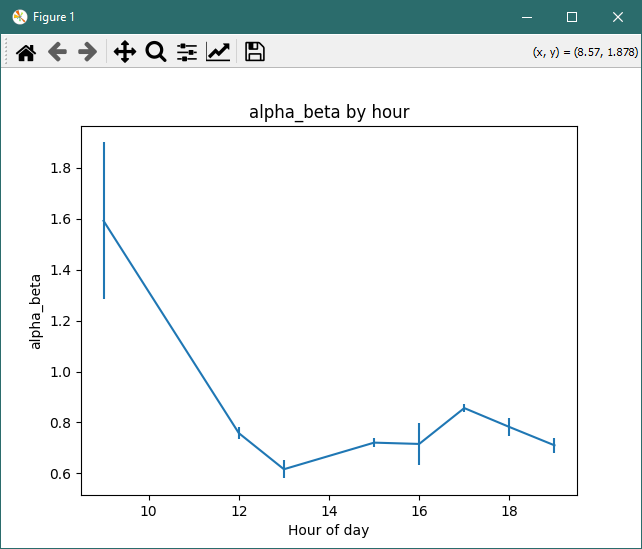

```
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: alpha_beta  
No. Observations: 101840  Method:             ML          
No. Groups:       494     Scale:              2.9224      
Min. group size:  1       Log-Likelihood:     -199762.8521
Max. group size:  1011    Converged:          Yes         
Mean group size:  206.2                                   
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    1.058     0.028  37.672  0.000   1.003   1.113
hour_sin     0.226     0.039   5.817  0.000   0.150   0.302
hour_cos     0.135     0.037   3.689  0.000   0.063   0.207
Group Var    0.292     0.016                               
==========================================================
```

In [ ]:
plt.close('all')

## Automatic Analyses

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns                 # pip install seaborn
sns.set_theme(style="whitegrid")

## INPUTS: df_feat

## 1. Simple scatter + LOWESS smoother
bands = ["theta", "alpha", "beta"]

fig, axes = plt.subplots(len(bands), 1, figsize=(8, 3 * len(bands)))

for ax, band in zip(axes, bands):
    sns.scatterplot(
        x="time_of_day", y=band,
        data=df_feat, s=10, alpha=.2, ax=ax)

    # LOWESS (locally-weighted regression) trend line
    sns.regplot(
        x="time_of_day", y=band,
        data=df_feat, scatter=False, lowess=True,
        line_kws={"color": "red", "lw": 2}, ax=ax
    )
    ax.set(title=f"{band} power vs. time of day",
           xlabel="Clock time (decimal hours)",
           ylabel="Relative power")
plt.tight_layout()


In [ ]:

## 2. Bin clock time and plot means ± SEM
## INPUTS: df_feat
# 1-hour bins: [0-1),[1-2),…, [23-24)
df_feat["hour_bin"] = pd.cut(df_feat.time_of_day,
                             bins=np.arange(0,25,1), right=False,
                             labels=np.arange(24))

for band in bands:
    tmp = df_feat.groupby("hour_bin")[band].agg(["mean", "sem"]).reset_index()
    plt.errorbar(tmp.hour_bin.astype(int), tmp["mean"],
                 yerr=tmp["sem"], marker="o", label=band)

plt.xticks(range(0,24,2))
plt.xlabel("Clock hour")
plt.ylabel("Relative power (mean ± SEM)")
plt.title("Hourly mean band power")
plt.legend()
plt.show()


In [ ]:
## 3. Visualise per-day trajectories
g = sns.relplot(
    data=df_feat, kind="line",
    x="time_of_day", y="alpha", hue="day",
    estimator=None, units="day",  # keep each day as its own line
    height=4, aspect=1.5)
g.set_axis_labels("Clock time (h)", "Alpha power")
g.figure.suptitle("Alpha trajectories per day", y=1.03)

In [ ]:
from statsmodels.tools import add_constant

for band in bands:
    mdf = models[band]                      # fitted MixedLMResults
    beta0, beta1 = mdf.fe_params            # intercept & slope

    # scatter of raw data
    sns.scatterplot(x="time_of_day", y=band,
                    data=df_feat, alpha=.15, s=10)

    # prediction line
    x = np.linspace(0,24,200)
    y = beta0 + beta1 * x
    plt.plot(x, y, color="red", lw=2,
             label=f"MixedLM slope = {beta1:.3f}")
    plt.title(f"{band} – fixed-effect fit")
    plt.legend()
    plt.show()
    
df_feat["phi"] = 2*np.pi*df_feat.time_of_day/24
plt.subplot(111, projection='polar')
plt.scatter(df_feat.phi, df_feat.alpha, s=3, alpha=.3)

# Jaw Clench EEG Processing

In [ ]:
hand_labeled_jaw_clinch_EEG = deepcopy(raw_eeg)
# hand_labeled_jaw_clinch_EEG.save(fname='hand_labeled_jaw_clinch_EEG_2025-08-20.fif')

In [ ]:
user_annotations = hand_labeled_jaw_clinch_EEG.annotations
max_duration_reject_event: float = np.nanmax(user_annotations.to_data_frame()['duration'])
max_duration_reject_event

In [ ]:
hand_labeled_jaw_clinch_EEG

In [ ]:
# annotate_flat 
from mne.epochs import Epochs
from mne.event import make_fixed_length_events


reject_criteria = dict(
    # mag=3000e-15,  # 3000 fT
    # grad=3000e-13,  # 3000 fT/cm
    eeg=1e-6,  # 100 µV
    # eog=200e-6,
)  # 200 µV

flat_criteria = dict(mag=1e-15, grad=1e-13, eeg=1e-6)  # 1 fT  # 1 fT/cm  # 1 µV

#create equally spaced events in raw data, with the duration > the longest bad data segment (here, that was 4 s)
events = make_fixed_length_events(hand_labeled_jaw_clinch_EEG, duration=(np.ceil(max_duration_reject_event)+1.0)) 

#convert the raw data to an epoch object using events and reject epochs where data is over a certain amplitude threshold (here, that was 0.6 mV or 6e-5 V)
reject = dict(eeg=1e-6)
epochs = Epochs(hand_labeled_jaw_clinch_EEG, events, reject=reject, preload=True)
epochs.plot_drop_log()
epochs


In [ ]:
# annotations, bad_chans = mne.preprocessing.annotate_amplitude(raw=hand_labeled_jaw_clinch_EEG, peak=reject_criteria, min_duration=0.3)
# annotations
annotations, bad_chans = mne.preprocessing.annotate_amplitude(hand_labeled_jaw_clinch_EEG, peak=100e-3, picks = 'eeg', bad_percent=5, min_duration=0.005)
annotations

hand_labeled_jaw_clinch_EEG.set_annotations((hand_labeled_jaw_clinch_EEG.annotations + annotations))
hand_labeled_jaw_clinch_EEG


## Reset 'hand_labeled_jaw_clinch_EEG'

In [ ]:
hand_labeled_jaw_clinch_EEG = deepcopy(raw_eeg)
hand_labeled_jaw_clinch_EEG.annotations

In [ ]:
import numpy as np
import mne

def detect_jaw_clench_annotations(raw, window_s=0.25, step_s=0.05, z_thresh=3.0, min_sync_channels=3, max_considered_channels=6, prob_thresh=0.5, merge_pad_s=0.1, picks="eeg", return_probs=False):
    """
    Compute sliding-window PTP per channel, z-score within-channel, and flag windows where >=min_sync_channels show high-amplitude transients.
    Creates MNE Annotations labeled 'JAW_CLENCH[p=...]' over merged windows with probability>prob_thresh.
    Args use seconds; thresholds are reasonable defaults for brief jaw-clench bursts.
    """
    sfreq = raw.info["sfreq"]
    w = max(1, int(round(window_s * sfreq)))
    s = max(1, int(round(step_s * sfreq)))
    pad = max(0, int(round(merge_pad_s * sfreq)))
    picks_idx = mne.pick_types(raw.info, eeg=True) if picks == "eeg" else mne.pick_channels(raw.ch_names, picks)
    if len(picks_idx) == 0:
        return mne.Annotations(onset=[], duration=[], description=[])
    data = raw.get_data(picks=picks_idx, reject_by_annotation="omit")
    n_ch, n_samp = data.shape
    if n_samp < w:
        return mne.Annotations(onset=[], duration=[], description=[])
    # Sliding windows (center-aligned)
    from numpy.lib.stride_tricks import sliding_window_view
    sw = sliding_window_view(data, w, axis=1)  # shape: (n_ch, n_win_full, w)
    win_idxs = np.arange(0, sw.shape[1] - 1, s)
    sw = sw[:, win_idxs, :]
    ptp = sw.max(axis=-1) - sw.min(axis=-1)  # (n_ch, n_win)
    # Z-score per channel across time (robust to heavy tails)
    ch_med = np.median(ptp, axis=1, keepdims=True)
    ch_mad = np.median(np.abs(ptp - ch_med), axis=1, keepdims=True)
    denom = np.maximum(ch_mad * 1.4826, 1e-12)
    z = (ptp - ch_med) / denom
    # Sync count per window and excess
    over = z > z_thresh
    k = over.sum(axis=0)  # number of channels exceeding threshold per window
    k_cap = np.minimum(k, min(max_considered_channels, n_ch))
    max_z = np.where(over, z, -np.inf).max(axis=0)
    max_z[np.isneginf(max_z)] = 0.0
    excess = np.clip(max_z - z_thresh, 0.0, None)
    # Probability mapping: combines sync count and excess amplitude, capped by 3–6 channels
    denom_k = float(min(max_considered_channels, n_ch))
    p = np.clip((k_cap / denom_k) * np.tanh(excess / 3.0), 0.0, 1.0)
    # Build intervals where p > prob_thresh, merge with padding
    centers = (win_idxs + w // 2).astype(int)
    mask = p > prob_thresh
    if not np.any(mask):
        return (mne.Annotations(onset=[], duration=[], description=[]), (centers / sfreq, p)) if return_probs else mne.Annotations(onset=[], duration=[], description=[])
    idx = np.flatnonzero(mask)
    groups = np.split(idx, np.where(np.diff(idx) > 1)[0] + 1)
    onsets = []
    durations = []
    descs = []
    for g in groups:
        start = centers[g[0]] - pad
        end = centers[g[-1]] + pad
        start = int(np.clip(start, 0, n_samp - 1))
        end = int(np.clip(end, start + 1, n_samp))
        seg_p = float(np.mean(p[g]))
        onsets.append(raw.first_time + start / sfreq)
        durations.append((end - start) / sfreq)
        descs.append(f"JAW_CLENCH[p={seg_p:.2f}]")
    # return (ann, (centers / sfreq, p)) if return_probs else ann
    ann = mne.Annotations(onset=onsets, duration=durations, description=descs, orig_time=raw.annotations.orig_time)
    return (ann, (centers / sfreq, p)) if return_probs else ann


# Example usage:
fn_bad_ann = detect_jaw_clench_annotations(hand_labeled_jaw_clinch_EEG)
hand_labeled_jaw_clinch_EEG.set_annotations(hand_labeled_jaw_clinch_EEG.annotations + fn_bad_ann)
hand_labeled_jaw_clinch_EEG

In [ ]:
from phoofflineeeganalysis.EegProcessing import annotate_jaw_clench


hand_labeled_jaw_clinch_EEG = annotate_jaw_clench(hand_labeled_jaw_clinch_EEG, window_size=1.5, thresh_scale=1, min_channels=3)
hand_labeled_jaw_clinch_EEG

In [ ]:
hand_labeled_jaw_clinch_EEG.plot()

In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from math import ceil, sqrt


def plot_channel_amplitude_histogram(
    raw,
    *,
    picks="eeg",
    bins=100,
    log_y=False,
    use_ptp=False,           # True → histogram of PTP values
    window_size=1.0,         # seconds, only used if use_ptp=True
    reject_by_annotation=True,
    units="auto",            # "auto" | "V" | "µV"
):
    """
    Plot one histogram per channel (sample amplitudes or PTP values).

    Parameters
    ----------
    raw : mne.io.BaseRaw
        Continuous EEG data.
    picks : str | list
        Which channels to include (default "eeg").
    bins : int or sequence
        Histogram bins passed to matplotlib/numpy.
    log_y : bool
        If True, use a log-scaled y-axis (helps when tails are long).
    use_ptp : bool
        False → histogram of every sample's amplitude  
        True  → histogram of sliding-window peak-to-peak values.
    window_size : float
        Length (s) of the PTP window if `use_ptp=True`.
    reject_by_annotation : bool
        Whether to drop segments already annotated as bad.
    units : str
        "V" for Volts, "µV" for microvolts, or "auto" (choose µV if values
        look <1e-2; otherwise V).
    """
    if not isinstance(raw, mne.io.BaseRaw):
        raise TypeError("`raw` must be an MNE Raw/RawArray object.")

    # ------------------------------------------------------------
    # Pick data
    # ------------------------------------------------------------
    if isinstance(picks, (list, tuple)):
        pick_idx = mne.pick_channels(raw.info["ch_names"], include=picks)
    else:
        pick_idx = mne.pick_types(raw.info, meg=False, eeg=True)

    ch_names = [raw.ch_names[i] for i in pick_idx]
    data = raw.get_data(picks=pick_idx,
                        reject_by_annotation="omit" if reject_by_annotation else None)

    sfreq = raw.info["sfreq"]

    # ------------------------------------------------------------
    # Choose units
    # ------------------------------------------------------------
    if units == "auto":
        # Heuristic: if median absolute amplitude < 1e-2 V, assume V units and
        # convert to µV for readability.
        med_abs = np.median(np.abs(data))
        if med_abs < 1e-2:
            units = "µV"
        else:
            units = "V"

    scale = 1.0 if units == "V" else 1e6   # convert to µV

    # ------------------------------------------------------------
    # Prepare the figure layout
    # ------------------------------------------------------------
    n_ch = len(ch_names)
    n_cols = ceil(sqrt(n_ch))
    n_rows = ceil(n_ch / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(3.2 * n_cols, 2.5 * n_rows), squeeze=False
    )

    # ------------------------------------------------------------
    # Build histograms channel-by-channel
    # ------------------------------------------------------------
    if use_ptp:
        win_samp = int(round(window_size * sfreq))
        for ax, ch_idx, name in zip(axes.flatten(), pick_idx, ch_names):
            sig = data[ch_names.index(name)]
            ptp_vals = sig[
                : len(sig) - win_samp + 1
            ].reshape(-1, win_samp).ptp(axis=1)
            ax.hist(ptp_vals * scale, bins=bins, color="steelblue")
            ax.set_title(name)
            ax.set_xlabel(f"PTP amplitude [{units}]")
            if log_y:
                ax.set_yscale("log")
    else:
        for ax, sig, name in zip(axes.flatten(), data, ch_names):
            ax.hist(sig * scale, bins=bins, color="steelblue")
            ax.set_title(name)
            ax.set_xlabel(f"Amplitude [{units}]")
            if log_y:
                ax.set_yscale("log")

    # Hide unused axes
    for ax in axes.flatten()[n_ch:]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()


###############################################################################
# Example usage
###############################################################################
# raw = mne.io.read_raw_fif("subject_raw.fif", preload=True)
#
# # 1) Quick look at sample-wise amplitudes
# plot_channel_amplitude_histogram(hand_labeled_jaw_clinch_EEG, bins=100, log_y=False)

plot_channel_amplitude_histogram(hand_labeled_jaw_clinch_EEG, bins=100, log_y=False, reject_by_annotation=False)



#
# # 2) Histogram of 1-second sliding PTP amplitudes (matches detector)
# plot_channel_amplitude_histogram(
#     hand_labeled_jaw_clinch_EEG,
#     use_ptp=True,
#     window_size=1.0,
#     bins=100,
#     log_y=True,
# )

In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from math import ceil, sqrt


def _build_sample_mask(raw, keep_desc=None, drop_bad=False):
    """
    Return a boolean vector (len = n_samples) marking samples to KEEP.

    keep_desc : list | None
        List of annotation descriptions to retain.  None → keep all.
    drop_bad : bool
        Additionally drop samples that fall in "BAD"-type annotations.
    """
    sfreq = raw.info["sfreq"]
    keep = np.zeros(len(raw.times), dtype=bool)

    for on, dur, desc in zip(
        raw.annotations.onset, raw.annotations.duration, raw.annotations.description
    ):
        start, stop = int(on * sfreq), int((on + dur) * sfreq)

        if drop_bad and desc.upper().startswith("BAD"):
            continue  # we *drop* these later

        if (keep_desc is None) or (desc in keep_desc):
            keep[start:stop] = True

    if drop_bad:
        # Now knock out "BAD" samples from whatever we decided to keep
        bad = np.zeros(len(raw.times), dtype=bool)
        for on, dur, desc in zip(
            raw.annotations.onset, raw.annotations.duration, raw.annotations.description
        ):
            if not desc.upper().startswith("BAD"):
                continue
            start, stop = int(on * sfreq), int((on + dur) * sfreq)
            bad[start:stop] = True
        keep &= ~bad

    return keep


def plot_channel_amplitude_histogram(
    raw,
    *,
    picks="eeg",
    bins=100,
    log_y=False,
    use_ptp=False,
    window_size=1.0,
    reject_by_annotation=True,
    units="auto",
    only_annotated=False,
    anno_descriptions=None,
):
    """
    Same interface as before but safe against boolean-index mismatches.
    """
    if only_annotated:
        keep_mask = _build_sample_mask(
            raw,
            keep_desc=anno_descriptions,
            drop_bad=reject_by_annotation,
        )
    elif reject_by_annotation:
        # keep everything except BAD segments
        keep_mask = _build_sample_mask(raw, keep_desc=None, drop_bad=True)
    else:
        keep_mask = slice(None)  # keep everything

    # -----------------------------------------------------------------
    # Pick and scale data
    # -----------------------------------------------------------------
    if isinstance(picks, (list, tuple)):
        pick_idx = mne.pick_channels(raw.info["ch_names"], include=picks)
    else:
        pick_idx = mne.pick_types(raw.info, meg=False, eeg=True)

    data = raw.get_data(picks=pick_idx, reject_by_annotation=None)[:, keep_mask]
    ch_names = [raw.ch_names[i] for i in pick_idx]
    sfreq = raw.info["sfreq"]

    # choose units
    if units == "auto":
        units = "µV" if np.median(np.abs(data)) < 1e-2 else "V"
    scale = 1.0 if units == "V" else 1e6

    # -----------------------------------------------------------------
    # Figure layout
    # -----------------------------------------------------------------
    n_ch = len(ch_names)
    n_cols = ceil(sqrt(n_ch))
    n_rows = ceil(n_ch / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(3.2 * n_cols, 2.5 * n_rows), squeeze=False
    )

    # -----------------------------------------------------------------
    # Plot
    # -----------------------------------------------------------------
    if use_ptp:
        win_samp = int(round(window_size * sfreq))
        for ax, sig, name in zip(axes.flatten(), data, ch_names):
            if len(sig) < win_samp:
                ax.axis("off")
                continue
            ptp_vals = sig[: len(sig) - win_samp + 1].reshape(-1, win_samp).ptp(axis=1)
            ax.hist(ptp_vals * scale, bins=bins, color="steelblue")
            ax.set_xlabel(f"PTP [{units}]")
            ax.set_title(name)
            if log_y:
                ax.set_yscale("log")
    else:
        for ax, sig, name in zip(axes.flatten(), data, ch_names):
            ax.hist(sig * scale, bins=bins, color="steelblue")
            ax.set_xlabel(f"Amp [{units}]")
            ax.set_title(name)
            if log_y:
                ax.set_yscale("log")

    # hide unused axes
    for ax in axes.flatten()[n_ch:]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()
    
# <Annotations | 86 segments: BAD_JAW (15), BAD_peak (71)>
plot_channel_amplitude_histogram(
    hand_labeled_jaw_clinch_EEG,
    use_ptp=False,
    only_annotated=True,          # keep only selected annotations
    anno_descriptions=["BAD_JAW"],
    reject_by_annotation=False,   # <-- keep BAD samples!
    bins=120,
    log_y=False,
)

# # Histogram ONLY for samples labelled "jaw_clench", using 1-s PTP feature
# plot_channel_amplitude_histogram(
#     hand_labeled_jaw_clinch_EEG,
#     use_ptp=False,
#     window_size=1.0,
#     only_annotated=False,
#     anno_descriptions=["BAD_JAW"],  # None → keep any annotation label
#     bins=120,
#     log_y=False,
# )

In [ ]:
plot_channel_amplitude_histogram(
    hand_labeled_jaw_clinch_EEG,
    use_ptp=False,
    only_annotated=False,          # keep only selected annotations
    anno_descriptions=["BAD_JAW"],
    reject_by_annotation=False,   # <-- keep BAD samples!
    bins=120,
    log_y=False,
)


In [ ]:
raw_eeg = deepcopy(hand_labeled_jaw_clinch_EEG)

# Apply band-pass filter (1-35Hz) and re-reference the raw signal
eeg = raw_eeg.copy().filter(1, 35, verbose=False)
eeg = nk.eeg_rereference(eeg, "average")

nk.signal_plot(
    [raw_eeg.get_data()[0, 0:500], eeg.get_data()[0, 0:500]],
    labels=["Raw", "Preprocessed"],
    sampling_rate=eeg.info["sfreq"],
)



In [ ]:
reject_criteria = dict(
    mag=3000e-15,  # 3000 fT
    grad=3000e-13,  # 3000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=200e-6,
)  # 200 µV

flat_criteria = dict(mag=1e-15, grad=1e-13, eeg=1e-6)  # 1 fT  # 1 fT/cm  # 1 µV
epochs = mne.Epochs(
    raw_eeg,
    None,
    tmin=-0.2,
    tmax=0.5,
    reject_tmax=0,
    reject=reject_criteria,
    flat=flat_criteria,
    reject_by_annotation=False,
    preload=True,
)
epochs.plot_drop_log()

In [ ]:

## Try EOG -- fials due to lack of digitization points -- # RuntimeError: No digitization points found.
eog_epochs = mne.preprocessing.create_eog_epochs(raw_eeg, ch_name=['AF3', 'AF4'], baseline=(-0.5, -0.2)) ## use the EEG channels closest to the eyes
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

# The following electrodes have overlapping positions, which causes problems during visualization: T7, T8

In [ ]:
df.min(), df.max()


In [ ]:
from mne.channels.montage import DigMontage
from phoofflineeeganalysis.analysis.anatomy_and_electrodes import ElectrodeHelper

electrode_pos_parent_folder: Path = Path("E:/Dropbox (Personal)/Hardware/Consumer EEG Headsets/Emotiv Epoc EEG/ElectrodeLayouts").resolve()
electrode_positions_path: Path = electrode_pos_parent_folder.joinpath('ElectrodePositions_2025-08-14', 'brainstorm_electrode_positions_PhoHAle_eeg_subjectspacemm.tsv')

active_electrode_man: ElectrodeHelper = ElectrodeHelper.init_EpocX_montage(electrode_positions_path=electrode_positions_path)
emotiv_epocX_montage: DigMontage = active_electrode_man.active_montage

# Just create montage from your electrode positions
print("Montage created successfully!")
print(f"Channel names: {emotiv_epocX_montage.ch_names}")
# Visualize the montage
# ElectrodeHelper.visualize_montage(emotiv_epocX_montage)


## Single Calibration Motion recording to determine Quaternions:


In [ ]:
from phoofflineeeganalysis.analysis.historical_data import HistoricalData


reference_EmotivEpocX_Headset_motion_file = Path(r"E:\Dropbox (Personal)\Databases\UnparsedData\EmotivEpocX_EEGRecordings\MOTION_RECORDINGS\fif\20250812-061030-Epoc X Motion-raw.fif").resolve()
assert reference_EmotivEpocX_Headset_motion_file.exists()

constrain_channels = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']

# adds the quaternion channels: ['qw', 'qx', 'qy', 'qz'] to the dataframe

raw = read_raw(reference_EmotivEpocX_Headset_motion_file, preload=False)
metadata_recording_start_datetime = raw.info.get('meas_date', None)
if metadata_recording_start_datetime is None:
    parsed_recording_start_datetime = HistoricalData.extract_datetime_from_filename(reference_EmotivEpocX_Headset_motion_file.name)
    metadata_recording_start_datetime = parsed_recording_start_datetime
    if True:                
        # Make timezone-aware (UTC)
        # dt = dt.rerawe(tzinfo=timezone.utc)
        raw.info.set_meas_date(deepcopy(parsed_recording_start_datetime).replace(tzinfo=timezone.utc))
        ## WAS UPDATED, probably need to re-save or something
        meas_datetime = raw.info['meas_date']
    else:
        ## don't set it, but still use the parsed datetime
        meas_datetime = deepcopy(parsed_recording_start_datetime).replace(tzinfo=timezone.utc) # raw.info['meas_date']  # This is an absolute datetime or tuple (timestamp, 0)

else:                    
    meas_datetime = raw.info['meas_date']  # This is an absolute datetime or tuple (timestamp, 0)


raw_df: pd.DataFrame = raw.to_data_frame(picks=constrain_channels)
data, times = raw.get_data(picks=constrain_channels, return_times=True)

# Convert relative times to absolute timestamps (in seconds since epoch)
start_time = meas_datetime.timestamp() if hasattr(meas_datetime, 'timestamp') else meas_datetime[0]
abs_times = start_time + times

raw_df['timestamp'] = abs_times
raw_df['timestamp_dt'] = pd.to_datetime(raw_df['timestamp'], unit='s') ## add datetime column
# Sort by column: 'timestamp_dt' (ascending)
raw_df = raw_df.sort_values(['timestamp_dt'], na_position='first').reset_index(drop=True)

## Estimate Quaternions from motion data:
raw_df = MotionData.compute_quaternions(raw_df)
raw_df

# raw_df.to_csv('reference_pos_df_concatenated.csv', index=False)
raw_df

In [ ]:

raw.plot(duration=raw.times[-1], n_channels=len(raw.ch_names))


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from phoofflineeeganalysis.analysis.motion_data import MotionData

# Usage:
MotionData.plot_3d_orientation(raw_df, step=20)


In [ ]:
raw_df.head().to_clipboard()

In [ ]:
raw.plot()

In [ ]:
# data.info['meas_date']
# data.get_parsed_recording_start_datetime
# data.annotations
# data

In [ ]:
## Files in `WhisperVideoTranscripts_LSL_Converted` are transcripts generated by the `whisper-timestamped` repo's `transcript_to_lsl.py`, which translates spoken diction notes into LSL text events. 
# # Example filenames include:
# "E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted/Debut_2025-08-07T095548.words.lsl.fif",
# "E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted/Debut_2025-08-06T185509.words.lsl.fif",
# "E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted/Debut_2025-08-06T153648.words.lsl.fif",
# "E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted/Debut_2025-08-06T151856.words.lsl.fif",
# "E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted/Debut_2025-08-07T185504.words.lsl.fif",
# "E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted/Debut_2025-08-07T150021.words.lsl.fif",

WhisperVideoTranscripts_LSL_Converted = Path(r"E:/Dropbox (Personal)/Databases/UnparsedData/WhisperVideoTranscripts_LSL_Converted").resolve()




In [ ]:
eeg_recordings_file_path

# EEG Sonification

In [ ]:
import sounddevice as sd

def play_sine(frequency, duration=1, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    sine_wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    sd.play(sine_wave, sample_rate)
    sd.wait()  # Wait until playback is finished

# Example: Play a 440 Hz tone for 2 seconds
play_sine(440, duration=2)



In [ ]:
import time
from pysinewave import SineWave

sinewave = SineWave(pitch=12, pitch_per_second=10)
sinewave.play()
time.sleep(2)
sinewave.set_pitch(-5)
time.sleep(3)


In [ ]:
sinewave.stop()

# 2025-09-18 - LabRecorder XDF Imports

In [5]:
from phoofflineeeganalysis.analysis.EEG_data import EEGData
from phoofflineeeganalysis.analysis.MNE_helpers import DatasetDatetimeBoundsRenderingMixin, RawArrayExtended, RawExtended, up_convert_raw_objects, up_convert_raw_obj
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import LabRecorderXDF, unwrap_single_element_listlike_if_needed


lab_recorder_output_path = Path(r"E:\Dropbox (Personal)\Databases\UnparsedData\LabRecorderStudies\sub-P001").resolve()
assert lab_recorder_output_path.exists()

labRecorder_PostProcessed_path: Path = sso.eeg_analyzed_parent_export_path.joinpath(f'LabRecorder_PostProcessed')
labRecorder_PostProcessed_path.mkdir(exist_ok=True)

should_write_final_merged_eeg_fif: bool = True
# should_write_final_merged_eeg_fif: bool = False
_out_eeg_raw, _out_xdf_stream_infos_df, lab_recorder_xdf_files = LabRecorderXDF.load_and_process_all(lab_recorder_output_path=lab_recorder_output_path, 
                                                                                                     labRecorder_PostProcessed_path=labRecorder_PostProcessed_path, should_write_final_merged_eeg_fif=should_write_final_merged_eeg_fif)
xdf_dataset_indicies = np.unique(deepcopy(_out_xdf_stream_infos_df).reset_index(drop=False, inplace=False)['xdf_dataset_idx'].to_numpy())
n_unique_xdf_datasets: int = len(xdf_dataset_indicies)
print(f'n_unique_xdf_datasets: {n_unique_xdf_datasets}')


trying to process XDF file 0/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-10T140840.440Z_eeg.xdf"...
	 failed with error: 1
	skipping file.
trying to process XDF file 1/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-10T153731.079Z_eeg.xdf"...


Stream 3: Calculated effective sampling rate 32.0162 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-10T15-37-31.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-10T15-37-31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 2/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-10T165236.402Z_eeg.xdf"...


Stream 3: Calculated effective sampling rate 31.8602 Hz is different from specified rate 16.0000 Hz.
Stream 2: Calculated effective sampling rate 19.5947 Hz is different from specified rate 16.0000 Hz.


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 3/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-11T014154.084Z_eeg.xdf"...


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-11T01-41-54.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-11T01-41-54.fif"
trying to process XDF file 4/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-11T101328.256Z_eeg.xdf"...


Stream 2: Calculated effective sampling rate 32.0174 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 3460 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-11T10-13-28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-11T10-13-28.fif"
trying to process XDF file 5/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-11T154549.460Z_eeg.xdf"...


Stream 1: Calculated effective sampling rate 32.0164 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 2253 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-11T15-45-49.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-11T15-45-49.fif"
trying to process XDF file 6/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-12T220903.464Z_eeg.xdf"...


Stream 2: Calculated effective sampling rate 31.9792 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 5710 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-12T22-09-03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-12T22-09-03.fif"
trying to process XDF file 7/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-18T031842.989Z_eeg.xdf"...


Stream 4: Calculated effective sampling rate 32.0071 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 4458 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-18T03-18-42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-18T03-18-42.fif"
trying to process XDF file 8/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-18T121337.267Z_eeg.xdf"...


Stream 4: Calculated effective sampling rate 31.9960 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 425 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-18T12-13-37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-18T12-13-37.fif"
trying to process XDF file 9/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-18T122106.448Z_eeg.xdf"...


Stream 4: Calculated effective sampling rate 32.0161 Hz is different from specified rate 16.0000 Hz.
Stream 3: Calculated effective sampling rate 31.9752 Hz is different from specified rate 16.0000 Hz.


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 10/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_2025-09-18T151803.959Z_eeg.xdf"...
	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 11/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-12T215537.892Z.xdf"...


Stream 1: Calculated effective sampling rate 30.8338 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 526 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-12T21-55-37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-12T21-55-37.fif"


Stream 3: Calculated effective sampling rate 31.7614 Hz is different from specified rate 16.0000 Hz.


trying to process XDF file 12/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-18T151839.043Z_eeg.xdf"...


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 517 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-18T15-18-39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-18T15-18-39.fif"
trying to process XDF file 13/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-18T152308.395Z_eeg.xdf"...


Stream 4: Calculated effective sampling rate 32.0176 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 2793 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-18T15-23-08.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-18T15-23-08.fif"


Stream 1: Calculated effective sampling rate 31.9888 Hz is different from specified rate 16.0000 Hz.


trying to process XDF file 14/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-18T200937.798Z_eeg.xdf"...
	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 15/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-18T201023.120Z_eeg.xdf"...


Stream 1: Calculated effective sampling rate 31.9310 Hz is different from specified rate 16.0000 Hz.


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 16/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-19T051346.012Z_eeg.xdf"...


Stream 4: Calculated effective sampling rate 31.9233 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 3471 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-19T05-13-46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-19T05-13-46.fif"
trying to process XDF file 17/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-19T115508.257Z_eeg.xdf"...


Stream 1: Calculated effective sampling rate 32.0176 Hz is different from specified rate 16.0000 Hz.


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 18/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-19T205118.364Z_eeg.xdf"...


Stream 1: Calculated effective sampling rate 32.0176 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 9106 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-19T20-51-18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-19T20-51-18.fif"
trying to process XDF file 19/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-20T214749.964Z_eeg.xdf"...


Stream 2: Calculated effective sampling rate 31.9167 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 14289 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-20T21-47-49.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-20T21-47-49.fif"


Stream 4: Calculated effective sampling rate 32.0013 Hz is different from specified rate 16.0000 Hz.
Stream 4: Calculated effective sampling rate 31.9913 Hz is different from specified rate 16.0000 Hz.


trying to process XDF file 20/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-21T002232.699Z_eeg.xdf"...
	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 21/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-21T002343.561Z_eeg.xdf"...
	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 22/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-21T002525.578Z_eeg.xdf"...


Stream 3: Calculated effective sampling rate 31.8133 Hz is different from specified rate 16.0000 Hz.


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 23/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-21T003051.428Z_eeg.xdf"...


Stream 3: Calculated effective sampling rate 32.0174 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 6518 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-21T00-30-51.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-21T00-30-51.fif"
trying to process XDF file 24/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-21T085541.696Z_eeg.xdf"...


Stream 3: Calculated effective sampling rate 32.0144 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 2954 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-21T08-55-41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-21T08-55-41.fif"
trying to process XDF file 25/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-22T182649.051Z_eeg.xdf"...


Stream 4: Calculated effective sampling rate 32.0182 Hz is different from specified rate 16.0000 Hz.


	 failed with error: 1
	skipping file.
trying to process XDF file 26/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-22T213547.659Z_eeg.xdf"...


Stream 3: Calculated effective sampling rate 31.9901 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 6125 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-22T21-35-47.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-22T21-35-47.fif"
trying to process XDF file 27/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_Apogee_2025-09-23T141026.412Z_eeg.xdf"...


Stream 1: Calculated effective sampling rate 30.5949 Hz is different from specified rate 16.0000 Hz.
Stream 3: Calculated effective sampling rate 31.9945 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-11T21-36-35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 28/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-11T213635.043Z.xdf"...
saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-11T21-36-35.fif"
trying to process XDF file 29/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-12T014018.162Z.xdf"...


Stream 2: Calculated effective sampling rate 32.0028 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-12T01-40-18.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-12T01-40-18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 30/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-13T021042.451Z.xdf"...


Stream 1: Calculated effective sampling rate 30.1544 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-13T02-10-42.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-13T02-10-42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 31/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-13T031209.598Z.xdf"...


Stream 3: Calculated effective sampling rate 30.2498 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-13T03-12-09.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-13T03-12-09.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 32/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-19T001746.449Z.xdf"...


Stream 3: Calculated effective sampling rate 30.9507 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-19T00-17-46.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-19T00-17-46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 33/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-19T012938.518Z.xdf"...


Stream 1: Calculated effective sampling rate 31.8991 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-19T01-29-38.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-19T01-29-38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 34/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-19T015439.979Z.xdf"...


Stream 1: Calculated effective sampling rate 32.0117 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 864 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-19T01-54-39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-19T01-54-39.fif"
trying to process XDF file 35/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-19T022210.910Z.xdf"...


Stream 1: Calculated effective sampling rate 32.0168 Hz is different from specified rate 16.0000 Hz.
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\MNE_helpers.py:281: RuntimeWarning: Omitted 1563 annotation(s) that were outside data range.
  raw.set_annotations(existing_annotations + new_annots)
C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-19T02-22-10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-19T02-22-10.fif"
trying to process XDF file 36/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBPPinkDot_2025-09-20T023803.932Z.xdf"...


Stream 2: Calculated effective sampling rate 27.5594 Hz is different from specified rate 16.0000 Hz.


saving finalized EEG data out to "E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/LabRecorder_PostProcessed/2025-09-20T02-38-03.fif"


C:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\src\phoofflineeeganalysis\analysis\SavedSessionsProcessor.py:981: RuntimeWarning: This filename (E:\Dropbox (Personal)\Databases\AnalysisData\MNE_preprocessed\LabRecorder_PostProcessed\2025-09-20T02-38-03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(a_lab_recorder_filepath, overwrite=True)


trying to process XDF file 37/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBP_2025-09-11T203807.731Z.xdf"...


Stream 3: Calculated effective sampling rate 32.0160 Hz is different from specified rate 16.0000 Hz.


	 failed with error: not enough values to unpack (expected 2, got 1)
	skipping file.
trying to process XDF file 38/39: "E:/Dropbox (Personal)/Databases/UnparsedData/LabRecorderStudies/sub-P001/LabRecorder_rMBP_2025-09-11T210420.828Z.xdf"...


Stream 4: Calculated effective sampling rate 32.0167 Hz is different from specified rate 16.0000 Hz.
Stream 5: Calculated effective sampling rate 32.0166 Hz is different from specified rate 16.0000 Hz.


	 failed with error: orig_time should be the same to add/concatenate 2 annotations (got 2025-09-11 21:04:20+00:00 != None)
	skipping file.
n_unique_xdf_datasets: 25


In [17]:
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import XDFDataStreamAccessor


_out_xdf_stream_infos_df: pd.DataFrame = XDFDataStreamAccessor.init_from_results(_out_xdf_stream_infos_df=_out_xdf_stream_infos_df, active_only_out_eeg_raws=_out_eeg_raw) # [_out_xdf_stream_infos_df['name'] == 'Epoc X']
_out_xdf_stream_infos_df

,name,fs,n_samples,n_channels,stream_id,effective_srate,hostname,source_id,channel_format,type,...,recording_day_date,duration_sec,created_at_dt,created_at_rel,first_timestamp_dt,first_timestamp_rel,last_timestamp_dt,last_timestamp_rel,duration_sec_check,duration_rel
xdf_dataset_idx,,,,,,,,,,,,,,,,,,,,,
0,Epoc X eQuality,128.0,333030,14,1,128.373095,EmotivVMApogee,Emotiv Epoc X_8_36353636353635363636373536353537,float32,Raw,...,2025-09-10 00:00:00+00:00,0 days 00:43:21.796875,2025-09-10 17:15:45.777074+00:00,0.068227,2025-09-10 17:19:57.910380800+00:00,0.071145,2025-09-10 18:03:12.432241900+00:00,0.101174,0 days 00:43:14.521861100,0.030029
0,Epoc X,128.0,333028,14,2,128.373095,EmotivVMApogee,Emotiv Epoc X_8_36353636353635363636373536353537,float32,EEG,...,2025-09-10 00:00:00+00:00,0 days 00:43:21.781250,2025-09-10 17:15:45.788452800+00:00,0.068227,2025-09-10 17:19:57.927472+00:00,0.071145,2025-09-10 18:03:12.432253800+00:00,0.101174,0 days 00:43:14.504781800,0.030029
0,Epoc X Motion,16.0,83063,6,3,32.016169,EmotivVMApogee,Emotiv Epoc X_8_36353636353635363636373536353537,float32,SIGNAL,...,2025-09-10 00:00:00+00:00,0 days 01:26:31.437500,2025-09-10 17:15:45.798384700+00:00,0.068227,2025-09-10 17:19:57.951104100+00:00,0.071145,2025-09-10 18:03:12.449342+00:00,0.101174,0 days 00:43:14.498237900,0.030029
1,Epoc X Motion,16.0,5440,6,2,19.594720,rMBP-16-2023.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,SIGNAL,...,2025-09-11 00:00:00+00:00,0 days 00:05:40,2025-09-16 13:15:16.039368664+00:00,5.481505,NaT,NaN,NaT,NaN,NaT,NaN
1,Epoc X eQuality,128.0,21800,14,3,126.501594,rMBP-16-2023.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,Raw,...,2025-09-11 00:00:00+00:00,0 days 00:02:50.312500,2025-09-16 13:15:16.016466427+00:00,5.481505,NaT,NaN,NaT,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,Epoc X,128.0,236038,14,3,128.400104,rMBP-PinkDot.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,EEG,...,2025-09-21 00:00:00+00:00,0 days 00:30:44.046875,2025-09-21 10:13:58.309235326+00:00,0.054367,2025-09-21 11:08:05.824650232+00:00,0.091954,2025-09-21 11:38:44.332823942+00:00,0.113233,0 days 00:30:38.508173710,0.021279
23,TextLogger,0.0,5,1,2,0.000000,Apogee,textlogger_001,string,Markers,...,2025-09-21 00:00:00+00:00,NaT,2025-09-21 10:43:17.263254200+00:00,0.074725,2025-09-21 11:14:23.115459500+00:00,0.096321,2025-09-21 11:41:36.181905700+00:00,0.115222,0 days 00:27:13.066446200,0.018901
24,Epoc X Motion,16.0,38219,6,2,27.559387,rMBP-PinkDot.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,SIGNAL,...,2025-09-22 00:00:00+00:00,0 days 00:39:48.687500,2025-09-24 00:02:47.827532591+00:00,1.102093,2025-09-24 00:04:04.804846451+00:00,1.102984,2025-09-24 00:26:40.282300291+00:00,1.118672,0 days 00:22:35.477453840,0.015688


In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster, SynchronizedPlotMode

In [ ]:
_out_xdf_stream_infos_df

In [ ]:
len(_out_xdf_stream_infos_df)
_out_xdf_stream_infos_df.loc[0]

In [ ]:
_out_eeg_raw

# Run Batch Computations on `_out_eeg_raw`

In [ ]:
num_sessions: int = len(_out_eeg_raw)
num_sessions


results_dict = {}

for an_xdf_dataset_idx in np.arange(num_sessions):
    a_raw = deepcopy(_out_eeg_raw[an_xdf_dataset_idx])
    a_raw.down_convert_to_base_type()
    results_dict[an_xdf_dataset_idx] 

## Common Setup

In [ ]:
a_raw = deepcopy(_out_eeg_raw[-3])
a_raw.down_convert_to_base_type()

In [ ]:
## INPUT: fixed_len_epochs
freqs = np.arange(5., 40., 1.0)
# Define frequencies and number of cycles
# freqs = np.logspace(*np.log10([2, 40]), num=20)
n_cycles = freqs / 2.0 # A common approach is to use a fixed number of cycles or a value that increases with frequency.

freqs
n_cycles

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability


### Fixed Length Epoch-based:

In [ ]:
from phoofflineeeganalysis.analysis.MNE_helpers import RawExtended, RawArrayExtended

## INPUT: a_raw
fixed_len_epochs = mne.make_fixed_length_epochs(a_raw, duration=8, preload=True, reject_by_annotation=False)
fixed_len_epochs
	

In [ ]:
## INPUT: fixed_len_epochs
freqs = np.arange(5., 40., 1.0)

# Define frequencies and number of cycles
# freqs = np.logspace(*np.log10([2, 40]), num=20)
n_cycles = freqs / 2.0 # A common approach is to use a fixed number of cycles or a value that increases with frequency.

# n_cycles = np.linspace(3,10,len(freqs))


In [ ]:


# Compute time-frequency power using Morlet wavelets -- NO EPOCHS, RAW DATA
# power = a_raw.compute_tfr(method="morlet",
power = mne.time_frequency.tfr_morlet(
    fixed_len_epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    return_itc=False,
    average=False, # Compute TFR on continuous data without averaging
    # average=True, # Compute TFR on continuous data without averaging
    decim=3, # Decimate the output for faster computation and smaller file size
    n_jobs=-1 # Use 1 core for this example
)
power

In [ ]:
## Array version:
from mne.time_frequency import tfr_array_morlet

# get raw data (channels × time)
data = fixed_len_epochs.get_data() # shape: (n_epochs, n_channels, n_times)
print(f'np.shape(data): {np.shape(data)}')
# run morlet on continuous data
power: NDArray = tfr_array_morlet(
    data=data,
    sfreq=fixed_len_epochs.info['sfreq'],
    freqs=freqs,
    n_cycles=n_cycles,
    output='power',
    decim=3,
    n_jobs=-1
)

# power shape: (n_epochs=1, n_channels, n_freqs, n_times)
power = np.squeeze(power) ## remove epoch
print(f'np.shape(power): {np.shape(power)}')

# np.shape(data): (593, 14, 1024)
# np.shape(power): (593, 14, 20, 342)

In [ ]:
import h5py

repo_data_folder_path = Path(r"C:\Users\pho\repos\EmotivEpoc\PhoLabStreamingReceiver\data").resolve()

h5_file_path = repo_data_folder_path.joinpath(f'2025-09-21_exported_sess.h5').resolve()

print(f'writing to "{h5_file_path.as_posix()}"')

# raw_data = a_raw.get_data() # (14, 607857)
# np.shape(raw_data)


In [ ]:
with h5py.File(h5_file_path, "w") as f:
    
    d0 = f.create_dataset("raw", data=raw_data)
    d0.attrs["dim_labels"] = ["channels", "time"]

    d1 = f.create_dataset("epoched", data=data)
    d1.attrs["dim_labels"] = ["epochs", "channels", "time"]

    d2 = f.create_dataset("power", data=power)
    d2.attrs["dim_labels"] = ["epochs", "channels", "time", "frequency"]


print(f'done! wrote to "{h5_file_path.as_uri()}"')

In [ ]:
n_epochs, n_channels, n_freqs, n_t_steps = np.shape(power)

ch_idx: int = 0
single_channel_power_data: NDArray = np.squeeze(power[:, ch_idx, :, :]) # (n_epochs, n_freqs, n_t_steps)


# epoch_idx: int = 1
# single_channel_power_data: NDArray = np.squeeze(power[epoch_idx, ch_idx, :, :]) # (n_epochs, n_freqs, n_t_steps)

# n_epochs, n_freqs, n_t_steps = np.shape(single_channel_power_data)

np.shape(single_channel_power_data) # (n_epochs, n_freqs, n_t_steps)


In [ ]:
## time subset
active_epoch_idx: int = 1
# single_channel_single_time_range_power_data = single_channel_power_data[:, start_t:(start_t + active_n_t_steps)]
# n_freqs, active_n_t_steps = np.shape(single_channel_single_time_range_power_data)
# print(f'active_n_t_steps: {active_n_t_steps}')

single_channel_single_epoch_power_data = single_channel_power_data[active_epoch_idx, :, :]
n_freqs, active_n_t_steps = np.shape(single_channel_single_epoch_power_data)
print(f'single_channel_single_epoch_power_data: {np.shape(single_channel_single_epoch_power_data)}')

n_freqs
active_n_t_steps

In [ ]:
single_channel_single_epoch_power_data

np.ptp(single_channel_single_epoch_power_data)

np.nanmin(single_channel_single_epoch_power_data), np.nanmax(single_channel_single_epoch_power_data)

# import numpy as np
# import matplotlib.pyplot as plt

# data = np.random.randn(10000) * 2
# data[::1000] = 1000  # inject outliers

arr = deepcopy(single_channel_single_epoch_power_data)

vmin, vmax = np.percentile(arr, [1, 99])  # clip extremes
plt.hist(np.clip(arr, vmin, vmax), bins=100)
plt.show()



In [ ]:
import napari
# Example 4D array: (time, z, y, x)

viewer = napari.Viewer()
# viewer.add_image(raw_data, name='raw_data', channel_axis=None)  # no channel axis
# viewer.add_image(data, name='epoched', channel_axis=None)  # no channel axis
# viewer.add_image(power, name='power', channel_axis=None)  # no channel axis

viewer.add_image(single_channel_single_epoch_power_data, name='single_channel_single_epoch_power_data', channel_axis=None)  # no channel axis

napari.run()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharey=True, layout="constrained", num='Continuous Wavelet: single_channel_single_time_range_power_data')
# ax.imshow(single_channel_single_epoch_power_data, cmap='viridis')
# ax.matshow(single_channel_single_epoch_power_data, vmin=0, vmax=1, cmap='viridis')
# min_max_kwargs = dict(vmin=np.nanmin(single_channel_single_epoch_power_data), vmax=np.nanmax(single_channel_single_epoch_power_data))
min_max_kwargs = dict(vmin=np.nanmin(single_channel_single_epoch_power_data), vmax=3.0)

ax.matshow(single_channel_single_epoch_power_data, **min_max_kwargs, cmap='viridis')
fig.show()

In [ ]:
import pyqtgraph as pg

app = pg.mkQApp('WaveletPlotter- Epochs Based')
win = pg.GraphicsLayoutWidget()
plot = win.addPlot()
plot.showGrid(x=True, y=True)

# disable vertical panning/zooming
plot.setMouseEnabled(x=True, y=False)

# apply viridis colormap
cmap = pg.colormap.get('viridis')
img = pg.ImageItem(single_channel_single_epoch_power_data.T)
img.setLookupTable(cmap.getLookupTable(0.0, 1.0, 256))

plot.addItem(img)

# auto-range to image
plot.setAspectLocked(False)
plot.getViewBox().autoRange()

# fix y-range to image bounds
y_min, y_max = 0, data.shape[0]
plot.setYRange(y_min, y_max, padding=0)
plot.vb.setLimits(yMin=y_min, yMax=y_max)

win.show()


In [ ]:
pg.image(single_channel_single_epoch_power_data.T)

In [ ]:
pg.image(single_channel_power_data.T)

### Raw (NO EPOCHS, RAW DATA)

In [ ]:
# from mne.time_frequency import psd_welch
from mne.time_frequency import psd_array_welch, psd_array_multitaper, Spectrum
## INPUT: a_raw

# define conventional EEG bands
bands = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30,40)}


In [ ]:
from mne.time_frequency import psd_array_welch
import numpy as np

raw_data = a_raw.get_data()  # (n_channels, n_times)
sfreq = a_raw.info['sfreq']

# Welch PSD
psds, freqs = psd_array_welch(raw_data, sfreq=sfreq, fmin=1, fmax=40,
                              n_fft=2048, n_overlap=1024, n_per_seg=2048, verbose=True)

# Conventional EEG bands
bands = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30,40)}
band_power = {b: psds[:, (freqs>=fmin)&(freqs<fmax)].mean(axis=1) for b,(fmin,fmax) in bands.items()}

# band_power[b] is (n_channels,) array

band_power

In [ ]:
# compute PSD for all channels (continuous)
psds, freqs = psd_welch(a_raw, fmin=1, fmax=40, n_fft=2048, n_overlap=1024, n_per_seg=2048, average='mean')

# compute average band power
band_power = {b: psds[:, (freqs>=fmin)&(freqs<fmax)].mean(axis=1) for b,(fmin,fmax) in bands.items()}

## OUTPUTS: band_power


In [ ]:
# a_spectrum: Spectrum = a_raw.compute_psd(method="welch", fmin=1, fmax=40) # , picks="eeg", tmin=10, tmax=200
a_spectrum: Spectrum  = a_raw.compute_psd(method='welch', fmin=1, fmax=40, n_fft=2048, n_overlap=1024, n_per_seg=2048, average='mean')
psds = a_spectrum.get_data()  # shape: (n_channels, n_freqs)
freqs = a_spectrum.freqs


In [ ]:

band_power = {b: psds[:, (freqs>=fmin)&(freqs<fmax)].mean(axis=1) for b,(fmin,fmax) in bands.items()}



In [ ]:
from phoofflineeeganalysis.analysis.MNE_helpers import RawExtended, RawArrayExtended

## INPUT: a_raw
print("Pre-computing all CWTs... (this may take a moment)")

# Compute time-frequency power using Morlet wavelets -- NO EPOCHS, RAW DATA
# power = a_raw.compute_tfr(method="morlet",
power = mne.time_frequency.tfr_morlet(
    a_raw,
    freqs=freqs,
    n_cycles=n_cycles,
    return_itc=False,
    # average=False, # Compute TFR on continuous data without averaging
    # average=True, # Compute TFR on continuous data without averaging
    decim=3, # Decimate the output for faster computation and smaller file size
    n_jobs=-1 # Use 1 core for this example
)
power

In [ ]:
from mne.time_frequency import tfr_array_morlet

# get raw data (channels × time)
data = a_raw.get_data()[np.newaxis, ...]  # shape: (n_epochs=1, n_channels, n_times)

# run morlet on continuous data
power: NDArray = tfr_array_morlet(
    data=data,
    sfreq=a_raw.info['sfreq'],
    freqs=freqs,
    n_cycles=n_cycles,
    output='power',
    decim=3,
    n_jobs=-1
)

# power shape: (n_epochs=1, n_channels, n_freqs, n_times)
power = np.squeeze(power) ## remove epoch
print(f'np.shape(power): {np.shape(power)}')

In [ ]:
n_channels, n_freqs, n_t_steps = np.shape(power)

ch_idx: int = 0
single_channel_power_data: NDArray = np.squeeze(power[ch_idx, :, :]) # (n_freqs, n_t_steps)

# n_freqs, n_t_steps = np.shape(single_channel_power_data)

np.shape(single_channel_power_data) # (n_freqs, n_t_steps)


In [ ]:
## time subset
active_n_t_steps: int = 1000
start_t = 2000
single_channel_single_time_range_power_data = single_channel_power_data[:, start_t:(start_t + active_n_t_steps)]

n_freqs, active_n_t_steps = np.shape(single_channel_single_time_range_power_data)

print(f'active_n_t_steps: {active_n_t_steps}')
n_t_steps

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharey=True, layout="constrained", num='Continuous Wavelet: single_channel_single_time_range_power_data')
ax.imshow(single_channel_single_time_range_power_data)
fig.show()

In [ ]:
import pyqtgraph as pg

app = pg.mkQApp('WaveletPlotter')
win = pg.GraphicsLayoutWidget()
plot = win.addPlot()
plot.showGrid(x=True, y=True)

# disable vertical panning/zooming
plot.setMouseEnabled(x=True, y=False)

# apply viridis colormap
cmap = pg.colormap.get('viridis')
img = pg.ImageItem(single_channel_power_data.T)
img.setLookupTable(cmap.getLookupTable(0.0, 1.0, 256))

plot.addItem(img)

# auto-range to image
plot.setAspectLocked(False)
plot.getViewBox().autoRange()

# fix y-range to image bounds
y_min, y_max = 0, data.shape[0]
plot.setYRange(y_min, y_max, padding=0)
plot.vb.setLimits(yMin=y_min, yMax=y_max)

win.show()


In [ ]:
pg.image(single_channel_single_time_range_power_data.T)

In [ ]:
pg.image(single_channel_power_data.T)

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability
# out = BasicBinnedImageRenderingWindow(single_channel_power_data.T, np.arange(n_t_steps), freqs, name='single_channel_power', title="single_channel_power (n_channels, n_freqs, n_t_steps)", variable_label='single_channel_power')
out = BasicBinnedImageRenderingWindow(single_channel_single_time_range_power_data.T, np.arange(active_n_t_steps), freqs, name='single_channel_power', title="single_channel_power (n_channels, n_freqs, n_t_steps)", variable_label='single_channel_power')


In [ ]:
# Plot the average power across all EEG channels
power.plot_topo(
    baseline=(None, 0), # Optional: Set baseline for normalization
    mode='logratio',
    title='Average power',
    cmap='viridis',
)
plt.show()

# Plot the power for a specific channel
channel_name = a_raw.ch_names[0]
power.plot(
    picks=[channel_name],
    combine='mean',
    baseline=(None, 0),
    mode='logratio',
    title=f'Power for channel {channel_name}',
)
plt.show()


## GPT 2025-09-21 4:22pm

In [ ]:
from mne.time_frequency import tfr_array_morlet

# continuous data: (n_channels, n_times)
raw_data = a_raw.get_data()
print(f'raw_data.shape: {raw_data.shape}')

freqs = np.logspace(*np.log10([2, 40]), num=20)
n_cycles = np.linspace(3, 10, len(freqs))  # better low-freq resolution

power = tfr_array_morlet(
    data=raw_data[np.newaxis, ...],  # add epoch axis -> (1, n_channels, n_times)
    sfreq=a_raw.info['sfreq'],
    freqs=freqs,
    n_cycles=n_cycles,
    output='power',
    decim=3,
    n_jobs=-1
)

# shape: (1, n_channels, n_freqs, n_times)
power = np.squeeze(power)  # (n_channels, n_freqs, n_times)
print(f'power.shape: {power.shape}')



In [ ]:
# example: first channel
ch_idx = 0
channel_power = power[ch_idx]  # (n_freqs, n_times)

plt.figure(num='WAVELET_dBPower', clear=True)
plt.imshow(channel_power, aspect='auto', origin='lower',
           extent=[0, channel_power.shape[1]/(a_raw.info['sfreq']/3), freqs[0], freqs[-1]])
plt.yscale('log')
plt.colorbar(label='Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


In [ ]:
## INPUTS: a_raw, freqs, 
a_raw_hp = a_raw.copy().filter(l_freq=1.0, h_freq=None)
power = tfr_array_morlet(data=a_raw_hp.get_data()[np.newaxis,...], sfreq=a_raw.info['sfreq'], freqs=freqs, n_cycles=np.linspace(3,10,len(freqs)), output='power', decim=1, n_jobs=1)
power = np.squeeze(power); power_db = 10*np.log10(power+1e-12)
np.shape(power)

In [ ]:
# example: first channel
ch_idx = 0
channel_power = power[ch_idx]  # (n_freqs, n_times)

import matplotlib.pyplot as plt
plt.figure(num='highpass_WAVELET_dBPower', clear=True)
plt.imshow(channel_power, aspect='auto', origin='lower',
           extent=[0, channel_power.shape[1]/(a_raw.info['sfreq']/3), freqs[0], freqs[-1]])
plt.yscale('log')
plt.colorbar(label='Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()



### @@@@@@ THIS SPECTOGRAM LOOKS GREAT!

In [ ]:
from scipy.signal import spectrogram

## INPUTS: ch_idx: int

f, t, Sxx = spectrogram(a_raw.get_data()[ch_idx], fs=a_raw.info['sfreq'], nperseg=1024, noverlap=512)

plt.figure(num='spectrogram', clear=True)
plt.pcolormesh(t, f, 10*np.log10(Sxx+1e-12), shading='auto'); plt.ylim([1,40])


In [ ]:
a_raw = deepcopy(_out_eeg_raw[-3])
ch_names = deepcopy(a_raw.info.ch_names)
# a_raw.down_convert_to_base_type()

# ACTIVE: refine the active raws and compute them

In [33]:
from phoofflineeeganalysis.analysis.EEG_data import EEGComputations, EEGData
from phoofflineeeganalysis.PendingNotebookCode import batch_compute_all_eeg_datasets, render_all_spectograms_to_high_quality_pdfs, plot_all_spectograms
from phoofflineeeganalysis.PendingNotebookCode import plot_session_spectogram

In [ ]:
len(_out_eeg_raw)

In [34]:
## INPUTS: _out_eeg_raw
# Process only the last 5 datasets using 4 workers:
active_only_out_eeg_raws, results = batch_compute_all_eeg_datasets(eeg_raws=_out_eeg_raw, limit_num_items=150, max_workers = 4)

## OUTPUTS: active_only_out_eeg_raws, results
# 1m 19.8s for 25 sessions

Processing 25 EEG datasets using 4 parallel workers...
  Processing dataset 1/25 (meas_date: 2025-09-10 15:37:31+00:00)
running raw_data_topo...
  Processing dataset 2/25 (meas_date: 2025-09-11 01:41:54+00:00)
running raw_data_topo...
  Processing dataset 3/25 (meas_date: 2025-09-11 10:13:28+00:00)
running raw_data_topo...
  Processing dataset 4/25 (meas_date: 2025-09-11 15:45:49+00:00)
running raw_data_topo...
for INPUT PARAMS: epoch_dur: 4, epoch_step: 0.25, moving_avg_epochs: 32
	step_samples: 32, window_samples: 512
	n_ch: 14, n_times: 21801
	done.
running cwt...
	done.
running spectogram...
	done.
  Completed dataset 2/25 (meas_date: 2025-09-11 01:41:54+00:00)
  Processing dataset 5/25 (meas_date: 2025-09-11 21:36:35+00:00)
running raw_data_topo...
for INPUT PARAMS: epoch_dur: 4, epoch_step: 0.25, moving_avg_epochs: 32
	step_samples: 32, window_samples: 512
	n_ch: 14, n_times: 5590
	done.
running cwt...
	done.
running spectogram...
	done.
  Completed dataset 5/25 (meas_date: 2025-

In [35]:
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import XDFDataStreamAccessor

num_sessions: int = len(results)
num_sessions

# xdf_stream_infos_df: pd.DataFrame = XDFDataStreamAccessor.init_from_results(_out_xdf_stream_infos_df=_out_xdf_stream_infos_df, active_only_out_eeg_raws=active_only_out_eeg_raws)
xdf_stream_infos_df: pd.DataFrame = XDFDataStreamAccessor.init_from_results(_out_xdf_stream_infos_df=_out_xdf_stream_infos_df, active_only_out_eeg_raws=active_only_out_eeg_raws)
# xdf_stream_infos_df: pd.DataFrame = XDFDataStreamAccessor.init_from_results(_out_xdf_stream_infos_df=_out_xdf_stream_infos_df[_out_xdf_stream_infos_df['name'] == 'Epoc X'], active_only_out_eeg_raws=active_only_out_eeg_raws)
xdf_stream_infos_df

25

,name,fs,n_samples,n_channels,stream_id,effective_srate,hostname,source_id,channel_format,type,...,recording_day_date,duration_sec,created_at_dt,created_at_rel,first_timestamp_dt,first_timestamp_rel,last_timestamp_dt,last_timestamp_rel,duration_sec_check,duration_rel
xdf_dataset_idx,,,,,,,,,,,,,,,,,,,,,
0,Epoc X eQuality,128.0,333030,14,1,128.373095,EmotivVMApogee,Emotiv Epoc X_8_36353636353635363636373536353537,float32,Raw,...,2025-09-10 00:00:00+00:00,0 days 00:43:21.796875,2025-09-10 17:15:45.777074+00:00,0.068227,2025-09-10 17:19:57.910380800+00:00,0.071145,2025-09-10 18:03:12.432241900+00:00,0.101174,0 days 00:43:14.521861100,0.030029
0,Epoc X,128.0,333028,14,2,128.373095,EmotivVMApogee,Emotiv Epoc X_8_36353636353635363636373536353537,float32,EEG,...,2025-09-10 00:00:00+00:00,0 days 00:43:21.781250,2025-09-10 17:15:45.788452800+00:00,0.068227,2025-09-10 17:19:57.927472+00:00,0.071145,2025-09-10 18:03:12.432253800+00:00,0.101174,0 days 00:43:14.504781800,0.030029
0,Epoc X Motion,16.0,83063,6,3,32.016169,EmotivVMApogee,Emotiv Epoc X_8_36353636353635363636373536353537,float32,SIGNAL,...,2025-09-10 00:00:00+00:00,0 days 01:26:31.437500,2025-09-10 17:15:45.798384700+00:00,0.068227,2025-09-10 17:19:57.951104100+00:00,0.071145,2025-09-10 18:03:12.449342+00:00,0.101174,0 days 00:43:14.498237900,0.030029
1,Epoc X Motion,16.0,5440,6,2,19.594720,rMBP-16-2023.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,SIGNAL,...,2025-09-11 00:00:00+00:00,0 days 00:05:40,2025-09-16 13:15:16.039368664+00:00,5.481505,NaT,NaN,NaT,NaN,NaT,NaN
1,Epoc X eQuality,128.0,21800,14,3,126.501594,rMBP-16-2023.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,Raw,...,2025-09-11 00:00:00+00:00,0 days 00:02:50.312500,2025-09-16 13:15:16.016466427+00:00,5.481505,NaT,NaN,NaT,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,Epoc X,128.0,236038,14,3,128.400104,rMBP-PinkDot.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,EEG,...,2025-09-21 00:00:00+00:00,0 days 00:30:44.046875,2025-09-21 10:13:58.309235326+00:00,0.054367,2025-09-21 11:08:05.824650232+00:00,0.091954,2025-09-21 11:38:44.332823942+00:00,0.113233,0 days 00:30:38.508173710,0.021279
23,TextLogger,0.0,5,1,2,0.000000,Apogee,textlogger_001,string,Markers,...,2025-09-21 00:00:00+00:00,NaT,2025-09-21 10:43:17.263254200+00:00,0.074725,2025-09-21 11:14:23.115459500+00:00,0.096321,2025-09-21 11:41:36.181905700+00:00,0.115222,0 days 00:27:13.066446200,0.018901
24,Epoc X Motion,16.0,38219,6,2,27.559387,rMBP-PinkDot.local,Emotiv Epoc X_8_36353636353635363636373536353537,float32,SIGNAL,...,2025-09-22 00:00:00+00:00,0 days 00:39:48.687500,2025-09-24 00:02:47.827532591+00:00,1.102093,2025-09-24 00:04:04.804846451+00:00,1.102984,2025-09-24 00:26:40.282300291+00:00,1.118672,0 days 00:22:35.477453840,0.015688


In [105]:
from phoofflineeeganalysis.analysis.EEG_data import EEGComputations
from phoofflineeeganalysis.analysis.SavedSessionsProcessor import LabRecorderXDF

hdf5_out_path: Path = Path('E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed').joinpath('2025-09-29_all_HDF.h5').resolve()

hdf5_out_path.unlink(missing_ok=True)

LabRecorderXDF.to_hdf(active_only_out_eeg_raws=active_only_out_eeg_raws, results=results, xdf_stream_infos_df=xdf_stream_infos_df, file_path=hdf5_out_path, root_key='/')


attribute: /result/2025-09-10/15-37-31
attribute: /result/2025-09-10/15-37-31/raw_data_topo
attribute: /result/2025-09-10/15-37-31/raw_data_topo/raw_filtered
error: /result/2025-09-10/15-37-31/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-10/15-37-31/raw_data_topo/topo
error: /result/2025-09-10/15-37-31/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-10/15-37-31/raw_data_topo/epoch_avg
attribute: /result/2025-09-10/15-37-31/raw_data_topo/mov_avg
attribute: /result/2025-09-10/15-37-31/raw_data_topo/epochs
attribute: /result/2025-09-10/15-37-31/raw_data_topo/data_topo
attribute: /result/2025-09-10/15-37-31/cwt
attribute: /result/2025-09-10/15-37-31/cwt/freqs
attribute: /result/2025-09-10/15-37-31/cwt/power
attribute: /result/2025-09-10/15-37-31/spectogram
attribute: /result/2025-09-10/15-37-31/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-37-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/01-41-54
attribute: /result/2025-09-11/01-41-54/raw_data_topo
attribute: /result/2025-09-11/01-41-54/raw_data_topo/raw_filtered
error: /result/2025-09-11/01-41-54/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/01-41-54/raw_data_topo/topo
error: /result/2025-09-11/01-41-54/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/01-41-54/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/01-41-54/raw_data_topo/mov_avg
attribute: /result/2025-09-11/01-41-54/raw_data_topo/epochs
attribute: /result/2025-09-11/01-41-54/raw_data_topo/data_topo
attribute: /result/2025-09-11/01-41-54/cwt
attribute: /result/2025-09-11/01-41-54/cwt/freqs
attribute: /result/2025-09-11/01-41-54/cwt/power
attribute: /result/2025-09-11/01-41-54/spectogram
attribute: /result/2025-09-11/01-41-54/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-41-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/10-13-28/raw_data_topo/epochs
attribute: /result/2025-09-11/10-13-28/raw_data_topo/data_topo
attribute: /result/2025-09-11/10-13-28/cwt
attribute: /result/2025-09-11/10-13-28/cwt/freqs
attribute: /result/2025-09-11/10-13-28/cwt/power
attribute: /result/2025-09-11/10-13-28/spectogram
attribute: /result/2025-09-11/10-13-28/spectogram/t
attribute: /result/2025-09-11/10-13-28/spectogram/freqs
attribute: /result/2025-09-11/10-13-28/spectogram/fs
cannot yet write attributes. Skipping "/result/2025-09-11/10-13-28/spectogram/fs" of type <class 'float'>
attribute: /result/2025-09-11/10-13-28/spectogram/ch_names
error: /result/2025-09-11/10-13-28/spectogram/ch_names of type <class 'list'> cannot be written. Skipping
attribute: /result/2025-09-11/10-13-28/spectogram/spectogram_result_dict
attribute: /result/2025-09-11/10-13-28/spectogram/spectogram_result_dict/AF3
attribute: /result/2025-09-11/10-13-28/spectogram/spectogram_result_dict/F7
attribute: /result/2025-09-1

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '10-13-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/15-45-49
attribute: /result/2025-09-11/15-45-49/raw_data_topo
attribute: /result/2025-09-11/15-45-49/raw_data_topo/raw_filtered
error: /result/2025-09-11/15-45-49/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/15-45-49/raw_data_topo/topo
error: /result/2025-09-11/15-45-49/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/15-45-49/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/15-45-49/raw_data_topo/mov_avg
attribute: /result/2025-09-11/15-45-49/raw_data_topo/epochs
attribute: /result/2025-09-11/15-45-49/raw_data_topo/data_topo
attribute: /result/2025-09-11/15-45-49/cwt
attribute: /result/2025-09-11/15-45-49/cwt/freqs
attribute: /result/2025-09-11/15-45-49/cwt/power
attribute: /result/2025-09-11/15-45-49/spectogram
attribute: /result/2025-09-11/15-45-49/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-45-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/21-36-35
attribute: /result/2025-09-11/21-36-35/raw_data_topo
attribute: /result/2025-09-11/21-36-35/raw_data_topo/raw_filtered
error: /result/2025-09-11/21-36-35/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/21-36-35/raw_data_topo/topo
error: /result/2025-09-11/21-36-35/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/21-36-35/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/21-36-35/raw_data_topo/mov_avg
attribute: /result/2025-09-11/21-36-35/raw_data_topo/epochs
attribute: /result/2025-09-11/21-36-35/raw_data_topo/data_topo
attribute: /result/2025-09-11/21-36-35/cwt
attribute: /result/2025-09-11/21-36-35/cwt/freqs
attribute: /result/2025-09-11/21-36-35/cwt/power
attribute: /result/2025-09-11/21-36-35/spectogram
attribute: /result/2025-09-11/21-36-35/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-36-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-12/01-40-18/raw_data_topo/epochs
attribute: /result/2025-09-12/01-40-18/raw_data_topo/data_topo
attribute: /result/2025-09-12/01-40-18/cwt
attribute: /result/2025-09-12/01-40-18/cwt/freqs
attribute: /result/2025-09-12/01-40-18/cwt/power
attribute: /result/2025-09-12/01-40-18/spectogram
attribute: /result/2025-09-12/01-40-18/spectogram/t
attribute: /result/2025-09-12/01-40-18/spectogram/freqs
attribute: /result/2025-09-12/01-40-18/spectogram/fs
cannot yet write attributes. Skipping "/result/2025-09-12/01-40-18/spectogram/fs" of type <class 'float'>
attribute: /result/2025-09-12/01-40-18/spectogram/ch_names
error: /result/2025-09-12/01-40-18/spectogram/ch_names of type <class 'list'> cannot be written. Skipping
attribute: /result/2025-09-12/01-40-18/spectogram/spectogram_result_dict
attribute: /result/2025-09-12/01-40-18/spectogram/spectogram_result_dict/AF3
attribute: /result/2025-09-12/01-40-18/spectogram/spectogram_result_dict/F7
attribute: /result/2025-09-1

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-40-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-12/21-55-37
attribute: /result/2025-09-12/21-55-37/raw_data_topo
attribute: /result/2025-09-12/21-55-37/raw_data_topo/raw_filtered
error: /result/2025-09-12/21-55-37/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-12/21-55-37/raw_data_topo/topo
error: /result/2025-09-12/21-55-37/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-12/21-55-37/raw_data_topo/epoch_avg
attribute: /result/2025-09-12/21-55-37/raw_data_topo/mov_avg
attribute: /result/2025-09-12/21-55-37/raw_data_topo/epochs
attribute: /result/2025-09-12/21-55-37/raw_data_topo/data_topo
attribute: /result/2025-09-12/21-55-37/cwt
attribute: /result/2025-09-12/21-55-37/cwt/freqs
attribute: /result/2025-09-12/21-55-37/cwt/power
attribute: /result/2025-09-12/21-55-37/spectogram
attribute: /result/2025-09-12/21-55-37/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-55-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-12/22-09-03/raw_data_topo/epochs
attribute: /result/2025-09-12/22-09-03/raw_data_topo/data_topo
attribute: /result/2025-09-12/22-09-03/cwt
attribute: /result/2025-09-12/22-09-03/cwt/freqs
attribute: /result/2025-09-12/22-09-03/cwt/power
attribute: /result/2025-09-12/22-09-03/spectogram
attribute: /result/2025-09-12/22-09-03/spectogram/t
attribute: /result/2025-09-12/22-09-03/spectogram/freqs
attribute: /result/2025-09-12/22-09-03/spectogram/fs
cannot yet write attributes. Skipping "/result/2025-09-12/22-09-03/spectogram/fs" of type <class 'float'>
attribute: /result/2025-09-12/22-09-03/spectogram/ch_names
error: /result/2025-09-12/22-09-03/spectogram/ch_names of type <class 'list'> cannot be written. Skipping
attribute: /result/2025-09-12/22-09-03/spectogram/spectogram_result_dict
attribute: /result/2025-09-12/22-09-03/spectogram/spectogram_result_dict/AF3
attribute: /result/2025-09-12/22-09-03/spectogram/spectogram_result_dict/F7
attribute: /result/2025-09-1

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '22-09-03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-13/02-10-42
attribute: /result/2025-09-13/02-10-42/raw_data_topo
attribute: /result/2025-09-13/02-10-42/raw_data_topo/raw_filtered
error: /result/2025-09-13/02-10-42/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-13/02-10-42/raw_data_topo/topo
error: /result/2025-09-13/02-10-42/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-13/02-10-42/raw_data_topo/epoch_avg
attribute: /result/2025-09-13/02-10-42/raw_data_topo/mov_avg
attribute: /result/2025-09-13/02-10-42/raw_data_topo/epochs
attribute: /result/2025-09-13/02-10-42/raw_data_topo/data_topo
attribute: /result/2025-09-13/02-10-42/cwt
attribute: /result/2025-09-13/02-10-42/cwt/freqs
attribute: /result/2025-09-13/02-10-42/cwt/power
attribute: /result/2025-09-13/02-10-42/spectogram
attribute: /result/2025-09-13/02-10-42/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '02-10-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-13/03-12-09
attribute: /result/2025-09-13/03-12-09/raw_data_topo
attribute: /result/2025-09-13/03-12-09/raw_data_topo/raw_filtered
error: /result/2025-09-13/03-12-09/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-13/03-12-09/raw_data_topo/topo
error: /result/2025-09-13/03-12-09/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-13/03-12-09/raw_data_topo/epoch_avg
attribute: /result/2025-09-13/03-12-09/raw_data_topo/mov_avg
attribute: /result/2025-09-13/03-12-09/raw_data_topo/epochs
attribute: /result/2025-09-13/03-12-09/raw_data_topo/data_topo
attribute: /result/2025-09-13/03-12-09/cwt
attribute: /result/2025-09-13/03-12-09/cwt/freqs
attribute: /result/2025-09-13/03-12-09/cwt/power
attribute: /result/2025-09-13/03-12-09/spectogram
attribute: /result/2025-09-13/03-12-09/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '03-12-09'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/03-18-42
attribute: /result/2025-09-18/03-18-42/raw_data_topo
attribute: /result/2025-09-18/03-18-42/raw_data_topo/raw_filtered
error: /result/2025-09-18/03-18-42/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/03-18-42/raw_data_topo/topo
error: /result/2025-09-18/03-18-42/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/03-18-42/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/03-18-42/raw_data_topo/mov_avg
attribute: /result/2025-09-18/03-18-42/raw_data_topo/epochs
attribute: /result/2025-09-18/03-18-42/raw_data_topo/data_topo
attribute: /result/2025-09-18/03-18-42/cwt
attribute: /result/2025-09-18/03-18-42/cwt/freqs
attribute: /result/2025-09-18/03-18-42/cwt/power
attribute: /result/2025-09-18/03-18-42/spectogram
attribute: /result/2025-09-18/03-18-42/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '03-18-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/12-13-37
attribute: /result/2025-09-18/12-13-37/raw_data_topo
attribute: /result/2025-09-18/12-13-37/raw_data_topo/raw_filtered
error: /result/2025-09-18/12-13-37/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/12-13-37/raw_data_topo/topo
error: /result/2025-09-18/12-13-37/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/12-13-37/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/12-13-37/raw_data_topo/mov_avg
attribute: /result/2025-09-18/12-13-37/raw_data_topo/epochs
attribute: /result/2025-09-18/12-13-37/raw_data_topo/data_topo
attribute: /result/2025-09-18/12-13-37/cwt
attribute: /result/2025-09-18/12-13-37/cwt/freqs
attribute: /result/2025-09-18/12-13-37/cwt/power
attribute: /result/2025-09-18/12-13-37/spectogram
attribute: /result/2025-09-18/12-13-37/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '12-13-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/15-18-39/raw_data_topo/epochs
attribute: /result/2025-09-18/15-18-39/raw_data_topo/data_topo
attribute: /result/2025-09-18/15-18-39/cwt
attribute: /result/2025-09-18/15-18-39/cwt/freqs
attribute: /result/2025-09-18/15-18-39/cwt/power
attribute: /result/2025-09-18/15-18-39/spectogram
attribute: /result/2025-09-18/15-18-39/spectogram/t
attribute: /result/2025-09-18/15-18-39/spectogram/freqs
attribute: /result/2025-09-18/15-18-39/spectogram/fs
cannot yet write attributes. Skipping "/result/2025-09-18/15-18-39/spectogram/fs" of type <class 'float'>
attribute: /result/2025-09-18/15-18-39/spectogram/ch_names
error: /result/2025-09-18/15-18-39/spectogram/ch_names of type <class 'list'> cannot be written. Skipping
attribute: /result/2025-09-18/15-18-39/spectogram/spectogram_result_dict
attribute: /result/2025-09-18/15-18-39/spectogram/spectogram_result_dict/AF3
attribute: /result/2025-09-18/15-18-39/spectogram/spectogram_result_dict/F7
attribute: /result/2025-09-1

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-18-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/15-23-08
attribute: /result/2025-09-18/15-23-08/raw_data_topo
attribute: /result/2025-09-18/15-23-08/raw_data_topo/raw_filtered
error: /result/2025-09-18/15-23-08/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/15-23-08/raw_data_topo/topo
error: /result/2025-09-18/15-23-08/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/15-23-08/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/15-23-08/raw_data_topo/mov_avg
attribute: /result/2025-09-18/15-23-08/raw_data_topo/epochs
attribute: /result/2025-09-18/15-23-08/raw_data_topo/data_topo
attribute: /result/2025-09-18/15-23-08/cwt
attribute: /result/2025-09-18/15-23-08/cwt/freqs
attribute: /result/2025-09-18/15-23-08/cwt/power
attribute: /result/2025-09-18/15-23-08/spectogram
attribute: /result/2025-09-18/15-23-08/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-23-08'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/00-17-46
attribute: /result/2025-09-19/00-17-46/raw_data_topo
attribute: /result/2025-09-19/00-17-46/raw_data_topo/raw_filtered
error: /result/2025-09-19/00-17-46/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/00-17-46/raw_data_topo/topo
error: /result/2025-09-19/00-17-46/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/00-17-46/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/00-17-46/raw_data_topo/mov_avg
attribute: /result/2025-09-19/00-17-46/raw_data_topo/epochs
attribute: /result/2025-09-19/00-17-46/raw_data_topo/data_topo
attribute: /result/2025-09-19/00-17-46/cwt
attribute: /result/2025-09-19/00-17-46/cwt/freqs
attribute: /result/2025-09-19/00-17-46/cwt/power
attribute: /result/2025-09-19/00-17-46/spectogram
attribute: /result/2025-09-19/00-17-46/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '00-17-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/01-29-38
attribute: /result/2025-09-19/01-29-38/raw_data_topo
attribute: /result/2025-09-19/01-29-38/raw_data_topo/raw_filtered
error: /result/2025-09-19/01-29-38/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/01-29-38/raw_data_topo/topo
error: /result/2025-09-19/01-29-38/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/01-29-38/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/01-29-38/raw_data_topo/mov_avg
attribute: /result/2025-09-19/01-29-38/raw_data_topo/epochs
attribute: /result/2025-09-19/01-29-38/raw_data_topo/data_topo
attribute: /result/2025-09-19/01-29-38/cwt
attribute: /result/2025-09-19/01-29-38/cwt/freqs
attribute: /result/2025-09-19/01-29-38/cwt/power
attribute: /result/2025-09-19/01-29-38/spectogram
attribute: /result/2025-09-19/01-29-38/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-29-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/01-54-39
attribute: /result/2025-09-19/01-54-39/raw_data_topo
attribute: /result/2025-09-19/01-54-39/raw_data_topo/raw_filtered
error: /result/2025-09-19/01-54-39/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/01-54-39/raw_data_topo/topo
error: /result/2025-09-19/01-54-39/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/01-54-39/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/01-54-39/raw_data_topo/mov_avg
attribute: /result/2025-09-19/01-54-39/raw_data_topo/epochs
attribute: /result/2025-09-19/01-54-39/raw_data_topo/data_topo
attribute: /result/2025-09-19/01-54-39/cwt
attribute: /result/2025-09-19/01-54-39/cwt/freqs
attribute: /result/2025-09-19/01-54-39/cwt/power
attribute: /result/2025-09-19/01-54-39/spectogram
attribute: /result/2025-09-19/01-54-39/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-54-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/02-22-10
attribute: /result/2025-09-19/02-22-10/raw_data_topo
attribute: /result/2025-09-19/02-22-10/raw_data_topo/raw_filtered
error: /result/2025-09-19/02-22-10/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/02-22-10/raw_data_topo/topo
error: /result/2025-09-19/02-22-10/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/02-22-10/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/02-22-10/raw_data_topo/mov_avg
attribute: /result/2025-09-19/02-22-10/raw_data_topo/epochs
attribute: /result/2025-09-19/02-22-10/raw_data_topo/data_topo
attribute: /result/2025-09-19/02-22-10/cwt
attribute: /result/2025-09-19/02-22-10/cwt/freqs
attribute: /result/2025-09-19/02-22-10/cwt/power
attribute: /result/2025-09-19/02-22-10/spectogram
attribute: /result/2025-09-19/02-22-10/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '02-22-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/05-13-46
attribute: /result/2025-09-19/05-13-46/raw_data_topo
attribute: /result/2025-09-19/05-13-46/raw_data_topo/raw_filtered
error: /result/2025-09-19/05-13-46/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/05-13-46/raw_data_topo/topo
error: /result/2025-09-19/05-13-46/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/05-13-46/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/05-13-46/raw_data_topo/mov_avg
attribute: /result/2025-09-19/05-13-46/raw_data_topo/epochs
attribute: /result/2025-09-19/05-13-46/raw_data_topo/data_topo
attribute: /result/2025-09-19/05-13-46/cwt
attribute: /result/2025-09-19/05-13-46/cwt/freqs
attribute: /result/2025-09-19/05-13-46/cwt/power
attribute: /result/2025-09-19/05-13-46/spectogram
attribute: /result/2025-09-19/05-13-46/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '05-13-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/20-51-18
attribute: /result/2025-09-19/20-51-18/raw_data_topo
attribute: /result/2025-09-19/20-51-18/raw_data_topo/raw_filtered
error: /result/2025-09-19/20-51-18/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/20-51-18/raw_data_topo/topo
error: /result/2025-09-19/20-51-18/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/20-51-18/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/20-51-18/raw_data_topo/mov_avg
attribute: /result/2025-09-19/20-51-18/raw_data_topo/epochs
attribute: /result/2025-09-19/20-51-18/raw_data_topo/data_topo
attribute: /result/2025-09-19/20-51-18/cwt
attribute: /result/2025-09-19/20-51-18/cwt/freqs
attribute: /result/2025-09-19/20-51-18/cwt/power
attribute: /result/2025-09-19/20-51-18/spectogram
attribute: /result/2025-09-19/20-51-18/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20-51-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-20/02-38-03
attribute: /result/2025-09-20/02-38-03/raw_data_topo
attribute: /result/2025-09-20/02-38-03/raw_data_topo/raw_filtered
error: /result/2025-09-20/02-38-03/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-20/02-38-03/raw_data_topo/topo
error: /result/2025-09-20/02-38-03/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-20/02-38-03/raw_data_topo/epoch_avg
attribute: /result/2025-09-20/02-38-03/raw_data_topo/mov_avg
attribute: /result/2025-09-20/02-38-03/raw_data_topo/epochs
attribute: /result/2025-09-20/02-38-03/raw_data_topo/data_topo
attribute: /result/2025-09-20/02-38-03/cwt
attribute: /result/2025-09-20/02-38-03/cwt/freqs
attribute: /result/2025-09-20/02-38-03/cwt/power
attribute: /result/2025-09-20/02-38-03/spectogram
attribute: /result/2025-09-20/02-38-03/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '02-38-03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-20/21-47-49
attribute: /result/2025-09-20/21-47-49/raw_data_topo
attribute: /result/2025-09-20/21-47-49/raw_data_topo/raw_filtered
error: /result/2025-09-20/21-47-49/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-20/21-47-49/raw_data_topo/topo
error: /result/2025-09-20/21-47-49/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-20/21-47-49/raw_data_topo/epoch_avg
attribute: /result/2025-09-20/21-47-49/raw_data_topo/mov_avg
attribute: /result/2025-09-20/21-47-49/raw_data_topo/epochs
attribute: /result/2025-09-20/21-47-49/raw_data_topo/data_topo
attribute: /result/2025-09-20/21-47-49/cwt
attribute: /result/2025-09-20/21-47-49/cwt/freqs
attribute: /result/2025-09-20/21-47-49/cwt/power
attribute: /result/2025-09-20/21-47-49/spectogram
attribute: /result/2025-09-20/21-47-49/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-47-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-21/00-30-51
attribute: /result/2025-09-21/00-30-51/raw_data_topo
attribute: /result/2025-09-21/00-30-51/raw_data_topo/raw_filtered
error: /result/2025-09-21/00-30-51/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-21/00-30-51/raw_data_topo/topo
error: /result/2025-09-21/00-30-51/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-21/00-30-51/raw_data_topo/epoch_avg
attribute: /result/2025-09-21/00-30-51/raw_data_topo/mov_avg
attribute: /result/2025-09-21/00-30-51/raw_data_topo/epochs
attribute: /result/2025-09-21/00-30-51/raw_data_topo/data_topo
attribute: /result/2025-09-21/00-30-51/cwt
attribute: /result/2025-09-21/00-30-51/cwt/freqs
attribute: /result/2025-09-21/00-30-51/cwt/power
attribute: /result/2025-09-21/00-30-51/spectogram
attribute: /result/2025-09-21/00-30-51/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '00-30-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-21/08-55-41
attribute: /result/2025-09-21/08-55-41/raw_data_topo
attribute: /result/2025-09-21/08-55-41/raw_data_topo/raw_filtered
error: /result/2025-09-21/08-55-41/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-21/08-55-41/raw_data_topo/topo
error: /result/2025-09-21/08-55-41/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-21/08-55-41/raw_data_topo/epoch_avg
attribute: /result/2025-09-21/08-55-41/raw_data_topo/mov_avg
attribute: /result/2025-09-21/08-55-41/raw_data_topo/epochs
attribute: /result/2025-09-21/08-55-41/raw_data_topo/data_topo
attribute: /result/2025-09-21/08-55-41/cwt
attribute: /result/2025-09-21/08-55-41/cwt/freqs
attribute: /result/2025-09-21/08-55-41/cwt/power
attribute: /result/2025-09-21/08-55-41/spectogram
attribute: /result/2025-09-21/08-55-41/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '08-55-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-22/21-35-47
attribute: /result/2025-09-22/21-35-47/raw_data_topo
attribute: /result/2025-09-22/21-35-47/raw_data_topo/raw_filtered
error: /result/2025-09-22/21-35-47/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-22/21-35-47/raw_data_topo/topo
error: /result/2025-09-22/21-35-47/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-22/21-35-47/raw_data_topo/epoch_avg
attribute: /result/2025-09-22/21-35-47/raw_data_topo/mov_avg
attribute: /result/2025-09-22/21-35-47/raw_data_topo/epochs
attribute: /result/2025-09-22/21-35-47/raw_data_topo/data_topo
attribute: /result/2025-09-22/21-35-47/cwt
attribute: /result/2025-09-22/21-35-47/cwt/freqs
attribute: /result/2025-09-22/21-35-47/cwt/power
attribute: /result/2025-09-22/21-35-47/spectogram
attribute: /result/2025-09-22/21-35-47/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-35-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


WindowsPath('E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/2025-09-29_all_HDF.h5')

In [ ]:
from phoofflineeeganalysis.analysis.EEG_data import EEGComputations, EEGData

write_mode = 'r+'
if (not hdf5_out_path.exists()):
    write_mode = 'w'
    
write_mode = 'w'

with h5py.File(hdf5_out_path, write_mode) as f:
    for an_xdf_dataset_idx in np.arange(num_sessions):
        if (an_xdf_dataset_idx < 5):
            a_raw = active_only_out_eeg_raws[an_xdf_dataset_idx]
            a_meas_date = a_raw.info.get('meas_date')
            a_raw_key: str = a_meas_date.strftime("%Y-%m-%d/%H-%M-%S") # '2025-09-22/21-35-47'
            a_result = results[an_xdf_dataset_idx]
            # EEGComputations.to_hdf(a_result=a_result, file_path=hdf5_out_path, root_key=f'/result/{a_raw_key}')
            # EEGComputations.to_hdf(a_result=a_result, file_path=f, root_key=f'/result/{a_raw_key}')
            EEGComputations.perform_write_to_hdf(a_result=a_result, f=f, root_key=f'/result/{a_raw_key}')
            # a_stream_info = deepcopy(_out_xdf_stream_infos_df).loc[an_xdf_dataset_idx]    
            # print(f'i: {i}, a_meas_date: {a_meas_date}, a_stream_info: {a_stream_info}\n\n')
            # print(f'i: {an_xdf_dataset_idx}, a_meas_date: {a_meas_date}')
            # a_df = a_raw.annotations.to_data_frame(time_format='datetime')
            # a_df = a_df[a_df['description'] != 'BAD_motion']
            # a_df['xdf_dataset_idx'] = an_xdf_dataset_idx
            # flat_annotations.append(a_df)

# flat_annotations = pd.concat(flat_annotations, ignore_index=True)
# flat_annotations

In [39]:
flat_annotations['onset_str'] = flat_annotations['onset'].dt.strftime("%Y-%m-%d_%I:%M:%S.%f %p")
flat_annotations

,onset,duration,description,xdf_dataset_idx,onset_str
0,2025-09-11 10:13:28.000027,0.0,sync,2,2025-09-11_10:13:28.000027 AM
1,2025-09-11 10:13:28.000030,0.0,1.0+,2,2025-09-11_10:13:28.000030 AM
2,2025-09-11 10:13:28.000030,0.0,pushes me up to 2.5+ for the day,2,2025-09-11_10:13:28.000030 AM
3,2025-09-11 10:13:28.000030,0.0,forgot I was recording EEG so I didn't record ...,2,2025-09-11_10:13:28.000030 AM
4,2025-09-11 15:45:49.000047,0.0,started lab recorder,3,2025-09-11_03:45:49.000047 PM
...,...,...,...,...,...
75,2025-09-22 21:35:47.000042,0.0,like I'm no longer up to the challenge now tha...,24,2025-09-22_09:35:47.000042 PM
76,2025-09-22 21:35:47.000042,0.0,I was so excited to do this before,24,2025-09-22_09:35:47.000042 PM
77,2025-09-22 21:35:47.000042,0.0,it seemed so promising,24,2025-09-22_09:35:47.000042 PM
78,2025-09-22 21:35:47.000044,0.0,RECORDING_STOPPED: 20250922_172926_log.xdf,24,2025-09-22_09:35:47.000044 PM


# Out to HDF5

In [76]:
import h5py
from phoofflineeeganalysis.analysis.EEG_data import EEGComputations

hdf5_out_path: Path = Path('E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed').joinpath('2025-09-29_all_HDF.h5').resolve()
hdf5_out_path


WindowsPath('E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/2025-09-29_all_HDF.h5')

In [106]:
import h5py

_loaded_dict = {'xdf_stream_infos_df': None, 'flat_annotations': None, }

_loaded_dict['xdf_stream_infos_df'] = pd.read_hdf(hdf5_out_path, mode='r', key='/xdf_stream_infos_df')
_loaded_dict['flat_annotations'] = pd.read_hdf(hdf5_out_path, mode='r', key='/flat_annotations')
_loaded_dict


KeyError: 'No object named /flat_annotations in the file'

In [ ]:
with h5py.File(hdf5_out_path, 'r') as f:
    # f.attrs
    # f.name
    # f.visititems()
    _loaded_dict['xdf_stream_infos_df'] = pd.read_hdf(f, key='/xdf_stream_infos_df')
    

In [65]:
xdf_stream_infos_df.to_hdf(hdf5_out_path, key='/xdf_stream_infos_df', append=False)
flat_annotations.to_hdf(hdf5_out_path, key='/flat_annotations_df', append=True)


C:\Users\pho\AppData\Local\Temp\ipykernel_3500\554582352.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block7_values] [items->Index(['name', 'hostname', 'source_id', 'channel_format', 'type', 'created_at',
       'first_timestamp', 'last_timestamp', 'sample_count', 'xdf_filename',
       'proccessed_fif_filename', 'proccessed_mat_filename'],
      dtype='object')]

  xdf_stream_infos_df.to_hdf(hdf5_out_path, key='/xdf_stream_infos_df', append=False)


In [66]:
for an_xdf_dataset_idx in np.arange(num_sessions):
    a_raw = active_only_out_eeg_raws[an_xdf_dataset_idx]
    a_meas_date: datetime = a_raw.info.get('meas_date')
    a_result = results[an_xdf_dataset_idx]
    # a_stream_info = deepcopy(_out_xdf_stream_infos_df).loc[an_xdf_dataset_idx]    
    # print(f'i: {i}, a_meas_date: {a_meas_date}, a_stream_info: {a_stream_info}\n\n')
    # print(f'i: {an_xdf_dataset_idx}, a_meas_date: {a_meas_date}')
    # a_df = a_raw.to_data_frame(time_format='datetime')

    a_raw_key: str = a_meas_date.strftime("%Y-%m-%d/%H-%M-%S") # '2025-09-22/21-35-47'
    a_raw.to_data_frame(time_format='datetime').to_hdf(hdf5_out_path, key=f'/raw/{a_raw_key}/df', append=True)
    EEGComputations.to_hdf(a_result=a_result, file_path=hdf5_out_path, root_key=f'/result/{a_raw_key}')
    


c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-37-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-10/15-37-31
attribute: /result/2025-09-10/15-37-31/raw_data_topo
attribute: /result/2025-09-10/15-37-31/raw_data_topo/raw_filtered
error: /result/2025-09-10/15-37-31/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-10/15-37-31/raw_data_topo/topo
error: /result/2025-09-10/15-37-31/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-10/15-37-31/raw_data_topo/epoch_avg
attribute: /result/2025-09-10/15-37-31/raw_data_topo/mov_avg
attribute: /result/2025-09-10/15-37-31/raw_data_topo/epochs
attribute: /result/2025-09-10/15-37-31/raw_data_topo/data_topo
attribute: /result/2025-09-10/15-37-31/cwt
attribute: /result/2025-09-10/15-37-31/cwt/freqs
attribute: /result/2025-09-10/15-37-31/cwt/power
attribute: /result/2025-09-10/15-37-31/spectogram
attribute: /result/2025-09-10/15-37-31/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-41-54'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/01-41-54
attribute: /result/2025-09-11/01-41-54/raw_data_topo
attribute: /result/2025-09-11/01-41-54/raw_data_topo/raw_filtered
error: /result/2025-09-11/01-41-54/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/01-41-54/raw_data_topo/topo
error: /result/2025-09-11/01-41-54/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/01-41-54/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/01-41-54/raw_data_topo/mov_avg
attribute: /result/2025-09-11/01-41-54/raw_data_topo/epochs
attribute: /result/2025-09-11/01-41-54/raw_data_topo/data_topo
attribute: /result/2025-09-11/01-41-54/cwt
attribute: /result/2025-09-11/01-41-54/cwt/freqs
attribute: /result/2025-09-11/01-41-54/cwt/power
attribute: /result/2025-09-11/01-41-54/spectogram
attribute: /result/2025-09-11/01-41-54/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '10-13-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/10-13-28
attribute: /result/2025-09-11/10-13-28/raw_data_topo
attribute: /result/2025-09-11/10-13-28/raw_data_topo/raw_filtered
error: /result/2025-09-11/10-13-28/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/10-13-28/raw_data_topo/topo
error: /result/2025-09-11/10-13-28/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/10-13-28/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/10-13-28/raw_data_topo/mov_avg
attribute: /result/2025-09-11/10-13-28/raw_data_topo/epochs
attribute: /result/2025-09-11/10-13-28/raw_data_topo/data_topo
attribute: /result/2025-09-11/10-13-28/cwt
attribute: /result/2025-09-11/10-13-28/cwt/freqs
attribute: /result/2025-09-11/10-13-28/cwt/power
attribute: /result/2025-09-11/10-13-28/spectogram
attribute: /result/2025-09-11/10-13-28/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-45-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/15-45-49
attribute: /result/2025-09-11/15-45-49/raw_data_topo
attribute: /result/2025-09-11/15-45-49/raw_data_topo/raw_filtered
error: /result/2025-09-11/15-45-49/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/15-45-49/raw_data_topo/topo
error: /result/2025-09-11/15-45-49/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/15-45-49/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/15-45-49/raw_data_topo/mov_avg
attribute: /result/2025-09-11/15-45-49/raw_data_topo/epochs
attribute: /result/2025-09-11/15-45-49/raw_data_topo/data_topo
attribute: /result/2025-09-11/15-45-49/cwt
attribute: /result/2025-09-11/15-45-49/cwt/freqs
attribute: /result/2025-09-11/15-45-49/cwt/power
attribute: /result/2025-09-11/15-45-49/spectogram
attribute: /result/2025-09-11/15-45-49/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-36-35'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-11/21-36-35
attribute: /result/2025-09-11/21-36-35/raw_data_topo
attribute: /result/2025-09-11/21-36-35/raw_data_topo/raw_filtered
error: /result/2025-09-11/21-36-35/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-11/21-36-35/raw_data_topo/topo
error: /result/2025-09-11/21-36-35/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-11/21-36-35/raw_data_topo/epoch_avg
attribute: /result/2025-09-11/21-36-35/raw_data_topo/mov_avg
attribute: /result/2025-09-11/21-36-35/raw_data_topo/epochs
attribute: /result/2025-09-11/21-36-35/raw_data_topo/data_topo
attribute: /result/2025-09-11/21-36-35/cwt
attribute: /result/2025-09-11/21-36-35/cwt/freqs
attribute: /result/2025-09-11/21-36-35/cwt/power
attribute: /result/2025-09-11/21-36-35/spectogram
attribute: /result/2025-09-11/21-36-35/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-40-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-12/01-40-18
attribute: /result/2025-09-12/01-40-18/raw_data_topo
attribute: /result/2025-09-12/01-40-18/raw_data_topo/raw_filtered
error: /result/2025-09-12/01-40-18/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-12/01-40-18/raw_data_topo/topo
error: /result/2025-09-12/01-40-18/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-12/01-40-18/raw_data_topo/epoch_avg
attribute: /result/2025-09-12/01-40-18/raw_data_topo/mov_avg
attribute: /result/2025-09-12/01-40-18/raw_data_topo/epochs
attribute: /result/2025-09-12/01-40-18/raw_data_topo/data_topo
attribute: /result/2025-09-12/01-40-18/cwt
attribute: /result/2025-09-12/01-40-18/cwt/freqs
attribute: /result/2025-09-12/01-40-18/cwt/power
attribute: /result/2025-09-12/01-40-18/spectogram
attribute: /result/2025-09-12/01-40-18/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-55-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-12/21-55-37
attribute: /result/2025-09-12/21-55-37/raw_data_topo
attribute: /result/2025-09-12/21-55-37/raw_data_topo/raw_filtered
error: /result/2025-09-12/21-55-37/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-12/21-55-37/raw_data_topo/topo
error: /result/2025-09-12/21-55-37/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-12/21-55-37/raw_data_topo/epoch_avg
attribute: /result/2025-09-12/21-55-37/raw_data_topo/mov_avg
attribute: /result/2025-09-12/21-55-37/raw_data_topo/epochs
attribute: /result/2025-09-12/21-55-37/raw_data_topo/data_topo
attribute: /result/2025-09-12/21-55-37/cwt
attribute: /result/2025-09-12/21-55-37/cwt/freqs
attribute: /result/2025-09-12/21-55-37/cwt/power
attribute: /result/2025-09-12/21-55-37/spectogram
attribute: /result/2025-09-12/21-55-37/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '22-09-03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-12/22-09-03
attribute: /result/2025-09-12/22-09-03/raw_data_topo
attribute: /result/2025-09-12/22-09-03/raw_data_topo/raw_filtered
error: /result/2025-09-12/22-09-03/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-12/22-09-03/raw_data_topo/topo
error: /result/2025-09-12/22-09-03/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-12/22-09-03/raw_data_topo/epoch_avg
attribute: /result/2025-09-12/22-09-03/raw_data_topo/mov_avg
attribute: /result/2025-09-12/22-09-03/raw_data_topo/epochs
attribute: /result/2025-09-12/22-09-03/raw_data_topo/data_topo
attribute: /result/2025-09-12/22-09-03/cwt
attribute: /result/2025-09-12/22-09-03/cwt/freqs
attribute: /result/2025-09-12/22-09-03/cwt/power
attribute: /result/2025-09-12/22-09-03/spectogram
attribute: /result/2025-09-12/22-09-03/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '02-10-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-13/02-10-42
attribute: /result/2025-09-13/02-10-42/raw_data_topo
attribute: /result/2025-09-13/02-10-42/raw_data_topo/raw_filtered
error: /result/2025-09-13/02-10-42/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-13/02-10-42/raw_data_topo/topo
error: /result/2025-09-13/02-10-42/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-13/02-10-42/raw_data_topo/epoch_avg
attribute: /result/2025-09-13/02-10-42/raw_data_topo/mov_avg
attribute: /result/2025-09-13/02-10-42/raw_data_topo/epochs
attribute: /result/2025-09-13/02-10-42/raw_data_topo/data_topo
attribute: /result/2025-09-13/02-10-42/cwt
attribute: /result/2025-09-13/02-10-42/cwt/freqs
attribute: /result/2025-09-13/02-10-42/cwt/power
attribute: /result/2025-09-13/02-10-42/spectogram
attribute: /result/2025-09-13/02-10-42/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '03-12-09'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-13/03-12-09
attribute: /result/2025-09-13/03-12-09/raw_data_topo
attribute: /result/2025-09-13/03-12-09/raw_data_topo/raw_filtered
error: /result/2025-09-13/03-12-09/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-13/03-12-09/raw_data_topo/topo
error: /result/2025-09-13/03-12-09/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-13/03-12-09/raw_data_topo/epoch_avg
attribute: /result/2025-09-13/03-12-09/raw_data_topo/mov_avg
attribute: /result/2025-09-13/03-12-09/raw_data_topo/epochs
attribute: /result/2025-09-13/03-12-09/raw_data_topo/data_topo
attribute: /result/2025-09-13/03-12-09/cwt
attribute: /result/2025-09-13/03-12-09/cwt/freqs
attribute: /result/2025-09-13/03-12-09/cwt/power
attribute: /result/2025-09-13/03-12-09/spectogram
attribute: /result/2025-09-13/03-12-09/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '03-18-42'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/03-18-42
attribute: /result/2025-09-18/03-18-42/raw_data_topo
attribute: /result/2025-09-18/03-18-42/raw_data_topo/raw_filtered
error: /result/2025-09-18/03-18-42/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/03-18-42/raw_data_topo/topo
error: /result/2025-09-18/03-18-42/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/03-18-42/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/03-18-42/raw_data_topo/mov_avg
attribute: /result/2025-09-18/03-18-42/raw_data_topo/epochs
attribute: /result/2025-09-18/03-18-42/raw_data_topo/data_topo
attribute: /result/2025-09-18/03-18-42/cwt
attribute: /result/2025-09-18/03-18-42/cwt/freqs
attribute: /result/2025-09-18/03-18-42/cwt/power
attribute: /result/2025-09-18/03-18-42/spectogram
attribute: /result/2025-09-18/03-18-42/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '12-13-37'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/12-13-37
attribute: /result/2025-09-18/12-13-37/raw_data_topo
attribute: /result/2025-09-18/12-13-37/raw_data_topo/raw_filtered
error: /result/2025-09-18/12-13-37/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/12-13-37/raw_data_topo/topo
error: /result/2025-09-18/12-13-37/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/12-13-37/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/12-13-37/raw_data_topo/mov_avg
attribute: /result/2025-09-18/12-13-37/raw_data_topo/epochs
attribute: /result/2025-09-18/12-13-37/raw_data_topo/data_topo
attribute: /result/2025-09-18/12-13-37/cwt
attribute: /result/2025-09-18/12-13-37/cwt/freqs
attribute: /result/2025-09-18/12-13-37/cwt/power
attribute: /result/2025-09-18/12-13-37/spectogram
attribute: /result/2025-09-18/12-13-37/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-18-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/15-18-39
attribute: /result/2025-09-18/15-18-39/raw_data_topo
attribute: /result/2025-09-18/15-18-39/raw_data_topo/raw_filtered
error: /result/2025-09-18/15-18-39/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/15-18-39/raw_data_topo/topo
error: /result/2025-09-18/15-18-39/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/15-18-39/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/15-18-39/raw_data_topo/mov_avg
attribute: /result/2025-09-18/15-18-39/raw_data_topo/epochs
attribute: /result/2025-09-18/15-18-39/raw_data_topo/data_topo
attribute: /result/2025-09-18/15-18-39/cwt
attribute: /result/2025-09-18/15-18-39/cwt/freqs
attribute: /result/2025-09-18/15-18-39/cwt/power
attribute: /result/2025-09-18/15-18-39/spectogram
attribute: /result/2025-09-18/15-18-39/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '15-23-08'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-18/15-23-08
attribute: /result/2025-09-18/15-23-08/raw_data_topo
attribute: /result/2025-09-18/15-23-08/raw_data_topo/raw_filtered
error: /result/2025-09-18/15-23-08/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-18/15-23-08/raw_data_topo/topo
error: /result/2025-09-18/15-23-08/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-18/15-23-08/raw_data_topo/epoch_avg
attribute: /result/2025-09-18/15-23-08/raw_data_topo/mov_avg
attribute: /result/2025-09-18/15-23-08/raw_data_topo/epochs
attribute: /result/2025-09-18/15-23-08/raw_data_topo/data_topo
attribute: /result/2025-09-18/15-23-08/cwt
attribute: /result/2025-09-18/15-23-08/cwt/freqs
attribute: /result/2025-09-18/15-23-08/cwt/power
attribute: /result/2025-09-18/15-23-08/spectogram
attribute: /result/2025-09-18/15-23-08/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '00-17-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/00-17-46
attribute: /result/2025-09-19/00-17-46/raw_data_topo
attribute: /result/2025-09-19/00-17-46/raw_data_topo/raw_filtered
error: /result/2025-09-19/00-17-46/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/00-17-46/raw_data_topo/topo
error: /result/2025-09-19/00-17-46/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/00-17-46/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/00-17-46/raw_data_topo/mov_avg
attribute: /result/2025-09-19/00-17-46/raw_data_topo/epochs
attribute: /result/2025-09-19/00-17-46/raw_data_topo/data_topo
attribute: /result/2025-09-19/00-17-46/cwt
attribute: /result/2025-09-19/00-17-46/cwt/freqs
attribute: /result/2025-09-19/00-17-46/cwt/power
attribute: /result/2025-09-19/00-17-46/spectogram
attribute: /result/2025-09-19/00-17-46/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-29-38'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/01-29-38
attribute: /result/2025-09-19/01-29-38/raw_data_topo
attribute: /result/2025-09-19/01-29-38/raw_data_topo/raw_filtered
error: /result/2025-09-19/01-29-38/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/01-29-38/raw_data_topo/topo
error: /result/2025-09-19/01-29-38/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/01-29-38/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/01-29-38/raw_data_topo/mov_avg
attribute: /result/2025-09-19/01-29-38/raw_data_topo/epochs
attribute: /result/2025-09-19/01-29-38/raw_data_topo/data_topo
attribute: /result/2025-09-19/01-29-38/cwt
attribute: /result/2025-09-19/01-29-38/cwt/freqs
attribute: /result/2025-09-19/01-29-38/cwt/power
attribute: /result/2025-09-19/01-29-38/spectogram
attribute: /result/2025-09-19/01-29-38/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '01-54-39'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/01-54-39
attribute: /result/2025-09-19/01-54-39/raw_data_topo
attribute: /result/2025-09-19/01-54-39/raw_data_topo/raw_filtered
error: /result/2025-09-19/01-54-39/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/01-54-39/raw_data_topo/topo
error: /result/2025-09-19/01-54-39/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/01-54-39/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/01-54-39/raw_data_topo/mov_avg
attribute: /result/2025-09-19/01-54-39/raw_data_topo/epochs
attribute: /result/2025-09-19/01-54-39/raw_data_topo/data_topo
attribute: /result/2025-09-19/01-54-39/cwt
attribute: /result/2025-09-19/01-54-39/cwt/freqs
attribute: /result/2025-09-19/01-54-39/cwt/power
attribute: /result/2025-09-19/01-54-39/spectogram
attribute: /result/2025-09-19/01-54-39/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '02-22-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/02-22-10
attribute: /result/2025-09-19/02-22-10/raw_data_topo
attribute: /result/2025-09-19/02-22-10/raw_data_topo/raw_filtered
error: /result/2025-09-19/02-22-10/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/02-22-10/raw_data_topo/topo
error: /result/2025-09-19/02-22-10/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/02-22-10/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/02-22-10/raw_data_topo/mov_avg
attribute: /result/2025-09-19/02-22-10/raw_data_topo/epochs
attribute: /result/2025-09-19/02-22-10/raw_data_topo/data_topo
attribute: /result/2025-09-19/02-22-10/cwt
attribute: /result/2025-09-19/02-22-10/cwt/freqs
attribute: /result/2025-09-19/02-22-10/cwt/power
attribute: /result/2025-09-19/02-22-10/spectogram
attribute: /result/2025-09-19/02-22-10/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '05-13-46'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/05-13-46
attribute: /result/2025-09-19/05-13-46/raw_data_topo
attribute: /result/2025-09-19/05-13-46/raw_data_topo/raw_filtered
error: /result/2025-09-19/05-13-46/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/05-13-46/raw_data_topo/topo
error: /result/2025-09-19/05-13-46/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/05-13-46/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/05-13-46/raw_data_topo/mov_avg
attribute: /result/2025-09-19/05-13-46/raw_data_topo/epochs
attribute: /result/2025-09-19/05-13-46/raw_data_topo/data_topo
attribute: /result/2025-09-19/05-13-46/cwt
attribute: /result/2025-09-19/05-13-46/cwt/freqs
attribute: /result/2025-09-19/05-13-46/cwt/power
attribute: /result/2025-09-19/05-13-46/spectogram
attribute: /result/2025-09-19/05-13-46/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20-51-18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-19/20-51-18
attribute: /result/2025-09-19/20-51-18/raw_data_topo
attribute: /result/2025-09-19/20-51-18/raw_data_topo/raw_filtered
error: /result/2025-09-19/20-51-18/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-19/20-51-18/raw_data_topo/topo
error: /result/2025-09-19/20-51-18/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-19/20-51-18/raw_data_topo/epoch_avg
attribute: /result/2025-09-19/20-51-18/raw_data_topo/mov_avg
attribute: /result/2025-09-19/20-51-18/raw_data_topo/epochs
attribute: /result/2025-09-19/20-51-18/raw_data_topo/data_topo
attribute: /result/2025-09-19/20-51-18/cwt
attribute: /result/2025-09-19/20-51-18/cwt/freqs
attribute: /result/2025-09-19/20-51-18/cwt/power
attribute: /result/2025-09-19/20-51-18/spectogram
attribute: /result/2025-09-19/20-51-18/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '02-38-03'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-20/02-38-03
attribute: /result/2025-09-20/02-38-03/raw_data_topo
attribute: /result/2025-09-20/02-38-03/raw_data_topo/raw_filtered
error: /result/2025-09-20/02-38-03/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-20/02-38-03/raw_data_topo/topo
error: /result/2025-09-20/02-38-03/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-20/02-38-03/raw_data_topo/epoch_avg
attribute: /result/2025-09-20/02-38-03/raw_data_topo/mov_avg
attribute: /result/2025-09-20/02-38-03/raw_data_topo/epochs
attribute: /result/2025-09-20/02-38-03/raw_data_topo/data_topo
attribute: /result/2025-09-20/02-38-03/cwt
attribute: /result/2025-09-20/02-38-03/cwt/freqs
attribute: /result/2025-09-20/02-38-03/cwt/power
attribute: /result/2025-09-20/02-38-03/spectogram
attribute: /result/2025-09-20/02-38-03/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-47-49'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-20/21-47-49
attribute: /result/2025-09-20/21-47-49/raw_data_topo
attribute: /result/2025-09-20/21-47-49/raw_data_topo/raw_filtered
error: /result/2025-09-20/21-47-49/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-20/21-47-49/raw_data_topo/topo
error: /result/2025-09-20/21-47-49/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-20/21-47-49/raw_data_topo/epoch_avg
attribute: /result/2025-09-20/21-47-49/raw_data_topo/mov_avg
attribute: /result/2025-09-20/21-47-49/raw_data_topo/epochs
attribute: /result/2025-09-20/21-47-49/raw_data_topo/data_topo
attribute: /result/2025-09-20/21-47-49/cwt
attribute: /result/2025-09-20/21-47-49/cwt/freqs
attribute: /result/2025-09-20/21-47-49/cwt/power
attribute: /result/2025-09-20/21-47-49/spectogram
attribute: /result/2025-09-20/21-47-49/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '00-30-51'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-21/00-30-51
attribute: /result/2025-09-21/00-30-51/raw_data_topo
attribute: /result/2025-09-21/00-30-51/raw_data_topo/raw_filtered
error: /result/2025-09-21/00-30-51/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-21/00-30-51/raw_data_topo/topo
error: /result/2025-09-21/00-30-51/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-21/00-30-51/raw_data_topo/epoch_avg
attribute: /result/2025-09-21/00-30-51/raw_data_topo/mov_avg
attribute: /result/2025-09-21/00-30-51/raw_data_topo/epochs
attribute: /result/2025-09-21/00-30-51/raw_data_topo/data_topo
attribute: /result/2025-09-21/00-30-51/cwt
attribute: /result/2025-09-21/00-30-51/cwt/freqs
attribute: /result/2025-09-21/00-30-51/cwt/power
attribute: /result/2025-09-21/00-30-51/spectogram
attribute: /result/2025-09-21/00-30-51/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-21'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '08-55-41'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-21/08-55-41
attribute: /result/2025-09-21/08-55-41/raw_data_topo
attribute: /result/2025-09-21/08-55-41/raw_data_topo/raw_filtered
error: /result/2025-09-21/08-55-41/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-21/08-55-41/raw_data_topo/topo
error: /result/2025-09-21/08-55-41/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-21/08-55-41/raw_data_topo/epoch_avg
attribute: /result/2025-09-21/08-55-41/raw_data_topo/mov_avg
attribute: /result/2025-09-21/08-55-41/raw_data_topo/epochs
attribute: /result/2025-09-21/08-55-41/raw_data_topo/data_topo
attribute: /result/2025-09-21/08-55-41/cwt
attribute: /result/2025-09-21/08-55-41/cwt/freqs
attribute: /result/2025-09-21/08-55-41/cwt/power
attribute: /result/2025-09-21/08-55-41/spectogram
attribute: /result/2025-09-21/08-55-41/spectogram/t
attribute: /resul

c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2025-09-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\pho\repos\EmotivEpoc\PhoOfflineEEGAnalysis\.venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '21-35-47'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


attribute: /result/2025-09-22/21-35-47
attribute: /result/2025-09-22/21-35-47/raw_data_topo
attribute: /result/2025-09-22/21-35-47/raw_data_topo/raw_filtered
error: /result/2025-09-22/21-35-47/raw_data_topo/raw_filtered of type <class 'phoofflineeeganalysis.analysis.MNE_helpers.RawArrayExtended'> cannot be written. Skipping
attribute: /result/2025-09-22/21-35-47/raw_data_topo/topo
error: /result/2025-09-22/21-35-47/raw_data_topo/topo of type <class 'NoneType'> cannot be written. Skipping
attribute: /result/2025-09-22/21-35-47/raw_data_topo/epoch_avg
attribute: /result/2025-09-22/21-35-47/raw_data_topo/mov_avg
attribute: /result/2025-09-22/21-35-47/raw_data_topo/epochs
attribute: /result/2025-09-22/21-35-47/raw_data_topo/data_topo
attribute: /result/2025-09-22/21-35-47/cwt
attribute: /result/2025-09-22/21-35-47/cwt/freqs
attribute: /result/2025-09-22/21-35-47/cwt/power
attribute: /result/2025-09-22/21-35-47/spectogram
attribute: /result/2025-09-22/21-35-47/spectogram/t
attribute: /resul

In [ ]:
# a_raw_key: str = a_meas_date.strftime("%Y-%m-%dT%H-%M-%S")
a_raw_key: str = a_meas_date.strftime("%Y-%m-%d/%H-%M-%S") # '2025-09-22/21-35-47'
a_raw.to_data_frame(time_format='datetime').to_hdf(hdf5_out_path, key=f'/raw/{a_raw_key}/df', append=True)

EEGComputations.to_hdf(a_result=a_result, file_path=hdf5_out_path, root_key=f'/result/{a_raw_key}')



In [53]:
a_result

{'raw_data_topo': {'raw_filtered': <RawArrayExtended | 14 x 572277 (4470.9 s), ~61.2 MB, data loaded>, timerange=2025-09-22T21:35:47+00:00 → 2025-09-22T22:50:17.906250+00:00,
  'topo': None,
  'epoch_avg': array([[11700.55745055, 11633.98464082, 11627.98575931, ...,
          12070.18078491, 12121.14667956, 11922.1268304 ],
         [12056.21964583, 11945.42438464, 11601.52584701, ...,
          12082.39684506, 12382.38055174, 12234.27418761],
         [15570.74338033, 15358.36507565, 14430.08013181, ...,
          14280.46021753, 14579.0492183 , 15071.07866532],
         ...,
         [17896.61839891, 17669.54766686, 17607.77174766, ...,
          19172.25633724, 19006.19834589, 18241.91811056],
         [11592.82819536, 11416.66171642, 11285.32727944, ...,
          12142.68635478, 12058.27211918, 11825.19902562],
         [12687.69933013, 12504.67365243, 12338.46204992, ...,
          13393.02823464, 13153.52117469, 12886.3087626 ]]),
  'mov_avg': array([[[ 1043.10151945,  1042.9557

In [ ]:



all_WHISPER_df.drop(columns=['filepath']).to_hdf(hdf5_out_path, key='modalities/WHISPER/df', append=True)
all_pho_log_to_lsl_df.drop(columns=['filepath']).to_hdf(hdf5_out_path, key='modalities/PHO_LOG_TO_LSL/df', append=True)


In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _setup_spike_raster_window_for_debugging
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import ScatterItemData
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget


In [ ]:
## It's passed a specific computation_result which has a .sess attribute that's used to determine which spikes are displayed or not.
spike_raster_window: Spike3DRasterWindowWidget = Spike3DRasterWindowWidget(spikes_df, type_of_3d_plotter=type_of_3d_plotter, application_name=f'Spike Raster Window - {active_display_fn_identifying_ctx_string}', neuron_colors=neuron_colors, neuron_sort_order=neuron_sort_order,
                                                                            params_kwargs=dict(use_docked_pyqtgraph_plots=use_docked_pyqtgraph_plots),
                                                                            ) ## surprisingly only needs spikes_df !!?!
# Set Window Title Options:
a_file_prefix = str(computation_result.sess.filePrefix.resolve())
spike_raster_window.setWindowFilePath(a_file_prefix)
spike_raster_window.setWindowTitle(f'Spike Raster Window - {active_config_name} - {a_file_prefix}')


In [ ]:

# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
# spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True, allow_replace_hardcoded_main_plots_with_tracks=True)
# spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=False, allow_replace_hardcoded_main_plots_with_tracks=True)
# spike_raster_window, (active_2d_plot, active_3d_plot, *_all_outputs_dict) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=False, allow_replace_hardcoded_main_plots_with_tracks=True)
spike_raster_window, (active_2d_plot, active_3d_plot, *_all_outputs_dict) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True, allow_replace_hardcoded_main_plots_with_tracks=True)

In [ ]:
from datetime import datetime, timezone
from phoofflineeeganalysis.UI.CustomCalendarWidget import CalendarDatasource
from phoofflineeeganalysis.UI.CustomCalendarWidget import CustomDataDisplayingCalendar

a_ds: CalendarDatasource = CalendarDatasource(xdf_stream_infos_df=xdf_stream_infos_df)
ex = CustomDataDisplayingCalendar()
ex.show()
ex.set_datasource(data_source=a_ds)

In [ ]:
found_df = a_ds.get_records_for_day(day_date=datetime(2025, 9, 10, tzinfo=timezone.utc))
found_df

In [ ]:
day_date = datetime(2025, 9, 11, tzinfo=timezone.utc)
day_date = day_date.replace(hour=0, minute=0, second=0, microsecond=0).astimezone(tz=timezone.utc)
day_date



In [ ]:
from pyphocorehelpers.plotting.image_plotting_helpers import IMShowHelpers



def plot_matrix(xbin_edges, ybin_edges, matrix, ax, **kwargs):

    def setup_stable_axes_limits(xbins_edges, ybin_edges, ax):
        " manually sets the axis data limits to disable autoscaling given the xbins_edges/ybin_edges "
        # x == horizontal orientation:
        ax.set_xlim(left=xbins_edges[0], right=xbins_edges[-1])
        ax.set_ylim(bottom=ybin_edges[0], top=ybin_edges[-1])


    variable_value = matrix

    xmin, xmax, ymin, ymax = (xbin_edges[0], xbin_edges[-1], ybin_edges[0], ybin_edges[-1]) # the same for both orientations
    x_first_extent = (xmin, xmax, ymin, ymax) # traditional order of the extant axes
    # y_first_extent = (ymin, ymax, xmin, xmax) # swapped the order of the extent axes.
    main_plot_kwargs = {
        'cmap': 'viridis',
        'origin':'lower',
        'extent':x_first_extent,
        'aspect': 'auto',        
    }

    """
    Note that changing the origin while keeping everything else the same doesn't flip the direction of the yaxis labels despite flipping the yaxis of the data.
    """
    im_out = ax.imshow(variable_value, **main_plot_kwargs)
    setup_stable_axes_limits(xbin_edges, ybin_edges, ax)
    return im_out




In [ ]:
fig = plt.figure(layout="constrained", figsize=[9, 9], dpi=220, clear=True) # figsize=[Width, height] in inches.
long_width_ratio = 1
ax_dict = fig.subplot_mosaic(
    [
        ["ax_dumb", "ax_dumb_avg"],
        ["ax_good", "ax_good_avg"],
		
        # ["ax_dumb_avg"],
        # ["ax_good_avg"],
    ],
    # set the height ratios between the rows
    # set the width ratios between the columns
    width_ratios=[10, 1],
    sharey=True,
    gridspec_kw=dict(wspace=0, hspace=0.0) # `wspace=0`` is responsible for sticking the pf and the activity axes together with no spacing
)
fig.show()

In [ ]:
import napari

viewer = napari.Viewer(ndisplay=3)

# viewer.add_points(mov_avg_filtered, size=2, face_color='red', name='mov_avg_filtered')
# viewer.add_points(data2, size=2, face_color='green', name='dataset2')
# viewer.add_points(data3, size=2, face_color='blue', name='dataset3')



In [ ]:

named_sessions_dict = {'dumb': -2,
					   'good': -6,
}

# dumb_session_idx: int = -2

_out_layers = {}

for a_name, an_xdf_dataset_idx in named_sessions_dict.items():
    a_raw = active_only_out_eeg_raws[an_xdf_dataset_idx]

    a_df = a_raw.annotations.to_data_frame(time_format='datetime')
    a_df = a_df[a_df['description'] != 'BAD_motion']

    a_result = results[an_xdf_dataset_idx]
    # a_stream_info = deepcopy(_out_xdf_stream_infos_df).loc[an_xdf_dataset_idx]    
    Sxx = a_result['spectogram']['Sxx']
    Sxx_avg = a_result['spectogram']['Sxx_avg']
    # t = a_result['spectogram']['t']
    # freqs = a_result['spectogram']['freqs']
    # fs = a_result['spectogram']['fs']
    freqs, t, _ = a_result['spectogram']['spectogram_result_dict']['AF3']
    
    Sxx_avg_across_channel_avg = np.atleast_2d(Sxx_avg.mean(dim='channels', skipna=True))
    # Sxx_avg_across_channel_avg
    
    Sxx_across_channel_avg = Sxx.mean(dim='channels', skipna=True)
    # Sxx_across_channel_avg

    ax_label = f"ax_{a_name}"
    ax_label_avg = f"ax_{a_name}_avg"
    # np.shape(Sxx_across_channel_avg)
    
    # xbin = deepcopy(t)
    # ybin = deepcopy(freqs)
    # xmin, xmax, ymin, ymax = (xbin[0], xbin[-1], ybin[0], ybin[-1])
    # # xmin, xmax, ymin, ymax = (active_one_step_decoder.ybin[0], active_one_step_decoder.ybin[-1], active_one_step_decoder.xbin[0], active_one_step_decoder.xbin[-1]) # Reversed x and y axes, seems not good.
    # extent = (xmin, xmax, ymin, ymax)
    
    # ax_dict[ax_label].imshow(Sxx_avg_across_channel_avg.T)
    # ax_dict[ax_label_avg].imshow(Sxx_across_channel_avg, extent=extent, origin='lower')
    
    # fig, axs, plot_im_out = IMShowHelpers.final_x_vertical_plot_imshow(xbin_edges=np.arange(1), ybin_edges=freqs, matrix=Sxx_avg_across_channel_avg, ax=ax_dict[ax_label])
    # ax_dict[ax_label].autoscale(False)
    # fig, axs, plot_im_out = IMShowHelpers.final_x_horizontal_plot_imshow(xbin_edges=t, ybin_edges=freqs, matrix=Sxx_across_channel_avg, ax=ax_dict[ax_label])
    im_out = plot_matrix(xbin_edges=t, ybin_edges=freqs, matrix=Sxx_across_channel_avg, ax=ax_dict[ax_label])
    ax_dict[ax_label].set_ylabel(a_name)
    # ax_dict[ax_label].autoscale(False)
    

    # fig, axs, plot_im_out = IMShowHelpers.final_x_vertical_plot_imshow(xbin_edges=t, ybin_edges=freqs, matrix=Sxx_avg_across_channel_avg, ax=ax_dict[ax_label_avg])
    avg_im_out = plot_matrix(xbin_edges=[0.0, 1.0], ybin_edges=freqs, matrix=Sxx_avg_across_channel_avg, ax=ax_dict[ax_label_avg])
    # ax_dict[ax_label_avg].set_ylabel(f"{a_name}_avg")

    
    napari_img_layer_kwargs = dict(
        # channel_axis=None,
        # rgb=None,
        colormap='yellow', #'bop_blue',
        # contrast_limits=None,
        gamma=0.02,
        interpolation2d='nearest',
        interpolation3d='linear',
        rendering='mip',
        depiction='volume',
        # iso_threshold=None,
        # attenuation=0.05,
        # name=None,
        # metadata=None,
        # scale=None,
        translate=None,
        # rotate=None,
        # shear=None,
        # affine=None,
        # opacity=1,
        blending='additive',
        visible=True,
        # multiscale=None,
        # cache=True,
        # plane=None,
        # experimental_clipping_planes=None,
        # custom_interpolation_kernel_2d=None,
    )
    

    curr_name = f"{a_name}"
    _out_layers[curr_name] = viewer.add_image(Sxx, name=curr_name, **napari_img_layer_kwargs)
    viewer.dims.axis_labels = Sxx.dims # ('channels', 'freqs', 'times')

    curr_name = f"{a_name}_avg"
    # napari_img_layer_kwargs['translate'] = [0.0, 1852.0]
    napari_img_layer_kwargs['translate'] = [0.0, -2.0]
    _out_avg_layer = viewer.add_image(Sxx_avg.T, name=curr_name, **napari_img_layer_kwargs) #  colormap='bop_blue', gamma=0.20, rendering='additive'
    _out_layers[curr_name] = _out_avg_layer


In [ ]:
# _out_avg_layer.translate([512.0, 0.0])
# _out_avg_layer.set_translation([512.0, 0.0])
# _out_avg_layer.translate = [0.0, 513.0]
_out_avg_layer.translate = [0.0, 1852.0]
_out_avg_layer.translate

In [ ]:
_out_avg_layer.

In [ ]:
viewer.dims
viewer.layers

In [ ]:
from pyphoplacecellanalysis.GUI.Napari.napari_helpers import napari_extract_layers_info

# @function_attributes(short_name=None, tags=['napari', 'config'], input_requires=[], output_provides=[], uses=[], used_by=['napari_extract_layers_info'], creation_date='2024-08-12 08:54', related_items=[])
def extract_layer_info(a_layer):
    """ Extracts info as a dict from a single Napari layer. 
    by default Napari layers print like: `<Shapes layer 'Shapes' at 0x1635a1e8460>`: without any properties that can be easily referenced.
    This function extracts a dict of properties.

    from pyphoplacecellanalysis.GUI.Napari.napari_helpers import extract_layer_info

    """
    out_properties_dict = {}
    positioning = ['scale', 'translate', 'rotate', 'shear', 'affine', 'corner_pixels']
    visual = ['opacity', 'blending', 'visible', 'z_index', 'contrast_limits_range', '_colormap_name', 'gamma']
    # positioning = ['scale', 'translate', 'rotate', 'shear', 'affine']
    out_properties_dict['positioning'] = {}

    for a_property_name in positioning:
        out_properties_dict['positioning'][a_property_name] = getattr(a_layer, a_property_name)

    out_properties_dict['visual'] = {}
    for a_property_name in visual:
        try:
            out_properties_dict['visual'][a_property_name] = getattr(a_layer, a_property_name)
        except (AttributeError, ValueError, KeyError, TypeError) as e:
            print(f'failed to get property: "{a_property_name}" with error {e}')
            pass
        except Exception as e:
            raise

    return out_properties_dict


# @function_attributes(short_name=None, tags=['napari', 'config'], input_requires=[], output_provides=[], uses=['extract_layer_info'], used_by=[], creation_date='2024-08-12 08:54', related_items=[])
def napari_extract_layers_info(layers):
	"""extracts info dict from each layer as well.
	Usage:
        from pyphoplacecellanalysis.GUI.Napari.napari_helpers import napari_extract_layers_info
		layers = directional_viewer.layers # [<Shapes layer 'Shapes' at 0x1635a1e8460>, <Shapes layer 'Shapes [1]' at 0x164d5402e50>]
		out_layers_info_dict = debug_print_layers_info(layers)

	"""
	out_layers_info_dict = {}
	for a_layer in layers:
		a_name: str = str(a_layer.name)
		out_properties_dict = extract_layer_info(a_layer)
		out_layers_info_dict[a_name] = out_properties_dict
		# if isinstance(a_layer, Shapes):
		# 	print(f'shapes layer: {a_layer}')
		# 	a_shapes_layer: Shapes = a_layer
		# 	# print(f'a_shapes_layer.properties: {a_shapes_layer.properties}')
		# 	out_properties_dict = extract_layer_info(a_layer)
		# 	print(f'\tout_properties_dict: {out_properties_dict}')
		# 	out_layers_info_dict[a_name] = out_properties_dict
		# else:
		# 	print(f'unknown layer: {a_layer}')	
	return out_layers_info_dict





layers = viewer.layers # [<Shapes layer 'Shapes' at 0x1635a1e8460>, <Shapes layer 'Shapes [1]' at 0x164d5402e50>]
out_layers_info_dict = napari_extract_layers_info(layers)
out_layers_info_dict

In [ ]:
out_layers_info_dict['dumb']

In [ ]:
from napari.layers.image.image import Image

property_names = ['metadata', 'blending', 'opacity', 'rendering', 'scale', 'gamma', 'contrast_limits_range', 'colormap']
for a_layer in layers:
    an_img_layer: Image = a_layer
    
#    type(a_layer)

# an_img_layer.blending
an_img_layer.__dict__

In [ ]:
napari.run()

In [ ]:
xbin
ybin

In [ ]:
a_raw.plot()

In [ ]:
a_stream_info

In [ ]:
a_raw

In [ ]:
import xarray as xr

## INPUTS: a_result
a_spectogram_result: Dict = a_result['spectogram'] 

ch_names = a_spectogram_result['ch_names']
fs = a_spectogram_result['fs']
a_spectogram_result_dict = a_spectogram_result['spectogram_result_dict'] # Dict[channel: Tuple]
Sxx = a_spectogram_result['Sxx']
Sxx_avg = a_spectogram_result['Sxx_avg']

Sxx

In [ ]:

Sxx_avg_list = [] 

# ch_names = a_raw.info.ch_names

for a_ch, a_tuple in a_spectogram_result_dict.items():
    f, t, Sxx = a_tuple ## unpack the tuple
    # np.shape(Sxx) # (513, 1116) - (n_freqs, n_times)
    n_freqs = np.shape(f)
    n_times = np.shape(t) 
    Sxx_avg = np.nanmean(Sxx, axis=-1) ## average over all time to get one per session
    Sxx_avg_list.append(Sxx_avg)
    
Sxx_avg_list = np.stack(Sxx_avg_list) # (14, 513) - (n_channels, n_freqs)
Sxx_avg_list = xr.DataArray(Sxx_avg_list, dims=("channels", "freqs"), coords={"channels": ch_names, "freqs": f})
np.shape(Sxx_avg_list)
Sxx_avg_list

In [ ]:
ch_names

In [ ]:
a_raw.annotations

In [ ]:
Sxx_avg = np.nanmean(Sxx, axis=-1) ## average over all time to get one per session
Sxx_avg

In [ ]:
plt.close('all')

In [ ]:
plot_all_spectograms(active_only_out_eeg_raws, results)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["axes.titlesize"] = 8
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["legend.fontsize"] = 6
plt.rcParams["figure.titlesize"] = 8
plt.rcParams["axes.titlepad"] = 0
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["figure.constrained_layout.h_pad"] = 0.0
plt.rcParams["figure.constrained_layout.w_pad"] = 0.0
plt.rcParams["figure.constrained_layout.hspace"] = 0.0
plt.rcParams["figure.constrained_layout.wspace"] = 0.0
plt.rcParams["figure.subplot.wspace"] = 0.0
plt.rcParams["figure.subplot.hspace"] = 0.0
plt.rcParams["figure.subplot.wspace"] = 0.0
plt.rcParams["figure.subplot.hspace"] = 0.0


In [ ]:
## Plot a synchronized EEG Raw data and Spectogram Figure together:
active_eeg_idx: int = -4
mne_raw_fig = active_only_out_eeg_raws[active_eeg_idx].plot(time_format='datetime', scalings='auto') # MNEBrowseFigure
fig, axs = plot_session_spectogram(active_only_out_eeg_raws[active_eeg_idx], results[active_eeg_idx], sync_to_mne_raw_fig=mne_raw_fig)
# plt.subplots_adjust(wspace=0, hspace=0)  # remove spacing


In [ ]:
active_eeg_idx: int = -6
mne_raw_fig2 = active_only_out_eeg_raws[active_eeg_idx].plot(time_format='datetime', scalings='auto') # MNEBrowseFigure
fig2, axs2 = plot_session_spectogram(active_only_out_eeg_raws[active_eeg_idx], results[active_eeg_idx], sync_to_mne_raw_fig=mne_raw_fig)

### Compute and show all spectograms

In [ ]:
# Compute results first
active_only_out_eeg_raws, results = batch_compute_all_eeg_datasets(eeg_raws=_out_eeg_raw, limit_num_items=3)

# Render to PDFs (paged)
from pathlib import Path
out_paths = render_all_spectograms_to_high_quality_pdfs(
    active_only_out_eeg_raws,
    results,
    output_parent_folder=Path(r"E:/Dropbox (Personal)/Databases/AnalysisData/MNE_preprocessed/exports"),
    mode="paged",
    seconds_per_page=180.0,
    freq_min_hz=1.0,
    freq_max_hz=40.0,
    dpi=300
)
print(f"Wrote {len(out_paths)} PDF(s)")

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(num='spectrogram_all_channels', clear=True)

fig, axs = plt.subplots(nrows=len(a_raw.info.ch_names), ncols=1, num='spectrogram_all_channels')

spectogram_result_dict =a_raw_outputs['spectogram']['spectogram_result_dict']
fs = a_raw_outputs['spectogram']['fs']

for ch_idx, (a_ch, a_ch_spect_result_tuple) in enumerate(spectogram_result_dict.items()):
    f, t, Sxx = a_ch_spect_result_tuple
    an_ax = axs[ch_idx]
    an_ax.pcolormesh(t, f, 10*np.log10(Sxx+1e-12), shading='auto')
    # plt.pcolormesh(t, f, 10*np.log10(Sxx+1e-12), shading='auto', ax=an_ax)
    plt.ylim([1, 40])
    # plt.ylabel(f"{a_ch}[{ch_idx}]", ax=an_ax)
    an_ax.set_ylabel(f"{a_ch}[{ch_idx}]")


### THIS WAVLET LOOKS OKAY TOO!

In [ ]:
from mne.time_frequency import tfr_array_morlet
import matplotlib.pyplot as plt
import numpy as np

# continuous data: (n_channels, n_times)
raw_data = a_raw.get_data()
sfreq = a_raw.info['sfreq']

# frequencies and cycles
freqs = np.logspace(np.log10(2), np.log10(40), num=20)
n_cycles = np.linspace(6, 12, len(freqs))  # longer cycles at low freq → more energy captured

# compute Morlet TFR
power = tfr_array_morlet(
    data=raw_data[np.newaxis, ...],  # add epoch axis
    sfreq=sfreq,
    freqs=freqs,
    n_cycles=n_cycles,
    output='power',
    decim=1,  # preserve temporal resolution
    n_jobs=-1
)
power = np.squeeze(power)  # (n_channels, n_freqs, n_times)

# convert to dB
power_db = 10 * np.log10(power + 1e-12)

# example: plot first channel
ch_idx = 0
plt.figure(figsize=(12,4))
plt.imshow(power_db[ch_idx], aspect='auto', origin='lower',
           extent=[0, raw_data.shape[1]/sfreq, freqs[0], freqs[-1]])
plt.yscale('log')
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Morlet TFR (dB)')
plt.show()


## OLD (pre 2025-09-21) Epochs approach

In [ ]:

# ==================================================================================================================================================================================================================================================================================== #
# Epochs Approach                                                                                                                                                                                                                                                                      #
# ==================================================================================================================================================================================================================================================================================== #
## INPUT: a_raw
duration = 8
overlap = 2.5

epochs = mne.make_fixed_length_epochs(a_raw, duration=duration, overlap=overlap, preload=True)

# This single line computes the CWT for ALL epochs and ALL channels
all_cwt = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, average=False, n_jobs=-1)
print(f'done.')


chan_idx: int = 0
curr_chan_cwt = all_cwt.pick(chan_idx)
# curr_chan_cwt = all_cwt[:, chan_idx, :, :]
curr_chan_cwt

In [ ]:
# all_cwt.shape
curr_chan_cwt.plot()

In [ ]:
# all_cwt.plot()


In [ ]:
from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper, AverageTFRArray

# freqs = np.arange(5.0, 100.0, 3.0)

## INPUTS: epochs, freqs
freqs
vmin, vmax = -3.0, 3.0  # Define our color limits.

power = tfr_array_morlet(
    epochs.get_data(),
    sfreq=epochs.info["sfreq"],
    freqs=freqs,
    n_cycles=n_cycles,
    output="avg_power",
    zero_mean=False,
)
# Put it into a TFR container for easy plotting
tfr = AverageTFRArray(
    info=epochs.info, data=power, times=epochs.times, freqs=freqs, nave=len(epochs)
)
tfr.plot(
    # baseline=(0.0, 0.1),
    # picks=[0, 1],
    mode="mean",
    # vlim=(vmin, vmax),
    title="TFR calculated on a NumPy array",
)

In [ ]:
from autoreject import AutoReject
from autoreject import get_rejection_threshold

fixed_len_epochs_list = []
reject_params = []

for a_raw in _out_eeg_raw:
    fixed_len_epochs: mne.Epochs = mne.make_fixed_length_epochs(a_raw, duration=3, overlap=0.5, preload=True)
    fixed_len_epochs_list.append(fixed_len_epochs)
    reject = get_rejection_threshold(fixed_len_epochs)  
    reject_params.append(reject)

reject_params

In [ ]:
reject_params

In [ ]:

reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

epochs = mne.Epochs(
    a_raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)


ar = AutoReject()
epochs_clean = ar.fit_transform(fixed_len_epochs)
epochs_clean 

In [ ]:

reject = get_rejection_threshold(fixed_len_epochs)  
reject

In [ ]:
_out_eeg_raw[-2]

In [ ]:
_out_eeg_raw[-2].

In [ ]:
converted_out_eeg_raw = up_convert_raw_obj(_out_eeg_raw[0])
# converted_out_eeg_raw.raw_timerange()
converted_out_eeg_raw

In [ ]:
# stream_infos
# _out_xdf_stream_infos_df = pd.concat(_out_xdf_stream_infos_df)
_out_xdf_stream_infos_df = _out_xdf_stream_infos_df.set_index('xdf_dataset_idx')
_out_xdf_stream_infos_df

In [ ]:
for a_raw in _out_eeg_raw:
    # a_raw
    # a_raw.filenames[0]
	# a_raw.save_to_fieldtrip_mat(
    str(a_raw)


## Old 


In [ ]:
# vmin, vmax = -3.0, 3.0  # Define our color limits.


vmin, vmax = -10.0, 10.0  # Define our color limits.

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained", num='Continuous Wavelet')
ax = axs[0]

single_channel_power.plot(
    [0],
    # baseline=(0.0, 0.1),
    mode="mean",
    vlim=(vmin, vmax),
    axes=ax,
    show=False,
    colorbar=False,
)

## ANalysis for Fatigue/Bandpowers

In [ ]:
from phoofflineeeganalysis.analysis.computations.fatigue_analysis import compare_multiple_recordings, compute_fatigue_metrics, analyze_fatigue_trends, print_analysis_report, visualize_fatigue_comparison

raw_objects = deepcopy(_out_eeg_raw)
raw_obj_labels = [str(a_raw) for a_raw in raw_objects]
if len(raw_objects) >= 2:
    results = compare_multiple_recordings(raw_objects, raw_obj_labels[:len(raw_objects)])
    print_analysis_report(results)
    visualize_fatigue_comparison(results)

    results
else:
    print("Not enough data files found for comparison.")


## Sliding wavlet analyses

In [ ]:
import pyqtgraph as pg
from phoofflineeeganalysis.timeflux.nodes.wavelet_cwt import EEGViewer

app = pg.mkQApp('EEGWaveletViewer')

raw = _out_eeg_raw[-1]

# Launch the Qt Application
viewer = EEGViewer(raw_data=raw)
viewer.show()
# sys.exit(app.exec_())


In [ ]:
fixed_len_epochs

In [ ]:
from phoofflineeeganalysis.timeflux.nodes.wavelet_cwt import plot_raw_with_cwt

# --- Example Usage ---

# First, create a sample 14-channel Raw object for demonstration
# sfreq = 250
# ch_names = [f'EEG {i+1:02d}' for i in range(14)]
# info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
# n_seconds = 120
# data = np.random.randn(len(ch_names), sfreq * n_seconds)
# raw = mne.io.RawArray(data, info)

raw = _out_eeg_raw[-1]

# Now, use the function to plot the first channel (index 0) from 10 to 20 seconds
plot_raw_with_cwt(raw, start_seconds=10.0, end_seconds=20.0, channel_index=0)


In [ ]:

# You can easily inspect another channel or time window
plot_raw_with_cwt(raw, start_seconds=35.5, end_seconds=45.5, channel_index=5)


### Exploration/Manual XDF stuff

In [ ]:
eeg_raws = raws_dict[DataModalityType.EEG.value]
if len(eeg_raws) == 1:
    eeg_raws = eeg_raws[0]

eeg_raws

# eeg_raws.filenames


In [ ]:

# meas_date.strftime("%Y-%m-%dT%H-%M-%S")

In [ ]:
## When done processing the entire LabRecorder.xdf, save only the EEG data (with all annotations and such added) to a new file
labRecorder_PostProcessed_path: Path = sso.eeg_analyzed_parent_export_path.joinpath(f'LabRecorder_PostProcessed').resolve()
labRecorder_PostProcessed_path.mkdir(exist_ok=True)

a_lab_recorder_filename: str = a_xdf_file.stem
a_lab_recorder_filename_parts = a_lab_recorder_filename.split('_')

## replace with the eeg meas date
meas_date = eeg_raws.info.get('meas_date')
a_lab_recorder_filename_parts[-2] = meas_date.strftime("%Y-%m-%dT%H-%M-%S")

a_lab_recorder_filename: str = '_'.join(a_lab_recorder_filename_parts[:-1]) ## drop only the last part
a_lab_recorder_filename

a_lab_recorder_filepath = labRecorder_PostProcessed_path.joinpath(a_lab_recorder_filename)
# a_lab_recorder_filepath.with_suffix('.fif')

a_lab_recorder_filepath = a_lab_recorder_filepath.with_suffix('.fif')
print(f'saving finalized EEG data out to "{a_lab_recorder_filepath.as_posix()}"')
eeg_raws.save(a_lab_recorder_filepath, overwrite=True)


In [ ]:

{a_xdf_file}'

eeg_raws.annotations

In [ ]:
eeg_raws.plot()

In [ ]:
from phoofflineeeganalysis.analysis.motion_data import MotionData

motion_raw = raws_dict[DataModalityType.MOTION.value]
if len(motion_raw) == 1:
    motion_raw = motion_raw[0]

motion_annots: mne.Annotations = MotionData.find_high_accel_periods(motion_raw, should_set_bad_period_annotations=True)
motion_annots


In [ ]:
def change_annotation_alrignment(motion_annots: mne.Annotations):
    annot_df: pd.DataFrame = motion_annots.to_data_frame(time_format='datetime')
    
    motion_annots.orig_time



In [ ]:
annot_orig_time = motion_annots.orig_time
annot_orig_time
# annot_df: pd.DataFrame = motion_annots.to_data_frame(time_format='datetime')
annot_df: pd.DataFrame = motion_annots.to_data_frame(time_format='timedelta')
# annot_df: pd.DataFrame = motion_annots.to_data_frame(time_format='ms')
# annot_df: pd.DataFrame = motion_annots.to_data_frame(time_format=None)
annot_df


In [ ]:
new_annot: mne.Annotations = mne.Annotations(onset=annot_df['onset'].to_numpy(), duration=annot_df['duration'].to_numpy(), description=annot_df['description'].to_numpy(), orig_time=annot_orig_time)
# new_annot.to_data_frame(time_format='datetime')

In [ ]:
# eeg_min, eeg_max = (eeg_raws.times[0], eeg_raws.times[-1])
# motion_min, motion_max = (motion_raw.times[0], motion_raw.times[-1])

eeg_raw_df = eeg_raws.to_data_frame(time_format='datetime')
motion_raw_df = motion_raw.to_data_frame(time_format='datetime')
eeg_raw_df

In [ ]:
time_col_name: str = 'time'
eeg_min, eeg_max = (eeg_raw_df[time_col_name].min(), eeg_raw_df[time_col_name].max())
motion_min, motion_max = (motion_raw_df[time_col_name].min(), motion_raw_df[time_col_name].max())

eeg_min, eeg_max
motion_min, motion_max


In [ ]:
MNEHelpers.merge_annotations(raw=eeg_raws, new_annots=motion_annots, align_to_Raw_meas_time=True)


In [ ]:
MNEHelpers.merge_annotations(raw=eeg_raws, new_annots=motion_annots, align_to_Raw_meas_time=False)

In [ ]:
eeg_raws.plot()

In [ ]:
# a_df[accel_col_names].plot()
a_df[accel_col_names + accel_diff_col_names].plot()

In [ ]:
motion_raw.plot()
# motion_raw.select_channels(['AccX', 'AccY', 'AccZ'])



In [ ]:
eeg_df = pd.concat([v.to_data_frame(time_format='datetime') for v in raws_dict[DataModalityType.EEG.value]]).drop_duplicates(subset=['time'], inplace=False, keep='first')
eeg_df

eeg_df = pd.concat([v.to_data_frame(time_format='datetime') for v in raws_dict[DataModalityType.EEG.value]]).drop_duplicates(subset=['time'], inplace=False, keep='first')
eeg_df

eeg_df = pd.concat([v.to_data_frame(time_format='datetime') for v in raws_dict[DataModalityType.PHO_LOG_TO_LSL.value]]).drop_duplicates(subset=['time'], inplace=False, keep='first')
eeg_df


In [ ]:
from phoofflineeeganalysis.analysis.MNE_helpers import MNEHelpers


for an_annotation_ds in raws_dict[DataModalityType.PHO_LOG_TO_LSL.value]:
    # raws_dict[DataModalityType.EEG.value] = [an_eeg_ds.set_annotations(an_annotation_ds) for an_eeg_ds in raws_dict[DataModalityType.EEG.value]]
    for an_eeg_ds in raws_dict[DataModalityType.EEG.value]:
        # an_eeg_ds.annotations
        meas_date = deepcopy(an_eeg_ds.info.get('meas_date'))
        # meas_date
        # an_annotation_ds.orig_time
        # an_annotation_ds.to_data_frame()
        # MNEHelpers.merge_annotations(raw=an_eeg_ds, new_annots=an_annotation_ds, align_to_Raw_meas_time=True)
        MNEHelpers.merge_annotations(raw=an_eeg_ds, new_annots=an_annotation_ds, align_to_Raw_meas_time=False)        
        # if (an_eeg_ds.annotations is None) or (len(an_eeg_ds.annotations) < 1):
        #     # an_eeg_ds.annotations = an_annotation_ds
        #     an_eeg_ds.set_annotations(an_annotation_ds)
        # else:
        #     # a_raw: mne.io.Raw = mne.io.Raw(an_eeg_ds)
        #     an_eeg_ds.set_annotations(an_annotation_ds)
        #     # an_eeg_ds.set_annotation(an_annotation_ds)
        an_eeg_ds.annotations

In [ ]:
a_raw = raws_dict[DataModalityType.EEG.value][0]
a_raw.set_annotations(an_annotation_ds)
a_raw.annotations


In [ ]:

annotations = raws_dict[DataModalityType.EEG.value][0].annotations


In [ ]:
stream_infos['name'].to_list()


stream_name_to_modality_dict = {'Epoc X': 'EEG', 'Epoc X Motion':'MOTION', 'Epoc X eQuality':None}


In [ ]:
eeg_streams = stream_infos[stream_infos['type'] == 'EEG']['stream_id'].to_numpy()
eeg_streams


In [ ]:
eeg_raws = [raws[stream_idx-1] for stream_idx in eeg_streams]
eeg_raws